# Modelagem do dataset transacional

Transformação do dataset transacional em um dataset agrupado com objetivo de analisar as transações dentro de uma janela de tempo, aplicando experimentos para identificar a melhor janela.

## Biblitecas

Bibliotecas utilizadas para o processo

In [1]:
%pip install statstests

In [216]:
import os
import tqdm
import math
import shutil
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
from scipy import stats
from tqdm.auto import tqdm
import statsmodels.api as sm
from scipy.stats import entropy
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from warnings import filterwarnings
from statstests.tests import overdisp
import statsmodels.formula.api as smf
from statstests.process import stepwise
from scipy.stats import poisson, nbinom
from sklearn.exceptions import NotFittedError
from sklearn.utils import check_array, check_X_y
from statsmodels.stats.stattools import durbin_watson
from pandas.tseries.holiday import USFederalHolidayCalendar
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from typing import Dict, List, Set, Tuple, Optional, Any, Union
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.preprocessing import MinMaxScaler, KBinsDiscretizer
from statsmodels.discrete.discrete_model import NegativeBinomial, Poisson
from statsmodels.stats.diagnostic import acorr_ljungbox, het_breuschpagan
from statsmodels.discrete.count_model import ZeroInflatedNegativeBinomialP,ZeroInflatedPoisson

import warnings
warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid", palette="deep", font_scale=1.1)

## Carregamento de dados e ajuste de dados/valores

In [3]:
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  from google.colab import userdata

  os.makedirs('./datasets', exist_ok=True)
  drive.mount('/content/drive')

  shutil.copy('/content/drive/MyDrive/DataScience/Analytics/Estudo Fraude/df_train_test.parquet','/content/datasets/')
  shutil.copy('/content/drive/MyDrive/DataScience/Analytics/Estudo Fraude/df_validation.parquet','/content/datasets/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df = pl.concat([pl.read_parquet('./datasets/df_train_test.parquet'), pl.read_parquet('./datasets/df_validation.parquet')])
df = df.filter(pl.col('amount') >= pl.lit(0))
df.head()

shape: (5, 38)
┌─────────┬────────────┬───────────┬─────────┬───┬────────────┬────────────┬───────────┬───────────┐
│ id      ┆ date       ┆ client_id ┆ card_id ┆ … ┆ credit_lim ┆ acct_open_ ┆ year_pin_ ┆ card_on_d │
│ ---     ┆ ---        ┆ ---       ┆ ---     ┆   ┆ it         ┆ date       ┆ last_chan ┆ ark_web   │
│ i64     ┆ datetime[n ┆ i64       ┆ i64     ┆   ┆ ---        ┆ ---        ┆ ged       ┆ ---       │
│         ┆ s]         ┆           ┆         ┆   ┆ f64        ┆ str        ┆ ---       ┆ str       │
│         ┆            ┆           ┆         ┆   ┆            ┆            ┆ i64       ┆           │
╞═════════╪════════════╪═══════════╪═════════╪═══╪════════════╪════════════╪═══════════╪═══════════╡
│ 7475328 ┆ 2010-01-01 ┆ 561       ┆ 4575    ┆ … ┆ 9100.0     ┆ 09/2005    ┆ 2015      ┆ No        │
│         ┆ 00:02:00   ┆           ┆         ┆   ┆            ┆            ┆           ┆           │
│ 7475329 ┆ 2010-01-01 ┆ 1129      ┆ 102     ┆ … ┆ 14802.0    ┆ 01/2006    ┆ 2008      ┆ No        │
│         ┆ 00:02:00   ┆           ┆         ┆   ┆            ┆            ┆           ┆           │
│ 7475332 ┆ 2010-01-01 ┆ 848       ┆ 3915    ┆ … ┆ 19113.0    ┆ 07/2009    ┆ 2014      ┆ No        │
│         ┆ 00:06:00   ┆           ┆         ┆   ┆            ┆            ┆           ┆           │
│ 7475333 ┆ 2010-01-01 ┆ 1807      ┆ 165     ┆ … ┆ 89.0       ┆ 01/2008    ┆ 2015      ┆ No        │
│         ┆ 00:07:00   ┆           ┆         ┆   ┆            ┆            ┆           ┆           │
│ 7475335 ┆ 2010-01-01 ┆ 1684      ┆ 2140    ┆ … ┆ 46.0       ┆ 03/2007    ┆ 2012      ┆ No        │
│         ┆ 00:14:00   ┆           ┆         ┆   ┆            ┆            ┆           ┆           │
└─────────┴────────────┴───────────┴─────────┴───┴────────────┴────────────┴───────────┴───────────┘

In [5]:
df.shape

(8472184, 38)

In [6]:
df = df.with_columns(
    pl.when(pl.col('merchant_city').str.to_lowercase() == 'online')
    .then(pl.lit('Yes'))
    .otherwise(pl.lit('No'))
    .alias('online_sales')
).with_columns(
    pl.when(pl.col('merchant_city').str.to_lowercase() == 'online')
    .then(pl.lit('Online'))
    .otherwise(pl.col('merchant_city'))
    .alias('city')
).with_columns(
    pl.when(pl.col('merchant_state').str.len_chars() == 2)
    .then(pl.lit('United States'))
    .otherwise(pl.col('merchant_state'))
    .alias('country')
    .fill_null('Online')
).with_columns(
    pl.when(pl.col('has_chip').str.to_lowercase() == 'yes')
    .then(pl.lit('Yes'))
    .otherwise(pl.lit('No'))
    .alias('card_has_chip')
).drop('merchant_state', 'merchant_city', 'has_chip')

In [7]:
df = df.with_columns(
    pl.when(pl.col('target') == 'Yes').then(1).otherwise(0).alias('target')
)

## Scripts de código

Scripts para pre-processar e transformar os dados em função da janela de tempo.

### **Análise e Documentação Atualizada do Processo de Feature Engineering**

O script transforma dados transacionais brutos em um conjunto de features agregadas por janelas de tempo, prontas para serem usadas em modelos de detecção de fraude. O processo pode ser dividido em três etapas principais: tratamento de variáveis numéricas, tratamento de variáveis categóricas e seleção final de features.

---

### ## 1. Tratamento de Features Numéricas (Duas Estratégias)

O processamento de features numéricas foi aprimorado e agora segue uma de duas estratégias, controlada pelo parâmetro `discretize_numerical` na inicialização da classe.

#### **Estratégia 1: Discretização em Faixas (Comportamento Padrão)**

Quando `discretize_numerical=True` (padrão), as colunas numéricas (`amount`, `credit_score`, etc.) são transformadas em features categóricas através de um processo de discretização.

1.  **Criação de Faixas (Binning):** Para cada coluna numérica, seus valores são divididos em um número dinâmico de faixas (bins). Por exemplo, a coluna `amount` pode ser dividida em faixas como `[0-50]`, `[50-200]`, `[200+]`.
2.  **Criação de Dummies:** Cada faixa é transformada em uma coluna dummy. Uma transação recebe o valor 1 na coluna da faixa à qual seu valor pertence.
3.  **Agregação por Janela (Proporção):** Finalmente, para cada janela de tempo, o script calcula a **proporção** de transações que pertencem a cada uma das faixas. Por exemplo, uma janela pode ter 60% das transações na faixa de `amount` `[0-50]`.

Além disso, são sempre calculadas as seguintes contagens e razões para entender o volume e a distribuição das transações:
* `frauds`: Contagem total de fraudes.
* `transaction_per_client`: Média de transações por cliente único.
* `transaction_per_merchant`: Média de transações por comerciante único.

#### **Estratégia 2: Agregação por Estatísticas**

Quando `discretize_numerical=False`, o script utiliza a abordagem anterior, calculando estatísticas descritivas para capturar a distribuição dos valores dentro da janela. Algumas colunas são **normalizadas por um fator de escala** para manter os valores em uma ordem de magnitude similar.

* **Colunas com Fator de Escala:**
    * `amount` / 1.000
    * `per_capita_income` / 1.000
    * `total_debt` / 10.000
    * `credit_score` / 100
    * `credit_limit` / 10.000
* **Colunas Sem Fator de Escala:**
    * `current_age`
    * `num_credit_cards`

* **Estatísticas Geradas para as Colunas Acima:**
    * **Média (`mean_`):** Valor médio da feature na janela.
    * **Desvio Padrão (`std_`):** Dispersão dos valores da feature na janela.
    * **Mínimo (`min_`) e Máximo (`max_`):** O script calcula esses valores, mas as colunas `min_amount` e `max_amount` são **removidas** ao final desta etapa.

---

### ## 2. Tratamento de Features Categóricas (`city`, `country`, `description`)

O tratamento de variáveis categóricas visa transformar categorias (como cidades) em representações numéricas que capturem seu risco de fraude. O fluxo permanece o mesmo:

1.  **Cálculo da Razão de Risco:** Para cada valor único de uma categoria (ex: para cada cidade), calcula-se a razão entre a porcentagem de transações fraudulentas e a de não fraudulentas. Isso cria um "score de risco" para cada cidade.
2.  **Clusterização (KMeans):** As cidades são agrupadas (`clusterizadas`) em um número fixo de grupos (por padrão, 3) com base em seu "score de risco". Cidades com perfis de fraude semelhantes ficam no mesmo cluster.
3.  **Criação de Dummies:** Os clusters são transformados em colunas dummy (ex: `target_city_0`, `target_city_1`). Cada transação recebe o valor 1 na coluna do cluster correspondente à sua cidade.
4.  **Agregação por Janela (Proporção):** Finalmente, para cada janela de tempo, o script calcula a **proporção** de transações que pertencem a cada um dos clusters. Por exemplo, uma janela pode ter 70% de suas transações em cidades de "baixo risco" (cluster 0).

O fluxo pode ser resumido como: **Razão de Risco → Clusterização → Variáveis Dummy → Proporção por Janela**.

---

### ## 3. Seleção de Features (Pós-processamento)

Após a criação de todas as features, uma etapa final de seleção é executada para reduzir a redundância, independentemente da estratégia numérica utilizada:

* **Remoção de Features Altamente Correlacionadas:** O script calcula a matriz de correlação entre todas as features geradas. Se duas features tiverem uma correlação maior que um limiar (definido como **0.75**), aquela com a **menor variância** é removida. Isso ajuda a evitar problemas de multicolinearidade no modelo final.

In [8]:
class WindowDataBuilder:
    """
    Builder class for creating time-windowed features for fraud detection.

    This class transforms raw transaction data into aggregated features
    organized by time windows, specifically designed for fraud detection models.
    """

    # Class constants for better maintainability
    CATEGORICAL_COLUMNS = ['city', 'country', 'description']
    DEFAULT_CORRELATION_THRESHOLD = 0.75
    DEFAULT_N_CLUSTERS = 3
    DEFAULT_MIN_BINS = 1
    DEFAULT_MAX_BINS = 5

    # Scale factors for feature normalization
    SCALE_FACTORS = {
        'amount': 1_000,
        'per_capita_income': 1_000,
        'total_debt': 10_000,
        'credit_score': 100,
        'credit_limit': 10_000,
    }

    # Numerical columns for discretization
    NUMERICAL_COLUMNS_FOR_DISCRETIZATION = [
        'amount', 'per_capita_income', 'total_debt', 'credit_score',
        'credit_limit', 'current_age', 'num_credit_cards'
    ]

    def __init__(self, df: pl.DataFrame, method_corr='pearson', save_features_corr=None,
                 discretize_numerical=True, discretization_strategy='uniform'):
        """
        Initialize the WindowDataBuilder.

        Args:
            df (pl.DataFrame): Input DataFrame containing transaction data
            method_corr (str): Correlation method for feature selection
            save_features_corr: Features to save from correlation removal
            discretize_numerical (bool): Whether to discretize numerical features
            discretization_strategy (str): Strategy for discretization ('uniform' or 'quantile')

        Raises:
            ValueError: If required columns are missing from the DataFrame
        """
        self._validate_input_data(df)
        self.df = df
        self._scaler = MinMaxScaler()
        self.method_corr = method_corr
        self.save_features_corr = save_features_corr
        self.discretize_numerical = discretize_numerical
        self.discretization_strategy = discretization_strategy
        # Dicionário para armazenar os intervalos das faixas de discretização
        self.discretization_intervals = {}

    def _validate_input_data(self, df: pl.DataFrame) -> None:
        """Validate that required columns exist in the input DataFrame."""
        required_columns = {'date', 'target', 'client_id', 'merchant_id', 'amount'}
        missing_columns = required_columns - set(df.columns)
        if missing_columns:
            raise ValueError(f"Missing required columns: {missing_columns}")

    def create_cluster_target_fields(
        self,
        df: pl.DataFrame,
        group_column_name: str,
        target_column_name: str,
        n_clusters: int = DEFAULT_N_CLUSTERS,
        drop_first: bool = False
    ) -> pl.DataFrame:
        """
        Create clustered categorical features based on target variable patterns.

        Args:
            df: Input DataFrame
            group_column_name: Column to group by
            target_column_name: Target variable column
            n_clusters: Number of clusters for KMeans
            drop_first: Whether to drop first dummy variable

        Returns:
            DataFrame with clustered dummy variables
        """
        try:
            # Define column names for better readability
            percent_target_col = f'percent_{target_column_name}'
            percent_no_target_col = f'percent_no_{target_column_name}'
            ab_col = 'ab'
            target_cluster_col = f'{target_column_name}_{group_column_name}'

            # Calculate target percentages by group
            df_cat_group = (
                df.group_by(group_column_name)
                .agg([
                    ((pl.col(target_column_name).sum() / pl.count()) * 100).alias(percent_target_col),
                    (((pl.count() - pl.col(target_column_name).sum()) / pl.count()) * 100).alias(percent_no_target_col)
                ])
                .with_columns([
                    # Calculate A/B ratio with proper handling of edge cases
                    pl.when(pl.col(percent_no_target_col) == 0)
                    .then(pl.lit(100.0))
                    .otherwise(pl.col(percent_target_col) / pl.col(percent_no_target_col))
                    .alias(ab_col)
                ])
                .with_columns([
                    # Cap the A/B ratio at 100 for stability
                    pl.when(pl.col(ab_col) > 100.0)
                    .then(pl.lit(100.0))
                    .otherwise(pl.col(ab_col))
                    .alias(ab_col)
                ])
            )

            # Apply clustering
            ab_values = df_cat_group.select(ab_col).to_pandas()
            scaled_values = self._scaler.fit_transform(ab_values)

            kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
            cluster_labels = kmeans.fit_predict(scaled_values)

            # Add cluster labels and create dummy variables
            df_cat_group = df_cat_group.with_columns(
                pl.lit(cluster_labels).alias(target_cluster_col)
            )

            return (
                df_cat_group
                .select([group_column_name, target_cluster_col])
                .to_dummies(columns=[target_cluster_col], drop_first=drop_first)
            )

        except Exception as e:
            raise RuntimeError(f"Error in create_cluster_target_fields: {str(e)}")

    def _discretize_numerical_features(self, df: pl.DataFrame) -> Dict[str, pl.DataFrame]:
        """
        Discretize numerical features based on their amplitude.
        Applies scaling consistently with non-discretization approach.

        Args:
            df: Input DataFrame with numerical columns

        Returns:
            Dictionary with discretized features for each numerical column
        """
        discretized_features = {}

        try:
            for column in self.NUMERICAL_COLUMNS_FOR_DISCRETIZATION:
                if column not in df.columns:
                    continue

                # Convert to pandas for sklearn processing
                column_data = df.select([column, 'target']).to_pandas()

                # Skip if column has insufficient data
                if column_data[column].isna().all() or column_data[column].nunique() < 2:
                    continue

                # Apply scaling factor if defined (consistent with non-discretization approach)
                scale_factor = self.SCALE_FACTORS.get(column, 1.0)
                scaled_column_data = column_data[column] / scale_factor

                # Calculate amplitude and determine number of bins using scaled data
                min_val = scaled_column_data.min()
                max_val = scaled_column_data.max()
                amplitude = max_val - min_val

                # Determine number of bins based on data distribution (using scaled data)
                unique_vals = scaled_column_data.nunique()
                n_bins = min(
                    max(self.DEFAULT_MIN_BINS, min(unique_vals // 10, self.DEFAULT_MAX_BINS)),
                    unique_vals
                )

                if n_bins < 2:
                    continue

                # Apply discretization to scaled data
                discretizer = KBinsDiscretizer(
                    n_bins=n_bins,
                    encode='ordinal',
                    strategy=self.discretization_strategy,
                    subsample=None
                )

                # Prepare scaled data for discretization (fill NaN with median of scaled data)
                clean_scaled_data = pd.DataFrame({column: scaled_column_data}).fillna(scaled_column_data.median())

                # Fit and transform the scaled data
                discretized_values = discretizer.fit_transform(clean_scaled_data).astype(int)

                # Capturar os intervalos das faixas geradas pelo discretizador (em escala aplicada)
                bin_edges = discretizer.bin_edges_[0]  # bin_edges_ é uma lista com arrays
                intervals = []

                for i in range(len(bin_edges) - 1):
                    interval = {
                        'bin_id': i,
                        'lower_bound': float(bin_edges[i]),
                        'upper_bound': float(bin_edges[i + 1]),
                        'is_left_inclusive': True,
                        'is_right_inclusive': i == len(bin_edges) - 2  # Última faixa inclui o limite superior
                    }
                    intervals.append(interval)

                # Armazenar os intervalos no dicionário da classe (com informações de escala)
                self.discretization_intervals[column] = {
                    'intervals': intervals,
                    'n_bins': n_bins,
                    'strategy': self.discretization_strategy,
                    'min_value': float(min_val),
                    'max_value': float(max_val),
                    'median_value': float(scaled_column_data.median()),
                    'scale_factor': scale_factor,  # Adicionando informação do fator de escala
                    'original_min_value': float(column_data[column].min()),  # Valores originais para referência
                    'original_max_value': float(column_data[column].max()),
                    'original_median_value': float(column_data[column].median())
                }

                # Create DataFrame with discretized values
                discretized_df = pl.DataFrame({
                    f'{column}_discretized': discretized_values.flatten(),
                    'target': column_data['target'].values
                })

                # Create dummy variables directly from discretized bins (no clustering needed)
                df_discretized_dummies = (
                    discretized_df
                    .select([f'{column}_discretized'])
                    .to_dummies(columns=[f'{column}_discretized'], drop_first=False)
                )

                if not df_discretized_dummies.is_empty():
                    discretized_features[column] = df_discretized_dummies

        except Exception as e:
            print(f"Warning: Error in discretization: {str(e)}")

        return discretized_features

    def _process_discretized_numerical_features(
        self,
        df: pl.DataFrame,
        discretized_features: Dict[str, pl.DataFrame]
    ) -> pl.DataFrame:
        """
        Process discretized numerical features similar to categorical features.

        Args:
            df: Original DataFrame with date_window
            discretized_features: Dictionary with discretized features

        Returns:
            DataFrame with discretized features aggregated by time window
        """
        if not discretized_features:
            return pl.DataFrame({'date_window': df.select('date_window').unique().to_pandas()['date_window']})

        result_features = []

        try:
            for column, df_discretized in discretized_features.items():
                # Add original data back for aggregation
                df_with_discretized = (
                    df.select(['date_window']).with_row_index()
                    .join(
                        df_discretized.with_row_index(),
                        on='index',
                        how='left'
                    )
                    .drop(['index'])
                )

                # Aggregate by time window
                df_agg = (
                    df_with_discretized.group_by('date_window')
                    .sum()
                )

                # Calculate proportions if there are discretized features
                if len(df_agg.columns) > 1:
                    df_agg = df_agg.with_columns(
                        pl.sum_horizontal([
                            pl.col(col) for col in df_agg.columns[1:]
                        ]).alias('total')
                    )

                    # Calculate proportions for each discretized bin
                    proportion_expressions = [
                        (pl.col(col) / pl.col('total')).alias(f'{column}_{col}')
                        for col in df_agg.columns[1:-1]  # Exclude date_window and total
                    ]

                    if proportion_expressions:
                        df_agg = (
                            df_agg.with_columns(proportion_expressions)
                            .select(['date_window'] + [f'{column}_{col}' for col in df_agg.columns[1:-1]])
                        )
                        result_features.append(df_agg)

        except Exception as e:
            print(f"Warning: Error processing discretized features: {str(e)}")

        # Combine all discretized features
        if result_features:
            combined_df = result_features[0]
            for df_feat in result_features[1:]:
                combined_df = combined_df.join(df_feat, on='date_window', how='outer', suffix='_dup')
                # Remove duplicate columns created by join
                duplicate_cols = [col for col in combined_df.columns if col.endswith('_dup')]
                if duplicate_cols:
                    combined_df = combined_df.drop(duplicate_cols)
            return combined_df
        else:
            return pl.DataFrame({'date_window': df.select('date_window').unique().to_pandas()['date_window']})

    def _generate_column_statistics(self, column_name: str, divide_by: float = 1.0) -> List[pl.Expr]:
        """
        Generate statistical aggregations for a column.

        Args:
            column_name: Name of the column to generate statistics for
            divide_by: Scaling factor for normalization

        Returns:
            List of Polars expressions for statistical aggregations
        """
        return [
            (pl.col(column_name).min() / divide_by).alias(f'min_{column_name}'),
            (pl.col(column_name).mean() / divide_by).alias(f'mean_{column_name}'),
            (pl.col(column_name).max() / divide_by).alias(f'max_{column_name}'),
            # (pl.col(column_name).std() / divide_by).alias(f'std_{column_name}'),
        ]

    def _create_base_features(self, df: pl.DataFrame) -> pl.DataFrame:
        """
        Create base numerical features aggregated by time window.

        Args:
            df: Input DataFrame with date_window column

        Returns:
            DataFrame with aggregated numerical features
        """
        try:
            # Build aggregation expressions dynamically
            agg_expressions = [
                pl.col("target").sum().alias("frauds"),
                pl.col("target").count().alias("transactions"),
                pl.col("client_id").n_unique().alias("unique_clients"),
                pl.col("merchant_id").n_unique().alias("unique_merchants"),
                pl.col("amount").sum().alias("total_amount"),
            ]

            # Add statistical features for numerical columns only if discretization is disabled
            if not self.discretize_numerical:
                # Add statistical features for numerical columns
                for column, scale_factor in self.SCALE_FACTORS.items():
                    if column in df.columns:
                        agg_expressions.extend(
                            self._generate_column_statistics(column, scale_factor)
                        )

                # Add statistics for columns without scaling
                for column in ['current_age', 'num_credit_cards']:
                    if column in df.columns:
                        agg_expressions.extend(
                            self._generate_column_statistics(column, 1.0)
                        )

            # Perform aggregation
            df_features = (
                df.group_by("date_window")
                .agg(agg_expressions)
                .with_columns([
                    (pl.col("transactions") / pl.col("unique_clients")).alias("transaction_per_client"),
                    (pl.col("transactions") / pl.col("unique_merchants")).alias("transaction_per_merchant"),
                ])
            )

            # Remove columns based on discretization setting
            columns_to_drop = ["transactions", "total_amount", "unique_clients", "unique_merchants"]

            # Only drop min/max amount columns if discretization is disabled (they were created)
            if not self.discretize_numerical:
                columns_to_drop.extend([f"min_{col}" for col in ["amount"] if col in df.columns])
                columns_to_drop.extend([f"max_{col}" for col in ["amount"] if col in df.columns])

            df_features = df_features.drop([col for col in columns_to_drop if col in df_features.columns]).drop_nulls()

            return df_features

        except Exception as e:
            raise RuntimeError(f"Error creating base features: {str(e)}")

    def _process_categorical_features(self, df: pl.DataFrame, df_base: pl.DataFrame) -> pl.DataFrame:
        """
        Process categorical features and merge with base features.

        Args:
            df: Original DataFrame with categorical columns
            df_base: Base features DataFrame

        Returns:
            DataFrame with categorical and numerical features combined
        """
        result_df = df_base

        for column in self.CATEGORICAL_COLUMNS:
            if column not in df.columns:
                continue

            try:
                # Create cluster features for categorical column
                df_target_cat = self.create_cluster_target_fields(
                    df, column, 'target', drop_first=False
                )

                # Aggregate categorical features by time window
                df_with_cat = (
                    df.select(['date_window', column])
                    .join(df_target_cat, on=column, how='left')
                    .drop(column)
                    .group_by('date_window')
                    .sum()
                )

                # Calculate proportions if there are categorical features
                if len(df_with_cat.columns) > 1:
                    df_with_cat = df_with_cat.with_columns(
                        pl.sum_horizontal([
                            pl.col(col) for col in df_with_cat.columns[1:]
                        ]).alias('total')
                    )

                    # Calculate proportions for each categorical feature
                    proportion_expressions = [
                        (pl.col(col) / pl.col('total')).alias(col)
                        for col in df_with_cat.columns[1:-1]  # Exclude date_window and total
                    ]

                    if proportion_expressions:
                        df_with_cat = (
                            df_with_cat.with_columns(proportion_expressions)
                            .drop('total')
                        )

                    # Merge with result DataFrame
                    result_df = result_df.join(df_with_cat, on='date_window', how='left')

            except Exception as e:
                print(f"Warning: Error processing categorical column '{column}': {str(e)}")
                continue

        return result_df

    def _remove_highly_correlated_features(
        self,
        df: pd.DataFrame,
        threshold: float = DEFAULT_CORRELATION_THRESHOLD
    ) -> List[str]:
        """
        Identify features with high correlation for removal.

        Args:
            df: Input DataFrame
            threshold: Correlation threshold for removal

        Returns:
            List of column names to remove
        """
        try:
            if df.empty or len(df.columns) <= 1:
                return []

            # Calculate correlation matrix more efficiently
            corr_matrix = df.corr(numeric_only=True, method=self.method_corr)

            # Create mask for upper triangle
            upper_triangle = np.triu(np.abs(corr_matrix), k=1)

            # Find highly correlated pairs
            high_corr_pairs = np.where(upper_triangle > threshold)
            columns_to_remove: Set[str] = set()

            # Process correlated pairs
            for i, j in zip(high_corr_pairs[0], high_corr_pairs[1]):
                col_i = corr_matrix.columns[i]
                col_j = corr_matrix.columns[j]

                # Skip if either column already marked for removal
                if col_i in columns_to_remove or col_j in columns_to_remove:
                    continue

                # Remove column with lower variance
                var_i = df[col_i].var()
                var_j = df[col_j].var()

                if pd.isna(var_i) or pd.isna(var_j):
                    continue

                if var_i < var_j:
                    columns_to_remove.add(col_i)
                else:
                    columns_to_remove.add(col_j)

            return list(columns_to_remove)

        except Exception as e:
            print(f"Warning: Error in correlation analysis: {str(e)}")
            return []

    def build(self, window: str, remove_high_correlation=True, remove_first_discretized=False) -> tuple[pd.DataFrame, dict]:
        """
        Build the complete feature dataset for the specified time window.

        Args:
            window: Time window specification (e.g., '1d', '1w', '1mo')
            remove_high_correlation: Whether to remove highly correlated features
            remove_first_discretized: Whether to remove the first discretized feature

        Returns:
            tuple: (pandas DataFrame with engineered features ready for modeling,
                   dict with discretization intervals for numerical features)

        Raises:
            ValueError: If window specification is invalid
            RuntimeError: If feature engineering fails
        """
        try:
            if not isinstance(window, str) or not window.strip():
                raise ValueError("Window must be a non-empty string")

            # Create time windows
            df_windowed = self.df.with_columns(
                pl.col('date').dt.truncate(window).alias('date_window')
            )

            # Create base numerical features
            df_base = self._create_base_features(df_windowed)

            # Process categorical features
            df_with_categories = self._process_categorical_features(df_windowed, df_base)

            # Process discretized numerical features if enabled
            result_df = df_with_categories
            if self.discretize_numerical:
                discretized_features = self._discretize_numerical_features(df_windowed)
                df_discretized = self._process_discretized_numerical_features(
                    df_windowed, discretized_features
                )

                # Merge discretized features if they exist
                if not df_discretized.is_empty() and len(df_discretized.columns) > 1:
                    result_df = result_df.join(df_discretized, on='date_window', how='left')

                    if remove_first_discretized:
                        first_discretized_columns = [column for column in result_df.columns if str(column).endswith('_0')]
                        result_df = result_df.drop(first_discretized_columns)

                    print(f"Added {len(df_discretized.columns) - 1} discretized numerical features")

            # Convert to pandas for correlation analysis
            df_pandas = result_df.to_pandas()

            # Remove highly correlated features
            removed_columns = ['date_window']
            if self.save_features_corr:
              if isinstance(self.save_features_corr, str):
                removed_columns.append(self.save_features_corr)
              elif isinstance(self.save_features_corr, list):
                removed_columns.extend(self.save_features_corr)
            columns_to_remove = self._remove_highly_correlated_features(
                df_pandas.drop(columns=removed_columns, errors='ignore')
            )

            if columns_to_remove and remove_high_correlation:
                df_pandas = df_pandas.drop(columns=columns_to_remove, errors='ignore')
                print(f"Removed {len(columns_to_remove)} highly correlated features")
                print(f'Columns removed: {", ".join(columns_to_remove)}')

            # Retornar tanto o DataFrame quanto os intervalos de discretização
            return df_pandas.sort_values('date_window'), self.__get_discretization_intervals()

        except Exception as e:
            raise RuntimeError(f"Error building features: {str(e)}")

    def get_feature_info(self) -> dict:
        """
        Get information about the feature engineering process.

        Returns:
            Dictionary with feature engineering configuration
        """
        return {
            'categorical_columns': self.CATEGORICAL_COLUMNS,
            'numerical_columns_for_discretization': self.NUMERICAL_COLUMNS_FOR_DISCRETIZATION,
            'correlation_threshold': self.DEFAULT_CORRELATION_THRESHOLD,
            'n_clusters': self.DEFAULT_N_CLUSTERS,
            'min_bins': self.DEFAULT_MIN_BINS,
            'max_bins': self.DEFAULT_MAX_BINS,
            'discretize_numerical': self.discretize_numerical,
            'discretization_strategy': self.discretization_strategy,
            'scale_factors': self.SCALE_FACTORS,
        }

    def __get_discretization_intervals(self) -> dict:
        """
        Retorna os intervalos de discretização para cada feature numérica.

        Returns:
            Dicionário com os intervalos de discretização, onde cada chave é o nome
            da feature e o valor contém informações sobre os intervalos (limites
            inferior e superior de cada faixa).

        Example:
            {
                'amount': {
                    'intervals': [
                        {'bin_id': 0, 'lower_bound': 0.0, 'upper_bound': 100.0,
                         'is_left_inclusive': True, 'is_right_inclusive': False},
                        {'bin_id': 1, 'lower_bound': 100.0, 'upper_bound': 500.0,
                         'is_left_inclusive': True, 'is_right_inclusive': True}
                    ],
                    'n_bins': 2,
                    'strategy': 'uniform',
                    'min_value': 0.0,
                    'max_value': 500.0,
                    'median_value': 250.0,
                    'scale_factor': 1000.0,
                    'original_min_value': 0.0,
                    'original_max_value': 500000.0,
                    'original_median_value': 250000.0
                }
            }
        """
        return self.discretization_intervals.copy()

    def get_discretization_intervals_original_scale(self) -> dict:
        """
        Retorna os intervalos de discretização convertidos para a escala original.
        Útil para interpretação e visualização dos intervalos.

        Returns:
            Dicionário com os intervalos em escala original
        """
        original_intervals = {}

        for column, info in self.discretization_intervals.items():
            scale_factor = info.get('scale_factor', 1.0)

            # Converter intervalos para escala original
            original_interval_list = []
            for interval in info['intervals']:
                original_interval = {
                    'bin_id': interval['bin_id'],
                    'lower_bound': float(interval['lower_bound'] * scale_factor),
                    'upper_bound': float(interval['upper_bound'] * scale_factor),
                    'is_left_inclusive': interval['is_left_inclusive'],
                    'is_right_inclusive': interval['is_right_inclusive']
                }
                original_interval_list.append(original_interval)

            original_intervals[column] = {
                'intervals': original_interval_list,
                'n_bins': info['n_bins'],
                'strategy': info['strategy'],
                'scale_factor': scale_factor,
                'min_value': info.get('original_min_value', info['min_value'] * scale_factor),
                'max_value': info.get('original_max_value', info['max_value'] * scale_factor),
                'median_value': info.get('original_median_value', info['median_value'] * scale_factor)
            }

        return original_intervals

    def get_bin_for_value(self, column: str, value: float) -> int:
        """
        Determina em qual faixa (bin) um valor específico se encaixa para uma feature.
        Aplica automaticamente a escala antes da classificação.

        Args:
            column: Nome da feature numérica
            value: Valor para classificar (em escala original)

        Returns:
            ID da faixa (bin) onde o valor se encaixa, ou -1 se não encontrado

        Raises:
            ValueError: Se a coluna não foi discretizada
        """
        if column not in self.discretization_intervals:
            raise ValueError(f"Column '{column}' was not discretized or does not exist")

        intervals_info = self.discretization_intervals[column]
        intervals = intervals_info['intervals']
        scale_factor = intervals_info.get('scale_factor', 1.0)

        # Aplicar escala ao valor (consistente com o processo de discretização)
        scaled_value = value / scale_factor if not pd.isna(value) else intervals_info['median_value']

        # Tratar valores NaN usando a mediana escalada
        if pd.isna(value):
            scaled_value = intervals_info['median_value']

        # Verificar em qual intervalo o valor escalado se encaixa
        for interval in intervals:
            lower_bound = interval['lower_bound']
            upper_bound = interval['upper_bound']
            is_left_inclusive = interval['is_left_inclusive']
            is_right_inclusive = interval['is_right_inclusive']

            # Verificar se o valor está dentro do intervalo
            left_condition = scaled_value >= lower_bound if is_left_inclusive else scaled_value > lower_bound
            right_condition = scaled_value <= upper_bound if is_right_inclusive else scaled_value < upper_bound

            if left_condition and right_condition:
                return interval['bin_id']

        # Se não encontrou nenhuma faixa, retornar a última faixa (casos extremos)
        return len(intervals) - 1

### Algoritmo alternativo para modelagem de janela

In [32]:
class FraudFeatureEngineer:
    def __init__(self, freq='1H'):
        """
        Inicializa o motor de feature engineering para agregação temporal

        Parâmetros:
        freq (str): Frequência para agregação temporal ('1H', '1D', etc.)
        """
        self.freq = freq
        self.cal = USFederalHolidayCalendar()

    def process(self, df: pd.DataFrame):
        """
        Carrega e pré-processa os dados brutos

        Parâmetros:
        filepath (str): Caminho para o arquivo CSV

        Retorna:
        pd.DataFrame: DataFrame pré-processado
        """

        # Converter coluna de data para datetime
        df['date'] = pd.to_datetime(df['date'])

        # Ordenar por data
        df = df.sort_values('date').reset_index(drop=True)

        # Pré-processar colunas categóricas
        df['use_chip'] = df['use_chip'].map({'Chip Transaction': 1, 'Swipe Transaction': 0})
        df['card_on_dark_web'] = df['card_on_dark_web'].map({'Yes': 1, 'No': 0})
        df['online_sales'] = df['online_sales'].map({'Yes': 1, 'No': 0})
        df['card_has_chip'] = df['card_has_chip'].map({'Yes': 1, 'No': 0})

        # Preencher valores ausentes
        df['zip'] = df['zip'].fillna(0)
        df['errors'] = df['errors'].fillna('No Error')

        return df

    def create_time_index(self, df):
        """
        Cria o índice temporal para agregação

        Parâmetros:
        df (pd.DataFrame): DataFrame com dados brutos

        Retorna:
        pd.DatetimeIndex: Índice temporal para agregação
        """
        return pd.date_range(
            start=df['date'].min().floor('H'),
            end=df['date'].max().ceil('H'),
            freq=self.freq
        )

    def add_temporal_features(self, features_df, df):
        """
        Adiciona features temporais básicas

        Parâmetros:
        features_df (pd.DataFrame): DataFrame para armazenar features
        df (pd.DataFrame): DataFrame com dados brutos
        """
        # Contagem total de transações por período
        features_df['total_transactions'] = df.groupby(
            pd.Grouper(key='date', freq=self.freq))['id'].count()

        # Valor total transacionado por período
        features_df['total_amount'] = df.groupby(
            pd.Grouper(key='date', freq=self.freq))['amount'].sum()

        # Proporção de transações com chip
        chip_count = df[df['use_chip'] == 1].groupby(
            pd.Grouper(key='date', freq=self.freq))['id'].count()
        features_df['chip_ratio'] = chip_count / features_df['total_transactions']

        return features_df

    def add_behavioral_features(self, features_df, df):
        """
        Adiciona features comportamentais agregadas

        Parâmetros:
        features_df (pd.DataFrame): DataFrame para armazenar features
        df (pd.DataFrame): DataFrame com dados brutos
        """
        # Velocidade de transações (transações por segundo)
        features_df['txn_velocity'] = features_df['total_transactions'] / 3600

        # Valor médio por transação
        features_df['avg_txn_value'] = df.groupby(
            pd.Grouper(key='date', freq=self.freq))['amount'].mean()

        # Dispersão geográfica das transações
        def geographic_dispersion(group):
            if len(group) <= 1:
                return 0
            return np.std(group['latitude']) + np.std(group['longitude'])

        geo_dispersion = df.groupby(
            pd.Grouper(key='date', freq=self.freq)).apply(geographic_dispersion)
        features_df['geo_dispersion'] = geo_dispersion

        # Diversidade de merchants (entropia)
        merchant_counts = df.groupby([pd.Grouper(key='date', freq=self.freq),
                                     'merchant_id'])['id'].count()

        def calculate_entropy(group):
            if len(group) <= 1:
                return 0
            return entropy(group.values)

        merchant_entropy = merchant_counts.groupby(level=0).apply(calculate_entropy)
        features_df['merchant_entropy'] = merchant_entropy

        return features_df

    def add_risk_features(self, features_df, df):
        """
        Adiciona features de risco agregadas

        Parâmetros:
        features_df (pd.DataFrame): DataFrame para armazenar features
        df (pd.DataFrame): DataFrame com dados brutos
        """
        # Média de credit score por período
        features_df['avg_credit_score'] = df.groupby(
            pd.Grouper(key='date', freq=self.freq))['credit_score'].mean()

        # Proporção de transações com erro
        error_count = df[df['errors'] != 'No Error'].groupby(
            pd.Grouper(key='date', freq=self.freq))['id'].count()
        features_df['error_ratio'] = error_count / features_df['total_transactions']

        return features_df

    def add_seasonal_features(self, features_df):
        """
        Adiciona features sazonais e temporais

        Parâmetros:
        features_df (pd.DataFrame): DataFrame para armazenar features
        """
        # Componentes temporais
        features_df['hour_of_day'] = features_df.index.hour
        features_df['day_of_week'] = features_df.index.dayofweek
        features_df['is_weekend'] = features_df['day_of_week'].isin([5, 6]).astype(int)

        # Feriados
        holidays = self.cal.holidays(
            start=features_df.index.min(),
            end=features_df.index.max()
        )
        features_df['is_holiday'] = features_df.index.normalize().isin(
            [h.date() for h in holidays]
        ).astype(int)

        return features_df

    def add_change_features(self, features_df):
        """
        Adiciona features de mudança comportamental

        Parâmetros:
        features_df (pd.DataFrame): DataFrame para armazenar features
        """
        # Mudanças no volume de transações
        features_df['txn_volume_change'] = features_df['total_transactions'].pct_change()

        # Mudanças no valor médio das transações
        features_df['avg_value_change'] = features_df['avg_txn_value'].pct_change()

        # Alertas de velocidade (mais de 2 desvios padrão da média móvel)
        rolling_mean = features_df['total_transactions'].rolling(
            window=24*7, min_periods=1).mean()
        rolling_std = features_df['total_transactions'].rolling(
            window=24*7, min_periods=1).std()
        features_df['velocity_alert'] = (
            (features_df['total_transactions'] - rolling_mean) > (2 * rolling_std)
        ).astype(int)

        return features_df

    def add_network_features(self, features_df, df):
        """
        Adiciona features de rede e relacionamento

        Parâmetros:
        features_df (pd.DataFrame): DataFrame para armazenar features
        df (pd.DataFrame): DataFrame com dados brutos
        """
        # Número de clientes únicos por período
        features_df['unique_clients'] = df.groupby(
            pd.Grouper(key='date', freq=self.freq))['client_id'].nunique()

        # Número de cartões únicos por período
        features_df['unique_cards'] = df.groupby(
            pd.Grouper(key='date', freq=self.freq))['card_id'].nunique()

        # Razão cartões/clientes (possível indicador de fraude)
        features_df['cards_per_client'] = features_df['unique_cards'] / features_df['unique_clients'].replace(0, 1)

        return features_df

    def add_target_variable(self, features_df, df):
        """
        Adiciona a variável target (contagem de fraudes)

        Parâmetros:
        features_df (pd.DataFrame): DataFrame para armazenar features
        df (pd.DataFrame): DataFrame com dados brutos
        """
        # Contagem de fraudes por período
        fraud_count = df[df['target'] == 1].groupby(
            pd.Grouper(key='date', freq=self.freq))['id'].count()
        features_df['frauds'] = fraud_count
        features_df['frauds'].fillna(0, inplace=True)

        return features_df

    def engineer_features(self, df: pd.DataFrame):
        """
        Executa todo o pipeline de engenharia de features

        Parâmetros:
        filepath (str): Caminho para o arquivo CSV

        Retorna:
        pd.DataFrame: DataFrame com features agregadas
        """
        # Carregar e pré-processar dados
        print("Carregando e pré-processando dados...")
        df = self.process(df)

        # Criar índice temporal
        print("Criando índice temporal...")
        time_index = self.create_time_index(df)
        features_df = pd.DataFrame(index=time_index)

        # Adicionar features
        print("Adicionando features temporais...")
        features_df = self.add_temporal_features(features_df, df)

        print("Adicionando features comportamentais...")
        features_df = self.add_behavioral_features(features_df, df)

        print("Adicionando features de risco...")
        features_df = self.add_risk_features(features_df, df)

        print("Adicionando features sazonais...")
        features_df = self.add_seasonal_features(features_df)

        print("Adicionando features de mudança...")
        features_df = self.add_change_features(features_df)

        print("Adicionando features de rede...")
        features_df = self.add_network_features(features_df, df)

        print("Adicionando variável target...")
        features_df = self.add_target_variable(features_df, df)

        # Preencher valores NaN
        print("Preenchendo valores ausentes...")
        features_df.fillna(method='ffill', inplace=True)
        features_df.fillna(0, inplace=True)

        print("Feature engineering concluído!")
        return features_df

### Modelagem Baseline

O script abaixo modela quatro tipos de modelos de contagem:

* **Poisson**
* **Binomial Negativo**
* **Zero Inflated Poisson**
* **Zero Inflated Binomial Negativo**

In [9]:
class BaselineCoutingModel:
  def __init__(self, df: pd.DataFrame, window: str):
    self.df = df
    self.models= []
    self.window = window
    # Adicione um mapeamento de nomes para facilitar a plotagem
    self.model_name_map = {
        'Poisson': self._plot_poisson_dist,
        'Binomial': self._plot_neg_binomial_dist, # Assumindo que Binomial na verdade é Binomial Negativa
        'Zip': self._plot_zip_dist,
        'Zimb': self._plot_zinb_dist,
    }

  # --- MÉTODOS DE TREINO (sem alterações) ---
  def train_poisson(self):
    return smf.glm('frauds ~ 1', data=self.df, family=sm.families.Poisson()).fit()

  def train_binomial(self): # Este método treina um Binomial Negativo
    return sm.NegativeBinomial.from_formula("frauds ~ 1", data=self.df).fit(disp=False, maxiter=1000)

  def train_zip(self):
    return sm.ZeroInflatedPoisson.from_formula("frauds ~ 1", data=self.df).fit(maxiter=1000, disp=False)

  def train_zimb(self):
    return sm.ZeroInflatedNegativeBinomialP.from_formula("frauds ~ 1", data=self.df).fit(maxiter=1000, disp=False)

  def train(self):
    # Ajustei os nomes para corresponder à implementação e ao gráfico desejado
    models = {'Poisson': self.train_poisson,
              'Binomial Negativa': self.train_binomial,
              'ZIP': self.train_zip,
              'ZINB': self.train_zimb}

    for model_name, action in models.items():
      print(f'Training BASELINE {model_name} with window {self.window}')
      try:
        model = action()
        self.models.append(dict(name=model_name, model=model))
      except Exception as e:
        print(f"Error training {model_name}: {str(e)}")
    print('Baseline Models Trained')

  # --- MÉTODO DE RELATÓRIO (sem alterações) ---
  def get_report(self) -> pd.DataFrame:
    # ... (código do get_report como na resposta anterior)
    metrics = []
    for model in self.models:
      model_name = model.get('name')
      model_trained = model.get('model')
      rmse_resid = np.sqrt(np.mean(model_trained.resid_pearson**2))
      outliers = np.sum(np.abs(model_trained.resid_pearson) > 2)
      metric = dict(window=self.window, model_name=model_name, LLF=model_trained.llf, BIC=model_trained.bic, AIC=model_trained.aic, Converged=model_trained.converged)
      if hasattr(model_trained, 'prsquared'):
        metric['PseudoR2'] = model_trained.prsquared
      elif hasattr(model_trained, 'pseudo_rsquared'):
         metric['PseudoR2'] = model_trained.pseudo_rsquared()
      else:
         metric['PseudoR2'] = 0.0
      metric['RMSE_Pearson'] = rmse_resid
      metric['Outliers'] = outliers
      metrics.append(metric)
    return pd.DataFrame(metrics)

  # --- NOVO MÉTODO DE PLOTAGEM ---
  def plot_theoretical_distributions(self, target_col: str = 'frauds', fig_size=(12, 8)):
    """
    Plota a distribuição observada vs. as distribuições teóricas dos modelos treinados.
    """
    if not self.models:
        print("Nenhum modelo foi treinado. Execute o método .train() primeiro.")
        return

    y = self.df[target_col]
    max_fraudes = int(y.max())
    bins = np.arange(0, max_fraudes + 2)
    total_obs = len(y)

    plt.style.use('seaborn-v0_8-whitegrid') # Estilo similar ao da imagem
    plt.figure(figsize=fig_size) # Tamanho maior para melhor visualização

    # 1. Plota a distribuição observada
    ax = sns.histplot(y, bins=bins, stat='count', discrete=True, color='skyblue', alpha=0.6, label='Observado')

    # 2. Plota a curva de cada modelo treinado
    plot_map = {
        'Poisson': self._plot_poisson_dist,
        'Binomial Negativa': self._plot_neg_binomial_dist,
        'ZIP': self._plot_zip_dist,
        'ZINB': self._plot_zinb_dist
    }

    for model_info in self.models:
        model_name = model_info['name']
        model_trained = model_info['model']

        if model_name in plot_map:
            plot_map[model_name](ax, model_trained, bins, total_obs)

    # 3. Finaliza o gráfico
    ax.set_title('Distribuição de Fraudes: Observada vs. Teórica', fontsize=16)
    ax.set_xlabel('Fraudes', fontsize=12)
    ax.set_ylabel('Frequência', fontsize=12)
    ax.legend(fontsize=12)
    ax.set_xlim(left=-0.5, right=max_fraudes + 0.5)
    plt.tight_layout()
    plt.show()

  # --- MÉTODOS AUXILIARES PARA PLOTAGEM ---
  def _plot_poisson_dist(self, ax, model, bins, total_obs):
    lambda_poisson = np.exp(model.params['Intercept'])
    poisson_freq = poisson.pmf(bins[:-1], lambda_poisson) * total_obs
    ax.plot(bins[:-1], poisson_freq, 'o-', color='red', label=f'Poisson (λ={lambda_poisson:.2f})', linewidth=2, markersize=4)

  def _plot_neg_binomial_dist(self, ax, model, bins, total_obs):
    mu_negbin = np.exp(model.params['Intercept'])
    alpha_negbin = model.params.get('alpha', getattr(model, 'scale', None)) # Compatibilidade
    if alpha_negbin is None: return

    n = 1 / alpha_negbin
    p = n / (n + mu_negbin)
    negbin_freq = nbinom.pmf(bins[:-1], n=n, p=p) * total_obs
    ax.plot(bins[:-1], negbin_freq, 'o-', color='green', label=f'Binomial Negativa (μ={mu_negbin:.2f}, α={alpha_negbin:.2f})', linewidth=2, markersize=4)

  def _plot_zip_dist(self, ax, model, bins, total_obs):
    lambda_zip = np.exp(model.params['Intercept'])
    pi_zip = 1 / (1 + np.exp(-model.params['inflate_const']))

    zip_pmf = (1 - pi_zip) * poisson.pmf(bins[:-1], lambda_zip)
    zip_pmf[0] = pi_zip + (1 - pi_zip) * poisson.pmf(0, lambda_zip)
    zip_freq = zip_pmf * total_obs
    ax.plot(bins[:-1], zip_freq, 'o-', color='purple', label=f'ZIP (λ={lambda_zip:.2f}, π={pi_zip:.2f})', linewidth=2, markersize=4)

  def _plot_zinb_dist(self, ax, model, bins, total_obs):
    mu_zinb = np.exp(model.params['Intercept'])
    alpha_zinb = model.params['alpha']
    pi_zinb = 1 / (1 + np.exp(-model.params['inflate_const']))

    n = 1 / alpha_zinb
    p = n / (n + mu_zinb)

    zinb_pmf = (1 - pi_zinb) * nbinom.pmf(bins[:-1], n=n, p=p)
    zinb_pmf[0] = pi_zinb + (1 - pi_zinb) * nbinom.pmf(0, n=n, p=p)
    zinb_freq = zinb_pmf * total_obs
    ax.plot(bins[:-1], zinb_freq, 'o-', color='darkblue', label=f'ZINB (μ={mu_zinb:.2f}, α={alpha_zinb:.2f}, π={pi_zinb:.2f})', linewidth=2, markersize=4)

### Testes estatisticos para comparação de modelos

#### Teste para comparar modelos com base no LLF

In [10]:
def lrtest(modelos):
    modelo_1 = modelos[0]
    llk_1 = modelo_1.llnull
    llk_2 = modelo_1.llf

    if len(modelos)>1:
        llk_1 = modelo_1.llf
        llk_2 = modelos[1].llf
    LR_statistic = -2*(llk_1-llk_2)
    p_val = stats.chi2.sf(LR_statistic, 1) # 1 grau de liberdade

    print("Likelihood Ratio Test:")
    print(f"-2.(LL0-LLm): {round(LR_statistic, 2)}")
    print(f"p-value: {p_val:.3f}")
    print("")
    print("==================Result======================== \n")
    if p_val <= 0.05:
        print("H1: Different models, favoring the one with the highest Log-Likelihood")
    else:
        print("H0: Models with log-likelihoods that are not statistically different at 95% confidence level")

#### Teste de Voung para validação de inflação de zeros

In [11]:
def vuong_test(m1, m2):

    from scipy.stats import norm

    if m1.__class__.__name__ == "GLMResultsWrapper":

        glm_family = m1.model.family

        X = pd.DataFrame(data=m1.model.exog, columns=m1.model.exog_names)
        y = pd.Series(m1.model.endog, name=m1.model.endog_names)

        if glm_family.__class__.__name__ == "Poisson":
            m1 = Poisson(endog=y, exog=X).fit()

        if glm_family.__class__.__name__ == "NegativeBinomial":
            m1 = NegativeBinomial(endog=y, exog=X, loglike_method='nb2').fit()

    supported_models = [ZeroInflatedPoisson,ZeroInflatedNegativeBinomialP,Poisson,NegativeBinomial]

    if type(m1.model) not in supported_models:
        raise ValueError(f"Model type not supported for first parameter. List of supported models: (ZeroInflatedPoisson, ZeroInflatedNegativeBinomialP, Poisson, NegativeBinomial) from statsmodels discrete collection.")

    if type(m2.model) not in supported_models:
        raise ValueError(f"Model type not supported for second parameter. List of supported models: (ZeroInflatedPoisson, ZeroInflatedNegativeBinomialP, Poisson, NegativeBinomial) from statsmodels discrete collection.")

    # Extração das variáveis dependentes dos modelos
    m1_y = m1.model.endog
    m2_y = m2.model.endog

    m1_n = len(m1_y)
    m2_n = len(m2_y)

    if m1_n == 0 or m2_n == 0:
        raise ValueError("Could not extract dependent variables from models.")

    if m1_n != m2_n:
        raise ValueError("Models appear to have different numbers of observations.\n"
                         f"Model 1 has {m1_n} observations.\n"
                         f"Model 2 has {m2_n} observations.")

    if np.any(m1_y != m2_y):
        raise ValueError("Models appear to have different values on dependent variables.")

    m1_linpred = pd.DataFrame(m1.predict(which="prob"))
    m2_linpred = pd.DataFrame(m2.predict(which="prob"))

    m1_probs = np.repeat(np.nan, m1_n)
    m2_probs = np.repeat(np.nan, m2_n)

    which_col_m1 = [list(m1_linpred.columns).index(x) if x in list(m1_linpred.columns) else None for x in m1_y]
    which_col_m2 = [list(m2_linpred.columns).index(x) if x in list(m2_linpred.columns) else None for x in m2_y]

    for i, v in enumerate(m1_probs):
        m1_probs[i] = m1_linpred.iloc[i, which_col_m1[i]]

    for i, v in enumerate(m2_probs):
        m2_probs[i] = m2_linpred.iloc[i, which_col_m2[i]]

    lm1p = np.log(m1_probs)
    lm2p = np.log(m2_probs)

    m = lm1p - lm2p

    v = np.sum(m) / (np.std(m) * np.sqrt(len(m)))

    pval = 1 - norm.cdf(v) if v > 0 else norm.cdf(v)

    print("Vuong Non-Nested Hypothesis Test-Statistic (Raw):")
    print(f"Vuong z-statistic: {round(v, 3)}")
    print(f"p-value: {pval:.3f}")
    print("")
    print("==================Result======================== \n")
    if pval <= 0.05:
        print("H1: Indicates inflation of zeros at 95% confidence level")
    else:
        print("H0: Indicates no inflation of zeros at 95% confidence level")

#### Teste de auto-correlação

In [12]:
def validar_autocorrelacao_ljung_box(residuos, n_lags=20):
    ljung_box_results = acorr_ljungbox(residuos, lags=[n_lags], return_df=True)

    print("\n--- Resultados do Teste de Ljung-Box ---")
    print(ljung_box_results)

    # --- VALIDAÇÃO AUTOMÁTICA DAS HIPÓTESES ---
    alpha = 0.05
    p_valor = ljung_box_results['lb_pvalue'].iloc[0]

    print(f"\n--- Validação da Hipótese (Nível de Significância α = {alpha}) ---")
    print("H₀ (Hipótese Nula): Os resíduos são independentes e não correlacionados (ruído branco).")
    print("Hₐ (Hipótese Alternativa): Os resíduos não são independentes; existe autocorrelação.")

    if p_valor < alpha:
        print(f"\nResultado: O p-valor ({p_valor:.4f}) é MENOR que {alpha}.")
        print("Decisão: Rejeitamos a Hipótese Nula (H₀).")
        print("Conclusão: O teste indica a presença de AUTOCORRELAÇÃO nos resíduos.")
    else:
        print(f"\nResultado: O p-valor ({p_valor:.4f}) é MAIOR ou IGUAL a {alpha}.")
        print("Decisão: Não Rejeitamos a Hipótese Nula (H₀).")
        print("Conclusão: O teste NÃO indica a presença de autocorrelação nos resíduos.")


#### Teste de Cameron & Trivedi para dispersão de um modelo de contagem

In [13]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod import families

def diagnosticar_dispersao_ct(modelo_ajustado, y_observado, alpha=0.05, show_message=True):
    """
    Realiza um teste de diagnóstico de Cameron & Trivedi para a especificação da dispersão
    em um modelo de contagem e imprime a interpretação do resultado.

    Para modelos de Poisson/ZIP, o teste serve para detectar a presença de sobredispersão.
    Para modelos Binomial Negativo/ZINB, serve para validar se a sobredispersão
    foi adequadamente capturada.

    Referência:
    Cameron, A. C., & Trivedi, P. K. (2013). Regression analysis of count data.

    Args:
        modelo_ajustado: Objeto de modelo ajustado da biblioteca statsmodels.
        y_observado: Valores reais da variável dependente.
        alpha (float): Nível de significância para o teste de hipótese. Padrão é 0.05.

    Returns:
        dict: Um dicionário com a estatística-t e o p-valor do teste.
    """
    try:
        mu = modelo_ajustado.predict()
        y = np.asarray(y_observado)

        y_aux = (y - mu)**2 - mu

        X_aux = (mu**2).reshape(-1, 1)
        X_aux_com_constante = sm.add_constant(X_aux, prepend=False)

        modelo_auxiliar = sm.OLS(y_aux, X_aux_com_constante).fit()

        t_stat = modelo_auxiliar.tvalues[0]
        p_valor = modelo_auxiliar.pvalues[0]

        if show_message:
          print("--- Diagnóstico de Dispersão (Teste de Cameron & Trivedi) ---")
          print(f"P-valor do teste: {p_valor:.4f}")


          if p_valor < alpha:
              print(f"Resultado (α = {alpha}): Hipótese nula rejeitada.")
              print("Conclusão: Há evidência de má especificação da dispersão (ex: sobredispersão não capturada).")
          else:
              print(f"Resultado (α = {alpha}): Falha em rejeitar a hipótese nula.")
              print("Conclusão: O pressuposto de dispersão do modelo é considerado adequado.")
          print("-------------------------------------------------------------")

        return {'estatistica_t': t_stat, 'p_valor': p_valor}

    except Exception as e:
        print(f"Ocorreu um erro ao executar o teste: {e}")
        return {'estatistica_t': np.nan, 'p_valor': np.nan}

### Gráficos Auxiliares

#### Plot de dispersão dos dados com base no valore aprendido X residuos padronizados

In [14]:
def overdisp_plot(model, model_type_name, title = None):
  pearson_residuals = model.resid_pearson
  fitted_values = model.fittedvalues

  sns.scatterplot(x=fitted_values, y=pearson_residuals, alpha=0.6)
  plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
  plt.xlabel("Valores Preditos (Contínuos)")
  plt.ylabel("Resíduos de Pearson Padronizados")

  if not title:
    plt.title(f"Resíduos de Pearson Padronizados vs. Valores Preditos - Modelo: {model_type_name}")
  else:
    plt.title(title.format(model_type_name))

  plt.grid(True, linestyle='--', alpha=0.7)

#### Plot dos modelos com base no llf

In [15]:
def compare_models(models_llf: dict):
  df_llf = pd.DataFrame(models_llf).sort_values(by='loglik', ascending=True)
  fig, ax = plt.subplots(figsize=(15,10))

  c = ['indigo', 'darkgoldenrod']

  ax1 = ax.barh(df_llf.modelo,df_llf.loglik, color = c)
  ax.bar_label(ax1, label_type='center', color='white', fontsize=30)
  ax.set_ylabel("Modelo Proposto", fontsize=20)
  ax.set_xlabel("LogLik", fontsize=20)
  ax.tick_params(axis='y', labelsize=20)
  ax.tick_params(axis='x', labelsize=20)
  plt.show()

#### Plot de auto-correlação

In [16]:
def plot_acf_pacf(residuos, n_lags=20):
  fig, axes = plt.subplots(1, 2, figsize=(15, 5))

  plot_acf(residuos, lags=n_lags, ax=axes[0], title=f'ACF dos Resíduos')
  axes[0].grid(True)

  plot_pacf(residuos, lags=n_lags, ax=axes[1], title=f'PACF dos Resíduos')
  axes[1].grid(True)

  plt.tight_layout()
  plt.show()

### Algoritmo Stepwise para modelos de inflação de zeros

#### SimpleStepwiseZeroInflated

In [17]:
class SimpleStepwiseZeroInflated(BaseEstimator, TransformerMixin):
    def __init__(self,
                 alpha=0.05,
                 cov_type='nonrobust',
                 inflation='logit',
                 method='bfgs',
                 model_type='ZIP',
                 selection_criterion='AIC',
                 max_iter=50,
                 tolerance=1e-8,
                 convergence_patience=5,
                 min_improvement=1e-3,
                 numerical_stability_check=True,
                 require_convergence=True,
                 convergence_strictness='medium',
                 max_fit_iterations=2000,
                 shuffle_features=False,
                 shuffle_random_state=None,
                 verbose=True):
        """
        Parâmetros:
        -----------
        alpha : float, default=0.05
            Nível de significância para testes estatísticos

        inflation : {'logit', 'probit'}, default='logit'
            Tipo de inflação de zeros

        cov_type : {'nonrobust', 'robust'}, default='nonrobust'
            Tipo de covariância para ajuste do modelo

        method : {'bfgs', 'newton'}, default='bfgs'
            Método de otimização para ajuste do modelo

        model_type : {'ZIP', 'ZINB'}, default='ZIP'
            Tipo do modelo Zero-Inflated

        selection_criterion : {'AIC', 'BIC', 'LLF'}, default='AIC'
            Critério para seleção de modelos

        max_iter : int, default=50
            Número máximo de iterações stepwise

        tolerance : float, default=1e-6
            Tolerância para critérios de parada

        convergence_patience : int, default=3
            Número de iterações sem melhoria antes de parar

        min_improvement : float, default=1e-3
            Melhoria mínima necessária no critério

        numerical_stability_check : bool, default=True
            Se deve validar estabilidade numérica

        require_convergence : bool, default=True
            Se deve exigir convergência rigorosa dos modelos.
            - True: Apenas modelos convergidos são aceitos
            - False: Modelos podem ser aceitos mesmo sem convergir

        convergence_strictness : {'low', 'medium', 'high'}, default='medium'
            Nível de rigor na validação de convergência:
            - 'low': Verifica apenas convergência básica do otimizador
            - 'medium': Adiciona validação de estabilidade numérica
            - 'high': Validação rigorosa com múltiplos critérios

        max_fit_iterations : int, default=2000
            Número máximo de iterações para ajuste de cada modelo

        shuffle_features : bool, default=False
            Se deve embaralhar as features antes de iniciar o stepwise

        shuffle_random_state : int, default=None
            Semente para embaralhamento das features

        verbose : bool, default=True
            Se deve exibir informações durante o processamento
        """
        # Validação de parâmetros
        valid_models = ['ZIP', 'ZINB']
        if model_type not in valid_models:
            raise ValueError(f"model_type deve ser um de {valid_models}")

        valid_criteria = ['AIC', 'BIC', 'LLF']
        if selection_criterion not in valid_criteria:
            raise ValueError(f"selection_criterion deve ser um de {valid_criteria}")

        valid_strictness = ['low', 'medium', 'high']
        if convergence_strictness not in valid_strictness:
            raise ValueError(f"convergence_strictness deve ser um de {valid_strictness}")

        # Armazenar parâmetros
        self.alpha = alpha
        self.inflation = inflation
        self.cov_type = cov_type
        self.method = method
        self.model_type = model_type
        self.selection_criterion = selection_criterion
        self.max_iter = max_iter
        self.tolerance = tolerance
        self.convergence_patience = convergence_patience
        self.min_improvement = min_improvement
        self.numerical_stability_check = numerical_stability_check
        self.require_convergence = require_convergence
        self.convergence_strictness = convergence_strictness
        self.max_fit_iterations = max_fit_iterations
        self.verbose = verbose
        self.shuffle_features = shuffle_features
        self.shuffle_random_state = shuffle_random_state

        # Configurar função de critério
        self._setup_criterion_function()

        # Inicializar contadores de convergência
        self._convergence_stats = {
            'total_fits': 0,
            'converged_fits': 0,
            'failed_convergence': 0,
            'numerical_issues': 0
        }

        self._iteration_models_history = []

    def _save_iteration_final_model(self, exog_features: List[str], inf_features: List[str],
                                   iteration: int, improvement: float|None = None, result = None) -> None:
        """
        Salva informações do modelo final de cada iteração stepwise.

        Parameters:
        -----------
        result : statsmodels result
            Objeto resultado do modelo final da iteração
        exog_features : List[str]
            Features finais do componente exógeno
        inf_features : List[str]
            Features finais do componente inflacionado
        iteration : int
            Número da iteração stepwise
        improvement : float, optional
            Melhoria obtida nesta iteração
        """
        try:
            # Calcular Pseudo R²
            null_llf = getattr(result, 'llnull', None) if result else None
            model_llf = result.llf if result else None

            if null_llf is not None:
                pseudo_r2 = 1 - (model_llf / null_llf)
            else:
                pseudo_r2 = None

            iteration_model_info = {
                'iteration': iteration,
                'improvement': improvement,
                'exog_features': exog_features.copy() if exog_features else [],
                'inf_features': inf_features.copy() if inf_features else [],
                'n_exog_features': len(exog_features) if exog_features else 0,
                'n_inf_features': len(inf_features) if inf_features else 0,
                'total_features': (len(exog_features) if exog_features else 0) + (len(inf_features) if inf_features else 0),
                'metrics': {
                    'llf': float(model_llf) if model_llf else None,
                    'aic': float(result.aic) if result else None,
                    'bic': float(result.bic) if result else None,
                    'pseudo_r2': float(pseudo_r2) if pseudo_r2 is not None else None
                },
                'n_params': len(result.params) if result else None,
                'converged': result.converged if result else False,
                'timestamp': None
            }

            self._iteration_models_history.append(iteration_model_info)

        except Exception as e:
            print(f"   ⚠ Error saving iteration model info: {str(e)[:50]}...")

    def build_custom_model_from_features(self, X, y, exog_features=None, inf_features=None):
        """
        Constrói um modelo customizado baseado em features específicas.
        Útil para reconstruir modelos baseados no histórico de iterações.

        Parameters:
        -----------
        X : pd.DataFrame
            Dados de entrada
        y : array-like
            Variável target
        exog_features : list, optional
            Lista de features para o componente exógeno
        inf_features : list, optional
            Lista de features para o componente inflacionado

        Returns:
        --------
        result : statsmodels result ou None
            Modelo ajustado ou None se falhar
        """
        if exog_features is None:
            exog_features = []
        if inf_features is None:
            inf_features = []

        if not exog_features and not inf_features:
            # Modelo baseline
            return self._fit_baseline_model(X, y)

        return self._fit_model(X, y, exog_features, inf_features)

    def get_iteration_models_history(self):
        """
        Retorna histórico dos modelos finais de cada iteração stepwise.

        Returns:
        --------
        list : Lista de dicionários com informações de cada modelo final de iteração
            Cada entrada contém:
            - iteration: Iteração stepwise
            - action: Ação realizada ('added_feature', 'removed_feature', 'no_change', 'initial_model')
            - improvement: Melhoria obtida nesta iteração
            - exog_features: Lista de features do componente exógeno
            - inf_features: Lista de features do componente inflacionado
            - metrics: Dict com LLF, AIC, BIC, Pseudo R²
            - n_params: Número de parâmetros
        """
        if not hasattr(self, '_iteration_models_history'):
            return []

        return self._iteration_models_history.copy()


    def _shuffle_feature_order(self, feature_names: List[str]) -> List[str]:
        """
        Embaralha a ordem das features para reduzir viés na seleção stepwise.

        Parameters:
        -----------
        feature_names : List[str]
            Lista com nomes das features originais

        Returns:
        --------
        List[str] : Lista com features embaralhadas
        """
        if not self.shuffle_features:
            return feature_names

        # Configurar gerador de números aleatórios
        if self.shuffle_random_state is not None:
            if isinstance(self.shuffle_random_state, int):
                np.random.seed(self.shuffle_random_state)
            else:
                # Assumir que é uma instância de RandomState
                np.random.set_state(self.shuffle_random_state.get_state())

        # Criar cópia e embaralhar
        shuffled_features = feature_names.copy()
        np.random.shuffle(shuffled_features)

        if self.verbose and self.shuffle_features:
            print(f"Features embaralhadas (seed: {self.shuffle_random_state})")
            original_order = ', '.join(feature_names[:3]) + ('...' if len(feature_names) > 3 else '')
            shuffled_order = ', '.join(shuffled_features[:3]) + ('...' if len(shuffled_features) > 3 else '')
            print(f"  Original: {original_order}")
            print(f"  Shuffled: {shuffled_order}")

        return shuffled_features


    def _setup_criterion_function(self):
        """Configura função de extração do critério."""
        if self.selection_criterion == 'AIC':
            self._get_criterion = lambda result: result.aic
        elif self.selection_criterion == 'BIC':
            self._get_criterion = lambda result: result.bic
        elif self.selection_criterion == 'LLF':
            self._get_criterion = lambda result: -result.llf

    def _fit_model(self, X: pd.DataFrame, y: np.ndarray,
                   exog_features: List[str], inf_features: List[str]) -> Optional[object]:
        """
        Ajusta modelo Zero-Inflated com validação rigorosa de convergência.

        Returns:
        --------
        result : fitted model ou None se falhar validação de convergência
        """
        try:
            # Atualizar estatísticas
            self._convergence_stats['total_fits'] += 1

            # Preparar matrizes de design
            X_exog = self._prepare_design_matrix(X, exog_features)
            X_inf = self._prepare_design_matrix(X, inf_features)

            # Selecionar classe do modelo
            if self.model_type == 'ZIP':
                ModelClass = sm.ZeroInflatedPoisson
            else:  # ZINB
                ModelClass = sm.ZeroInflatedNegativeBinomialP

            # Ajustar modelo com configurações de convergência
            model = ModelClass(y, X_exog, exog_infl=X_inf, inflation=self.inflation)

            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                result = model.fit(
                    maxiter=self.max_fit_iterations,
                    method=self.method,
                    cov_type=self.cov_type,
                    disp=False,
                    full_output=True  # Para obter informações detalhadas de convergência
                )

            # Validar convergência baseado no nível de rigor configurado
            convergence_valid = self._validate_convergence_by_strictness(result)

            if not convergence_valid:
                if self.require_convergence:
                    # Se convergência é obrigatória, rejeitar modelo
                    self._convergence_stats['failed_convergence'] += 1
                    if self.verbose:
                        print(f"   Model rejected: convergence requirements not met")
                    return None
                else:
                    # Se convergência não é obrigatória, apenas avisar
                    if self.verbose:
                        print(f"   Warning: model did not meet convergence requirements but accepted")
            else:
                self._convergence_stats['converged_fits'] += 1

            return result

        except Exception as e:
            self._convergence_stats['numerical_issues'] += 1
            if self.verbose:
                print(f"Error fitting model: {str(e)[:50]}...")
            return None

    def _prepare_design_matrix(self, X: pd.DataFrame, features: List[str]) -> pd.DataFrame:
        """Prepara matriz de design com constante."""
        if features:
            matrix = X[features].copy()
        else:
            matrix = pd.DataFrame(index=X.index)

        # Adicionar constante
        matrix = sm.add_constant(matrix, has_constant='add')
        return matrix

    def _validate_model_convergence(self, result) -> bool:
        """
        Validação rigorosa de convergência do modelo.

        Verifica múltiplos aspectos:
        - Status de convergência do otimizador
        - Qualidade dos parâmetros estimados
        - Valores ajustados válidos
        - Matriz de informação invertível
        """
        try:
            # 1. Verificar status de convergência
            # Primeira verificação: propriedade 'converged' direta no resultado
            if hasattr(result, 'converged'):
                if not result.converged:
                    if self.verbose:
                        print("   Model did not converge (result.converged)")
                    return False

            # Segunda verificação: propriedade 'converged' em mle_retvals
            if hasattr(result, 'mle_retvals') and hasattr(result.mle_retvals, 'converged'):
                if not result.mle_retvals.converged:
                    if self.verbose:
                        print("   Optimizer did not converge (mle_retvals.converged)")
                    return False

            # 2. Verificar se parâmetros são finitos
            if not np.all(np.isfinite(result.params)):
                if self.verbose:
                    print("   Parameters not finite")
                return False

            # 3. Verificar valores ajustados
            fitted_values = result.fittedvalues
            if not np.all(np.isfinite(fitted_values)):
                if self.verbose:
                    print("   Fitted values not finite")
                return False

            # Permitir valores pequenos mas positivos (relaxar a condição)
            if np.any(fitted_values < -1e-10):  # Tolerância pequena para negativos
                if self.verbose:
                    print("   Fitted values too negative")
                return False

            # 4. Verificar log-likelihood finita
            if not np.isfinite(result.llf):
                if self.verbose:
                    print("   Log-likelihood not finite")
                return False

            # 5. Verificar matriz de covariância
            try:
                cov_params = result.cov_params()
                if not np.all(np.isfinite(cov_params)) or np.any(np.diag(cov_params) <= 0):
                    if self.verbose:
                        print("   Covariance matrix invalid")
                    return False
            except:
                if self.verbose:
                    print("   Error calculating covariance matrix")
                return False

            # 6. Verificar se modelo não é degenerado
            if len(result.params) == 0:
                if self.verbose:
                    print("   Degenerate model")
                return False

            if self.verbose:
                print("   Convergence validated")
            return True

        except Exception as e:
            if self.verbose:
                print(f"   Validation error: {str(e)[:30]}")
            return False

    def _validate_numerical_stability(self, result) -> bool:
        """
        Valida estabilidade numérica do modelo.

        Verifica:
        - Condicionamento da matriz Hessiana
        - Magnitude dos gradientes
        - Estabilidade dos parâmetros
        """
        try:
            # 1. Verificar condicionamento da Hessiana
            try:
                hessian = result.hessian
                if hessian is not None:
                    cond_number = np.linalg.cond(hessian)
                    if cond_number > 1e12:  # Matriz mal condicionada
                        if self.verbose:
                            print(f"   ⚠ Hessiana mal condicionada (cond={cond_number:.1e})")
                        return False
            except:
                pass  # Hessiana pode não estar disponível

            # 2. Verificar magnitude dos erros padrão
            try:
                std_errors = result.bse
                if np.any(std_errors > 1e6):  # Erros padrão muito grandes
                    if self.verbose:
                        print("   ⚠ Erros padrão muito grandes")
                    return False
            except:
                pass

            # 3. Verificar se parâmetros são razoáveis
            params = result.params
            if np.any(np.abs(params) > 100):  # Parâmetros muito extremos
                if self.verbose:
                    print("   ⚠ Parâmetros extremos detectados")
                return False

            if self.verbose:
                print("   Numerical stability OK")
            return True

        except Exception:
            # Em caso de erro, assumir que é estável
            return True

    def _validate_feature_significance(self, result, exog_features: List[str],
                                     inf_features: List[str]) -> bool:
        """Valida significância estatística das features."""
        try:
            p_values = result.pvalues

            # Verificar features exógenas (pular constante)
            for i, feature in enumerate(exog_features):
                p_val = p_values.iloc[i + 1]  # +1 para pular constante
                if pd.isna(p_val) or p_val >= self.alpha:
                    if self.verbose:
                        print(f"   {feature} not significant (p={p_val:.4f})")
                    return False

            # Verificar features inflacionadas (pular constante inflacionada)
            n_exog_params = len(exog_features) + 1  # +1 para constante
            for i, feature in enumerate(inf_features):
                p_val = p_values.iloc[n_exog_params + i + 1]  # +1 para constante inf
                if pd.isna(p_val) or p_val >= self.alpha:
                    if self.verbose:
                        print(f"   {feature} (inf) not significant (p={p_val:.4f})")
                    return False

            return True

        except Exception as e:
            if self.verbose:
                print(f"   Significance validation error: {str(e)[:30]}")
            return False

    def _test_feature_addition(self, X: pd.DataFrame, y: np.ndarray,
                             feature: str, current_exog: List[str],
                             current_inf: List[str]) -> Optional[Dict]:
        """
        Testa adição de uma feature nos componentes exógeno e/ou inflacionado.

        Returns:
        --------
        best_result : dict ou None
            Dicionário com melhor configuração ou None se nenhuma for válida
        """
        best_criterion = float('inf')
        best_config = None

        # Testar cenários: exógeno, inflacionado, ambos
        scenarios = [
            ('exog', current_exog + [feature], current_inf),
            ('inf', current_exog, current_inf + [feature])
        ]

        # Adicionar cenário "ambos" se já há features em ambos os componentes
        if current_exog and current_inf:
            scenarios.append(('both', current_exog + [feature], current_inf + [feature]))

        for scenario_name, test_exog, test_inf in scenarios:
            if self.verbose:
                print(f"      Testing {feature} as {scenario_name}...")

            # Ajustar modelo
            result = self._fit_model(X, y, test_exog, test_inf)
            if result is None:
                continue

            # Validar significância
            if not self._validate_feature_significance(result, test_exog, test_inf):
                continue

            # Obter critério
            criterion = self._get_criterion(result)

            if criterion < best_criterion:
                best_criterion = criterion
                best_config = {
                    'scenario': scenario_name,
                    'exog': test_exog,
                    'inf': test_inf,
                    'criterion': criterion,
                    'result': result
                }

        return best_config if best_config else None

    def _backward_elimination(self, X: pd.DataFrame, y: np.ndarray,
                            current_exog: List[str], current_inf: List[str],
                            current_criterion: float) -> Tuple[List[str], List[str], bool]:
        """
        Executa eliminação backward das features menos importantes.

        Returns:
        --------
        new_exog, new_inf, removed_any : tuple
            Novas listas de features e flag indicando se algo foi removido
        """
        all_features = current_exog + current_inf
        if len(all_features) <= 1:
            return current_exog, current_inf, False

        best_removal = None
        best_criterion = current_criterion

        # Testar remoção de cada feature
        for feature in all_features:
            test_exog = [f for f in current_exog if f != feature]
            test_inf = [f for f in current_inf if f != feature]

            if self.verbose:
                print(f"      Testing removal of {feature}...")

            result = self._fit_model(X, y, test_exog, test_inf)
            if result is None:
                continue

            # Validar significância das features restantes
            if not self._validate_feature_significance(result, test_exog, test_inf):
                continue

            criterion = self._get_criterion(result)

            # Se melhorou ou manteve similar, considerar remoção
            if criterion <= best_criterion + self.tolerance:
                if best_removal is None or criterion < best_removal['criterion']:
                    best_removal = {
                        'feature': feature,
                        'exog': test_exog,
                        'inf': test_inf,
                        'criterion': criterion
                    }

        if best_removal:
            if self.verbose:
                improvement = current_criterion - best_removal['criterion']
                print(f"      Removed {best_removal['feature']} (improvement: {improvement:.4f})")
            return best_removal['exog'], best_removal['inf'], True

        return current_exog, current_inf, False

    def _calculate_baseline_criterion(self, y: np.ndarray) -> float:
        """Calcula critério do modelo só com constantes."""
        try:
            # Modelo baseline (só constantes)
            X_const = pd.DataFrame({'const': np.ones(len(y))})

            if self.model_type == 'ZIP':
                ModelClass = sm.ZeroInflatedPoisson
            else:
                ModelClass = sm.ZeroInflatedNegativeBinomialP

            model = ModelClass(y, X_const, exog_infl=X_const)

            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                result = model.fit(maxiter=1000, disp=False)

            return self._get_criterion(result)

        except Exception:
            # Fallback conservador
            return len(y) * 10 if self.selection_criterion in ['AIC', 'BIC'] else len(y) * 5

    def _check_early_stopping(self, criterion_history: List[float]) -> bool:
        """
        Verifica critérios de early stopping baseados em múltiplos fatores.

        Returns:
        --------
        should_stop : bool
            True se deve parar o algoritmo
        """
        if len(criterion_history) < self.convergence_patience + 1:
            return False

        # Verificar se não houve melhoria significativa
        recent_history = criterion_history[-self.convergence_patience-1:]
        best_recent = min(recent_history[:-1])  # Melhor dos anteriores
        current = recent_history[-1]  # Atual

        # Se não melhorou mais que o mínimo nas últimas iterações
        if current - best_recent > -self.min_improvement:
            if self.verbose:
                print(f"   → Early stopping: sem melhoria > {self.min_improvement:.4f} "
                      f"por {self.convergence_patience} iterações")
            return True

        # Verificar convergência do critério
        if len(criterion_history) >= 2:
            change = abs(criterion_history[-1] - criterion_history[-2])
            if change < self.tolerance:
                if self.verbose:
                    print(f"   → Early stopping: mudança < {self.tolerance:.6f}")
                return True

        return False

    def fit(self, X, y):
        """
        Ajusta o modelo stepwise aos dados.

        Executa seleção stepwise forward/backward com validação rigorosa
        de convergência em cada iteração.
        """
        # Preservar nomes originais das features ANTES da validação
        if hasattr(X, 'columns'):
            original_feature_names = list(X.columns)
            is_dataframe = True
        else:
            original_feature_names = [f'feature_{i}' for i in range(X.shape[1])]
            is_dataframe = False

        # Validação dos dados (mantendo X como DataFrame se possível)
        if is_dataframe:
            # Para DataFrames, validar sem converter para numpy
            if not isinstance(X, pd.DataFrame):
                X = pd.DataFrame(X, columns=original_feature_names)

            # Validação manual para DataFrames
            if X.isnull().any().any():
                raise ValueError("X contém valores NaN")
            if X.shape[0] == 0:
                raise ValueError("X não pode estar vazio")
            if len(y) != X.shape[0]:
                raise ValueError("X e y devem ter o mesmo número de amostras")

            y = np.asarray(y)
        else:
            # Para arrays numpy, usar check_X_y normalmente
            X, y = check_X_y(X, y, accept_sparse=False)
            X = pd.DataFrame(X, columns=original_feature_names)

        if np.any(y < 0):
            raise ValueError("y deve conter apenas valores não-negativos")
        if not np.all(np.equal(np.mod(y, 1), 0)):
            warnings.warn("y contém valores não-inteiros que serão convertidos")
            y = y.astype(int)

        # Armazenar informações preservando nomes originais
        self.n_features_in_ = X.shape[1]
        self.feature_names_in_ = np.array(original_feature_names)

        if self.verbose:
            print(f"\nStepwise Zero-Inflated Selection ({self.model_type})")
            print(f"Features: {X.shape[1]}, Samples: {X.shape[0]}")
            print(f"Feature names: {original_feature_names[:5]}{'...' if len(original_feature_names) > 5 else ''}")
            print(f"Criterion: {self.selection_criterion}, Alpha: {self.alpha}")
            print(f"Numerical validation: {self.numerical_stability_check}")
            print(f"Convergence required: {self.require_convergence}")
            print(f"Convergence strictness: {self.convergence_strictness}")
            print(f"Max fit iterations: {self.max_fit_iterations}")
            print("-" * 50)

        # Inicialização
        selected_exog = []
        selected_inf = []
        available_features = list(X.columns)
        excluded_features = []
        criterion_history = []

        # Embaralhar features se necessário
        available_features = self._shuffle_feature_order(available_features)

        # Calcular critério baseline
        baseline_criterion = self._calculate_baseline_criterion(y)
        best_criterion = baseline_criterion
        criterion_history.append(baseline_criterion)

        if self.verbose:
            print(f"Baseline criterion: {baseline_criterion:.4f}")

        # Loop principal stepwise com barra de progresso
        with tqdm(total=self.max_iter,
                  desc="Stepwise Selection",
                  bar_format='{desc}: {percentage:3.0f}%|{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]{postfix}',
                  disable=self.verbose) as pbar_main:

            for iteration in range(self.max_iter):
                if self.verbose:
                    print(f"Iteration {iteration + 1}/{self.max_iter}")

                improved = False

                # Identificar features candidatas
                candidates = [f for f in available_features
                             if f not in selected_exog and f not in selected_inf
                             and f not in excluded_features]

                if not candidates:
                    if self.verbose:
                        print("No remaining candidates")
                    pbar_main.set_description("Complete")
                    break

                # Testar adição de cada feature candidata com barra de progresso
                best_addition = None

                # Configurar barra secundária para features
                with tqdm(total=len(candidates),
                          desc=f"  Testing features",
                          leave=False,
                          disable=self.verbose) as pbar_features:

                    for feature in candidates:
                        if self.verbose:
                            print(f"  Testing: {feature}")

                        # Atualizar descrição da barra secundária
                        pbar_features.set_description(f"  Testing: {feature[:15]}")

                        result = self._test_feature_addition(X, y, feature, selected_exog, selected_inf)

                        if result and result['criterion'] < best_criterion:
                            if best_addition is None or result['criterion'] < best_addition['criterion']:
                                best_addition = result
                                pbar_features.set_postfix({"status": "accepted"})
                        else:
                            excluded_features.append(feature)
                            if self.verbose:
                                print(f"    Rejected: {feature}")
                            pbar_features.set_postfix({"status": "rejected"})

                        pbar_features.update(1)

                # Aplicar melhor adição se houver
                if best_addition:
                    improvement = best_criterion - best_addition['criterion']
                    selected_exog = best_addition['exog']
                    selected_inf = best_addition['inf']
                    best_criterion = best_addition['criterion']
                    improved = True

                    if self.verbose:
                        feature_added = [f for f in (selected_exog + selected_inf)
                                       if f not in (criterion_history and
                                                  getattr(self, '_last_exog', []) +
                                                  getattr(self, '_last_inf', []))]
                        if feature_added:
                            print(f"  Added: {feature_added[0]} ({best_addition['scenario']}) - improvement: {improvement:.4f}")

                    self._last_exog = selected_exog.copy()
                    self._last_inf = selected_inf.copy()

                # Backward elimination
                if improved:
                    if self.verbose:
                        print(f"  Backward elimination")

                    selected_exog, selected_inf, removed_any = self._backward_elimination(
                        X, y, selected_exog, selected_inf, best_criterion
                    )

                    if removed_any:
                        # Recalcular critério após remoção
                        result = self._fit_model(X, y, selected_exog, selected_inf)
                        if result:
                            best_criterion = self._get_criterion(result)

                # Atualizar histórico
                criterion_history.append(best_criterion)

                # Atualizar barra de progresso principal
                total_selected = len(selected_exog) + len(selected_inf)
                pbar_main.set_postfix({
                    'features': total_selected,
                    'criterion': f"{best_criterion:.2f}",
                    'improved': improved
                })

                if self.verbose:
                    print(f"  Selected: {total_selected}, Criterion: {best_criterion:.4f}")
                    if len(criterion_history) > 1:
                        change = criterion_history[-2] - criterion_history[-1]
                        print(f"  Change: {change:+.4f}")

                # Salvar modelo final da iteração
                if total_selected > 0:
                    final_result = self._fit_model(X, y, selected_exog, selected_inf)
                    self._save_iteration_final_model(
                        exog_features=selected_exog,
                        inf_features=selected_inf,
                        iteration=iteration + 1,
                        improvement=best_criterion,
                        result=final_result
                    )

                # Verificar critérios de parada
                if not improved:
                    if self.verbose:
                        print("No improvement - stopping")
                    pbar_main.set_description("No improvement")
                    break

                if self._check_early_stopping(criterion_history):
                    pbar_main.set_description("Converged")
                    break

                pbar_main.update(1)

        # Armazenar resultados finais
        self.columns_exog_ = selected_exog
        self.columns_inf_ = selected_inf
        self.excluded_ = excluded_features
        self.criterion_history_ = criterion_history

        # Ajustar modelo final
        if selected_exog or selected_inf:
            self.final_model_ = self._fit_model(X, y, selected_exog, selected_inf)
        else:
            # Se nenhuma feature foi selecionada, usar modelo baseline
            if self.verbose:
                print("No features selected - using baseline model")
            self.final_model_ = self._fit_baseline_model(X, y)

        if self.verbose:
            print(f"\nFinal Results:")
            print(f"Exogenous features: {selected_exog}")
            print(f"Inflation features: {selected_inf}")
            print(f"Excluded features: {len(excluded_features)}")
            print(f"Final criterion: {best_criterion:.4f}")
            print(f"Total improvement: {baseline_criterion - best_criterion:.4f}")
            print(f"Iterations: {len(criterion_history) - 1}")
            print(f"Model type: {'Baseline' if not (selected_exog or selected_inf) else 'With features'}")

            # Relatório de convergência
            conv_report = self.get_convergence_report()
            print(f"\nConvergence Report:")
            print(f"Models fitted: {conv_report['total_fits']}")
            print(f"Converged: {conv_report['converged_fits']} ({conv_report['convergence_rate']*100:.1f}%)")
            print(f"Failed convergence: {conv_report['failed_convergence']} ({conv_report['failure_rate']*100:.1f}%)")
            print(f"Numerical issues: {conv_report['numerical_issues']} ({conv_report['numerical_issues_rate']*100:.1f}%)")

            if conv_report['convergence_rate'] < 0.8 and self.require_convergence:
                print(f"⚠️  Warning: Low convergence rate may indicate data or model issues")
            elif conv_report['convergence_rate'] >= 0.9:
                print(f"✅ Excellent convergence rate - models are reliable")

        return self

    def _fit_baseline_model(self, X: pd.DataFrame, y: np.ndarray):
        """Ajusta modelo baseline (só constantes) para quando nenhuma feature é selecionada."""
        try:
            X_const = pd.DataFrame({'const': np.ones(len(y))})

            if self.model_type == 'ZIP':
                ModelClass = sm.ZeroInflatedPoisson
            else:
                ModelClass = sm.ZeroInflatedNegativeBinomialP

            model = ModelClass(y, X_const, exog_infl=X_const)

            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                result = model.fit(maxiter=1000, disp=False)

            return result
        except Exception:
            return None

    def transform(self, X):
        """Transforma dados mantendo apenas features selecionadas."""
        if not hasattr(self, 'columns_exog_'):
            raise NotFittedError("Modelo não foi ajustado ainda")

        # Preservar formato original
        original_is_dataframe = isinstance(X, pd.DataFrame)

        if original_is_dataframe:
            # Se é DataFrame, preservar nomes originais
            original_feature_names = list(X.columns)
            if original_feature_names != list(self.feature_names_in_):
                # Verificar se os nomes correspondem
                if len(original_feature_names) != len(self.feature_names_in_):
                    raise ValueError(f"X tem {len(original_feature_names)} features, esperava {len(self.feature_names_in_)}")
        else:
            # Se não é DataFrame, usar check_array e criar DataFrame com nomes preservados
            X = check_array(X, accept_sparse=False)
            if X.shape[1] != self.n_features_in_:
                raise ValueError(f"X tem {X.shape[1]} features, esperava {self.n_features_in_}")
            X = pd.DataFrame(X, columns=self.feature_names_in_)

        return {
            'exog': X[self.columns_exog_].values if self.columns_exog_ else np.empty((X.shape[0], 0)),
            'inf': X[self.columns_inf_].values if self.columns_inf_ else np.empty((X.shape[0], 0))
        }

    def fit_transform(self, X, y):
        """Ajusta e transforma em uma operação."""
        return self.fit(X, y).transform(X)

    def score(self, X, y):
        """Retorna score baseado no critério de seleção (negativo para compatibilidade sklearn)."""
        if not hasattr(self, 'final_model_') or self.final_model_ is None:
            raise NotFittedError("Modelo não foi ajustado ou falhou")

        return -self._get_criterion(self.final_model_)

    def predict(self, X):
        """Prediz usando o modelo ajustado."""
        if not hasattr(self, 'final_model_') or self.final_model_ is None:
            raise NotFittedError("Modelo não foi ajustado ou falhou")

        # Preservar formato original e converter adequadamente
        if isinstance(X, pd.DataFrame):
            # Se é DataFrame, verificar se os nomes das features correspondem
            if list(X.columns) != list(self.feature_names_in_):
                if len(X.columns) != len(self.feature_names_in_):
                    raise ValueError(f"X tem {len(X.columns)} features, esperava {len(self.feature_names_in_)}")
                # Se número correto mas nomes diferentes, usar mapeamento posicional
                X = pd.DataFrame(X.values, columns=self.feature_names_in_)
        else:
            # Se é array numpy, converter para DataFrame com nomes corretos
            X = check_array(X, accept_sparse=False)
            if X.shape[1] != self.n_features_in_:
                raise ValueError(f"X tem {X.shape[1]} features, esperava {self.n_features_in_}")
            X = pd.DataFrame(X, columns=self.feature_names_in_)

        # Se modelo baseline (sem features selecionadas)
        if not (hasattr(self, 'columns_exog_') and hasattr(self, 'columns_inf_')):
            # Usar apenas constantes
            n_samples = X.shape[0]
            X_const = pd.DataFrame({'const': np.ones(n_samples)})
            return self.final_model_.predict(exog=X_const, exog_infl=X_const)

        # Se não há features selecionadas, usar modelo baseline
        if not self.columns_exog_ and not self.columns_inf_:
            n_samples = X.shape[0]
            X_const = pd.DataFrame({'const': np.ones(n_samples)})
            return self.final_model_.predict(exog=X_const, exog_infl=X_const)

        # Modelo normal com features selecionadas
        X_transformed = self.transform(X)

        # Criar DataFrames com nomes preservados para as features selecionadas
        if self.columns_exog_:
            X_exog = pd.DataFrame(X_transformed['exog'], columns=self.columns_exog_)
        else:
            X_exog = pd.DataFrame(np.empty((X.shape[0], 0)))

        if self.columns_inf_:
            X_inf = pd.DataFrame(X_transformed['inf'], columns=self.columns_inf_)
        else:
            X_inf = pd.DataFrame(np.empty((X.shape[0], 0)))

        # Adicionar constantes
        X_exog = sm.add_constant(X_exog, has_constant='add')
        X_inf = sm.add_constant(X_inf, has_constant='add')

        return self.final_model_.predict(exog=X_exog, exog_infl=X_inf)

    def get_params(self, deep=True):
        """Parâmetros do estimador."""
        return {
            'alpha': self.alpha,
            'model_type': self.model_type,
            'selection_criterion': self.selection_criterion,
            'max_iter': self.max_iter,
            'tolerance': self.tolerance,
            'convergence_patience': self.convergence_patience,
            'min_improvement': self.min_improvement,
            'numerical_stability_check': self.numerical_stability_check,
            'require_convergence': self.require_convergence,
            'convergence_strictness': self.convergence_strictness,
            'max_fit_iterations': self.max_fit_iterations,
            'verbose': self.verbose
        }

    def set_params(self, **params):
        """Define parâmetros do estimador."""
        for key, value in params.items():
            if hasattr(self, key):
                setattr(self, key, value)
            else:
                raise ValueError(f"Parâmetro inválido: {key}")

        if 'selection_criterion' in params:
            self._setup_criterion_function()

        return self

    def get_convergence_report(self):
        """
        Retorna relatório detalhado sobre convergência dos modelos ajustados.

        Returns:
        --------
        dict : Estatísticas de convergência
        """
        stats = self._convergence_stats.copy()

        if stats['total_fits'] > 0:
            stats['convergence_rate'] = stats['converged_fits'] / stats['total_fits']
            stats['failure_rate'] = stats['failed_convergence'] / stats['total_fits']
            stats['numerical_issues_rate'] = stats['numerical_issues'] / stats['total_fits']
        else:
            stats['convergence_rate'] = 0.0
            stats['failure_rate'] = 0.0
            stats['numerical_issues_rate'] = 0.0

        stats['settings'] = {
            'require_convergence': self.require_convergence,
            'convergence_strictness': self.convergence_strictness,
            'max_fit_iterations': self.max_fit_iterations,
            'numerical_stability_check': self.numerical_stability_check
        }

        return stats

    def _validate_convergence_by_strictness(self, result) -> bool:
        """
        Valida convergência baseado no nível de rigor configurado.

        Returns:
        --------
        bool : True se o modelo atende aos critérios de convergência
        """
        if self.convergence_strictness == 'low':
            return self._validate_basic_convergence(result)
        elif self.convergence_strictness == 'medium':
            return (self._validate_basic_convergence(result) and
                   self._validate_numerical_stability(result))
        else:  # 'high'
            return (self._validate_basic_convergence(result) and
                   self._validate_numerical_stability(result) and
                   self._validate_advanced_convergence(result))

    def _validate_basic_convergence(self, result) -> bool:
        """
        Validação básica de convergência - apenas verifica se o otimizador convergiu.

        Returns:
        --------
        bool : True se convergência básica foi atingida
        """
        try:
            # 1. Verificar status de convergência do otimizador
            # Primeira verificação: propriedade 'converged' direta no resultado
            if hasattr(result, 'converged'):
                if not result.converged:
                    if self.verbose:
                        print("   Model did not converge (result.converged)")
                    return False

            # Segunda verificação: propriedade 'converged' em mle_retvals
            if hasattr(result, 'mle_retvals') and hasattr(result.mle_retvals, 'converged'):
                if not result.mle_retvals.converged:
                    if self.verbose:
                        print("   Optimizer did not converge (mle_retvals.converged)")
                    return False

            # 2. Verificar se parâmetros são finitos
            if not np.all(np.isfinite(result.params)):
                if self.verbose:
                    print("   Parameters not finite")
                return False

            # 3. Verificar log-likelihood finita
            if not np.isfinite(result.llf):
                if self.verbose:
                    print("   Log-likelihood not finite")
                return False

            if self.verbose and self.convergence_strictness == 'low':
                print("   Basic convergence validated")
            return True

        except Exception as e:
            if self.verbose:
                print(f"   Basic convergence validation error: {str(e)[:30]}")
            return False

    def _validate_advanced_convergence(self, result) -> bool:
        """
        Validação avançada de convergência com critérios rigorosos.

        Returns:
        --------
        bool : True se critérios avançados de convergência são atendidos
        """
        try:
            # 1. Verificar qualidade da convergência através do gradiente
            if hasattr(result, 'mle_retvals') and hasattr(result.mle_retvals, 'gopt'):
                gradient_norm = np.linalg.norm(result.mle_retvals.gopt)
                if gradient_norm > 1e-3:  # Gradiente ainda alto
                    if self.verbose:
                        print(f"   High gradient norm: {gradient_norm:.2e}")
                    return False

            # 2. Verificar estabilidade das predições
            try:
                fitted_values = result.fittedvalues
                if np.any(fitted_values < 0) or np.any(fitted_values > 1e6):
                    if self.verbose:
                        print("   Unrealistic fitted values")
                    return False

                # Verificar variabilidade das predições
                if np.std(fitted_values) == 0:  # Predições constantes
                    if self.verbose:
                        print("   Constant fitted values")
                    return False

            except Exception:
                return False

            # 3. Verificar intervalos de confiança dos parâmetros
            try:
                conf_int = result.conf_int()
                param_ranges = conf_int.iloc[:, 1] - conf_int.iloc[:, 0]

                # Se intervalos muito largos, convergência pode ser questionável
                if np.any(param_ranges > 20):  # IC muito largo
                    if self.verbose:
                        print("   Very wide confidence intervals")
                    return False

            except Exception:
                pass  # IC pode não estar disponível

            # 4. Verificar número de iterações usadas
            if hasattr(result, 'mle_retvals') and hasattr(result.mle_retvals, 'iterations'):
                iterations_used = result.mle_retvals.iterations
                # Se usou quase todas as iterações, pode não ter convergido bem
                if iterations_used >= 0.95 * self.max_fit_iterations:
                    if self.verbose:
                        print(f"   Used {iterations_used}/{self.max_fit_iterations} iterations")
                    return False

            if self.verbose:
                print("   Advanced convergence validated")
            return True

        except Exception as e:
            if self.verbose:
                print(f"   Advanced convergence validation error: {str(e)[:30]}")
            return False

#### RandomFeatureSelector

In [18]:
import numpy as np
from sklearn.base import BaseEstimator, clone

class RandomFeatureSelector(BaseEstimator):
    def __init__(self, estimator: SimpleStepwiseZeroInflated, n_estimators=10, max_features=0.8, random_state=None):
        self.estimator = estimator
        self.n_estimators = n_estimators
        self.max_features = max_features
        self.random_state = random_state
        self.models_ = []

    def fit(self, X, y):
        rng = np.random.RandomState(self.random_state)
        n_features = X.shape[1]
        self.models_ = []
        self.feature_subsets_ = []

        best_score = -np.inf
        self.best_estimator_ = None
        self.best_features_ = None

        for i in range(self.n_estimators):
            n_selected = int(np.ceil(self.max_features * n_features))
            feature_idx = rng.choice(n_features, n_selected, replace=False)
            X_subset = X[:, feature_idx] if isinstance(X, np.ndarray) else X.iloc[:, feature_idx]

            model = clone(self.estimator)
            model.fit(X_subset, y)

            self.models_.append(model)
            self.feature_subsets_.append(feature_idx)

        return self

    @property
    def models(self):
      return self.models_

    def predict(self, X):
      pass

    def predict_proba(self, X):
      pass

## Janela de dados

Nessa seção vamos testar diferentes janelas de tempo afim de avaliar a melhor janela, com base em um modelo dummy, tomando como base apenas a varaivel alvo e o intercepto para cada modelo proposto.

### Análise visual das janelas de tempo

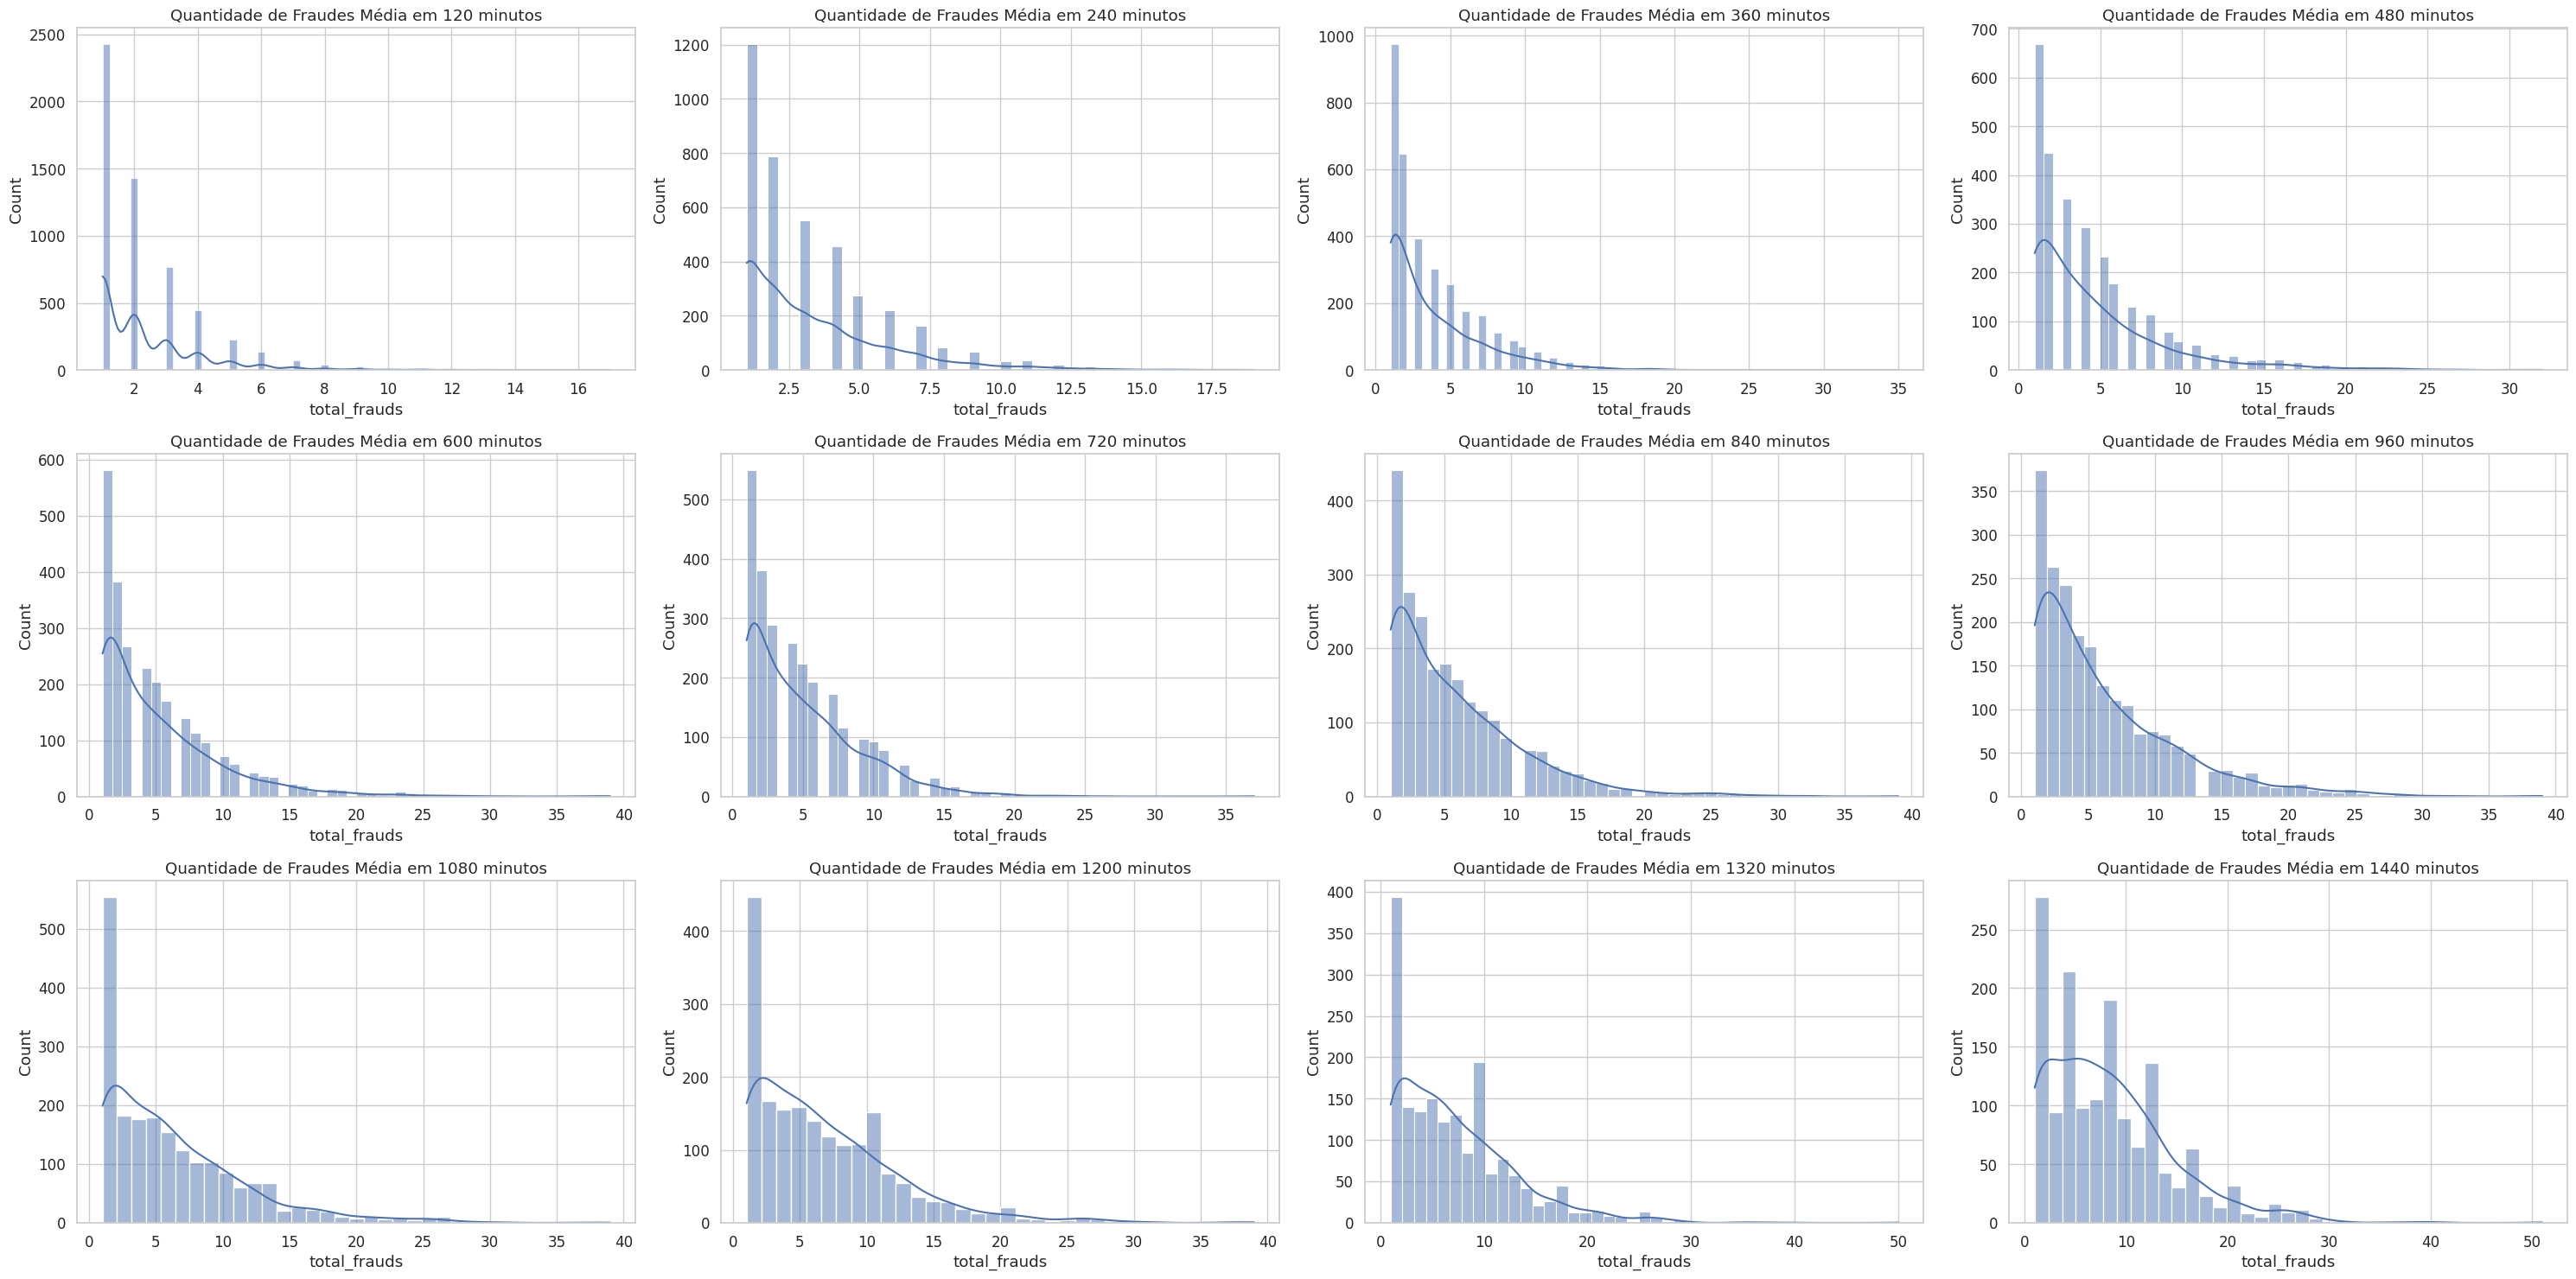

In [21]:
minutes = [120, 240, 360, 480, 600, 720, 840, 960, 1080, 1200, 1320, 1440]
df_time = df.to_pandas()

# Define número de colunas
cols = 4
# Calcula número de linhas necessárias
rows = math.ceil(len(minutes) / cols)

plt.figure(figsize=(30, 5 * rows))  # Ajuste proporcional ao número de linhas

for i, minute in enumerate(minutes):
    plt.subplot(rows, cols, i + 1)
    plt.title(f'Quantidade de Fraudes Média em {minute} minutos')

    df_minutes = pd.DataFrame()
    df_minutes['slide_date'] = df_time['date'].dt.floor(f'{minute}T')
    df_minutes['target'] = df_time['target']

    df_minutes = df_minutes.groupby(by='slide_date').agg({'target': 'sum'}).reset_index()
    df_minutes.columns = ['slide_date', 'total_frauds']

    sns.histplot(df_minutes.query('total_frauds > 0')['total_frauds'], kde=True)

plt.tight_layout()
plt.show()

### Validação com modelos dummies

In [20]:
# window_data_builder = WindowDataBuilder(df, discretize_numerical=False, discretization_strategy='uniform')

In [33]:
# %%time

# builders = []

# for minute in tqdm(minutes, desc='Validando periodos'):
#   df_train, _ = window_data_builder.build(f'{minute}m', False, True)

#   builder = BaselineCoutingModel(df_train, f'{minute}m')
#   builder.train()
#   builders.append(builder)

In [34]:
%%time

builders = []

for minute in tqdm(minutes, desc='Validando periodos'):

  feature_engineering = FraudFeatureEngineer(freq=f'{minute}T')
  df_train = feature_engineering.engineer_features(df.to_pandas())

  builder = BaselineCoutingModel(df_train, f'{minute}m')
  builder.train()
  builders.append(builder)

Validando periodos:   0%|          | 0/12 [00:00<?, ?it/s]

Carregando e pré-processando dados...
Criando índice temporal...
Adicionando features temporais...
Adicionando features comportamentais...
Adicionando features de risco...
Adicionando features sazonais...
Adicionando features de mudança...
Adicionando features de rede...
Adicionando variável target...
Preenchendo valores ausentes...
Feature engineering concluído!
Training BASELINE Poisson with window 120m
Training BASELINE Binomial Negativa with window 120m
Training BASELINE ZIP with window 120m
Training BASELINE ZINB with window 120m
Baseline Models Trained
Carregando e pré-processando dados...
Criando índice temporal...
Adicionando features temporais...
Adicionando features comportamentais...
Adicionando features de risco...
Adicionando features sazonais...
Adicionando features de mudança...
Adicionando features de rede...
Adicionando variável target...
Preenchendo valores ausentes...
Feature engineering concluído!
Training BASELINE Poisson with window 240m
Training BASELINE Binomial

In [35]:
df_report = pd.concat(list(map(lambda x: x.get_report(), builders)))
df_report.sort_values(by=['LLF'], inplace=True, ascending=False)
df_report.reset_index(drop=True, inplace=True)
df_report

window         model_name           LLF            BIC           AIC  \
0   1440m  Binomial Negativa  -7375.230552   14766.834033  14754.461104   
1   1320m               ZINB  -7814.074430   15652.968870  15634.148860   
2   1320m  Binomial Negativa  -8032.226120   16080.998914  16068.452241   
3   1200m               ZINB  -8272.790206   16570.686492  16551.580413   
4   1200m  Binomial Negativa  -8482.600837   16981.939060  16969.201673   
5   1440m                ZIP  -8654.593059   17325.559048  17313.186119   
6   1080m               ZINB  -8841.880661   17709.183553  17689.761322   
7   1080m  Binomial Negativa  -9008.839827   18034.627808  18021.679654   
8    960m               ZINB  -9331.161139   18688.097510  18668.322278   
9    960m  Binomial Negativa  -9456.677230   18930.537949  18917.354461   
10  1320m                ZIP  -9466.387063   18949.320800  18936.774126   
11  1200m                ZIP  -9914.607507   19845.952401  19833.215015   
12   840m               ZINB  -9924.798410   19875.772854  19855.596819   
13   840m  Binomial Negativa -10059.176834   20135.804357  20122.353667   
14  1080m                ZIP -10653.247914   21323.443981  21310.495827   
15   720m               ZINB -11214.848314   22456.335046  22435.696629   
16   720m  Binomial Negativa -11392.129872   22802.018690  22788.259745   
17   960m                ZIP -11438.067262   22893.318011  22880.134524   
18   600m  Binomial Negativa -11720.489715   23459.102878  23444.979429   
19   840m                ZIP -11987.970261   23993.391212  23979.940522   
20   720m                ZIP -12557.963793   25133.686530  25119.927586   
21   480m               ZINB -12889.274116   25806.402905  25784.548231   
22   480m  Binomial Negativa -13003.331815   26025.233412  26010.663630   
23   600m                ZIP -13613.005337   27244.134123  27230.010674   
24   480m                ZIP -14829.150952   29676.871686  29662.301904   
25   360m               ZINB -15182.174559   30393.066769  30370.349119   
26   360m  Binomial Negativa -15278.935165   30577.015430  30561.870330   
27   360m                ZIP -16726.133031   33471.411161  33456.266061   
28  1320m            Poisson -17019.180282   -4594.214654  34040.360564   
29  1440m            Poisson -17147.225232    -732.397416  34296.450464   
30  1200m            Poisson -17654.395563   -7256.111791  35310.791126   
31   240m  Binomial Negativa -18326.590286   36673.136556  36657.180572   
32  1080m            Poisson -18488.289934  -10426.383053  36978.579869   
33   240m                ZIP -19060.382600   38140.721184  38124.765200   
34   960m            Poisson -19912.276693  -13436.164987  39826.553386   
35   720m            Poisson -20784.394004  -30506.331445  41570.788007   
36   840m            Poisson -21107.751371  -18756.464215  42217.502742   
37   600m            Poisson -24094.193406  -37902.607411  48190.386812   
38   120m               ZINB -25468.582681   50969.178710  50943.165363   
39   120m  Binomial Negativa -25579.940191   51181.222614  51163.880382   
40   480m            Poisson -26024.003242  -56560.489898  52050.006485   
41   120m                ZIP -26065.679492   52152.701216  52135.358984   
42   360m            Poisson -27662.365506  -91994.940001  55326.731011   
43   240m            Poisson -30836.832927 -164435.475778  61675.665853   
44   120m            Poisson -36279.864649 -401620.478195  72561.729298   
45   240m               ZINB           NaN            NaN           NaN   
46   600m               ZINB           NaN            NaN           NaN   
47  1440m               ZINB           NaN            NaN           NaN   

    Converged      PseudoR2  RMSE_Pearson  Outliers  
0        True  9.546886e-11      0.720857        91  
1        True  1.372447e-11      0.981212       179  
2        True  3.510026e-11      0.765593        94  
3        True  8.756962e-11      0.980262       200  
4        True  4.246747e-11      0.773576       134  
5  

In [36]:
df_report_filter = df_report[df_report.LLF.notna()].groupby('window').agg(count=('window', 'count'), llf=('LLF', 'median'))
df_report_filter.query('count == 4', inplace=True)
df_report_filter.sort_values(by=['llf'], ascending=False, inplace=True)
df_report_filter.reset_index(inplace=True)
df_report_filter

window  count           llf
0  1320m      4  -8749.306592
1  1200m      4  -9198.604172
2  1080m      4  -9831.043870
3   960m      4 -10447.372246
4   840m      4 -11023.573547
5   720m      4 -11975.046833
6   480m      4 -13916.241384
7   360m      4 -16002.534098
8   120m      4 -25822.809842

### Seleção da melhor janela de tempo

In [38]:
selected_builder = list(filter(lambda x: x.window == df_report_filter.loc[0, 'window'], builders))[0]
selected_builder.get_report()

window         model_name           LLF           BIC           AIC  \
0  1320m            Poisson -17019.180282  -4594.214654  34040.360564   
1  1320m  Binomial Negativa  -8032.226120  16080.998914  16068.452241   
2  1320m                ZIP  -9466.387063  18949.320800  18936.774126   
3  1320m               ZINB  -7814.074430  15652.968870  15634.148860   

   Converged      PseudoR2  RMSE_Pearson  Outliers  
0       True  1.887379e-15      2.923676       809  
1       True  3.510026e-11      0.765593        94  
2       True  5.741518e-12      1.307860       350  
3       True  1.372447e-11      0.981212       179

#### Visualização da distribuição observada dos eventos X modelo dummy

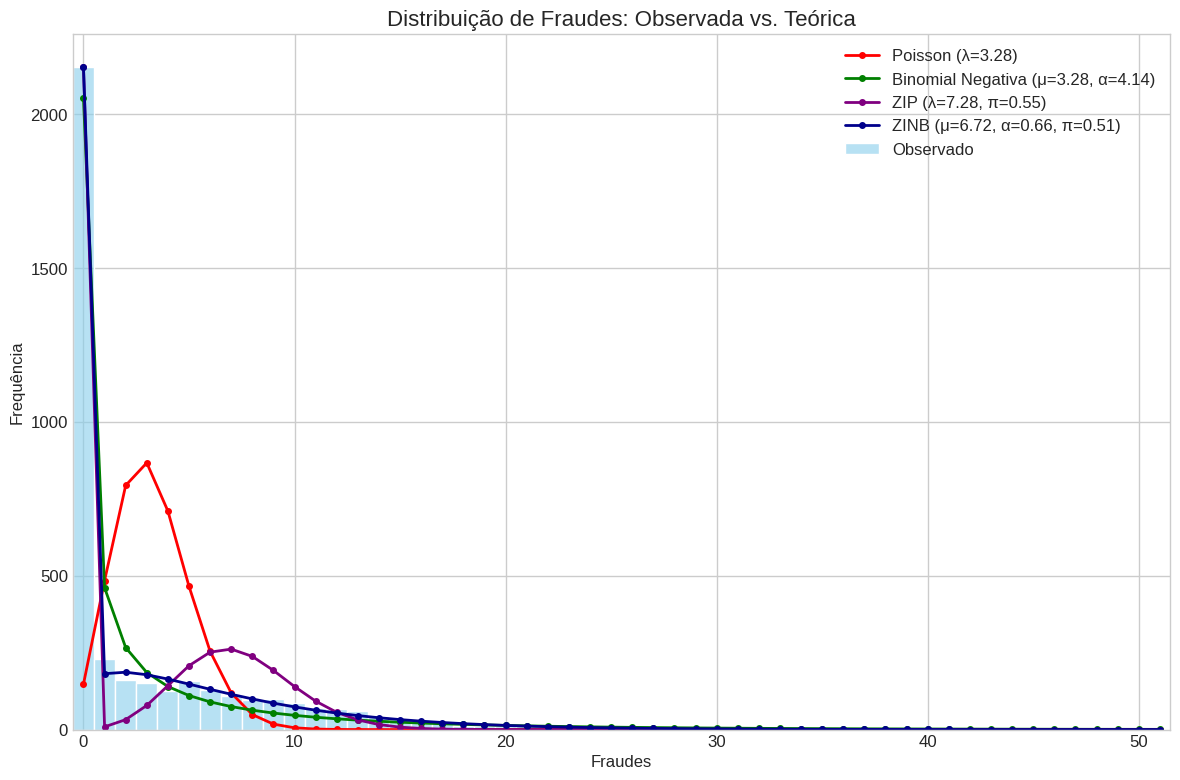

In [39]:
selected_builder.plot_theoretical_distributions()

In [40]:
selected_builder.df.head()

total_transactions  total_amount  chip_ratio  \
2010-01-01 00:00:00                2074      92904.03         0.0   
2010-01-01 22:00:00                1776      92892.85         0.0   
2010-01-02 20:00:00                1963      94943.47         0.0   
2010-01-03 18:00:00                1940      92607.88         0.0   
2010-01-04 16:00:00                1846      92506.13         0.0   

                     txn_velocity  avg_txn_value  geo_dispersion  \
2010-01-01 00:00:00      0.576111      44.794614       21.218228   
2010-01-01 22:00:00      0.493333      52.304533       20.926476   
2010-01-02 20:00:00      0.545278      48.366516       21.587203   
2010-01-03 18:00:00      0.538889      47.736021       21.610378   
2010-01-04 16:00:00      0.512778      50.111663       20.453615   

                     merchant_entropy  avg_credit_score  error_ratio  \
2010-01-01 00:00:00          5.347912        714.264224     0.014465   
2010-01-01 22:00:00          5.446203        712.390203     0.016329   
2010-01-02 20:00:00          5.430923        716.460520     0.012736   
2010-01-03 18:00:00          5.396481        714.252577     0.016495   
2010-01-04 16:00:00          5.427792        710.826652     0.010834   

                     hour_of_day  day_of_week  is_weekend  is_holiday  \
2010-01-01 00:00:00            0            4           0           1   
2010-01-01 22:00:00           22            4           0           1   
2010-01-02 20:00:00           20            5           1           0   
2010-01-03 18:00:00           18            6           1           0   
2010-01-04 16:00:00           16            0           0           0   

                     txn_volume_change  avg_value_change  velocity_alert  \
2010-01-01 00:00:00           0.000000          0.000000               0   
2010-01-01 22:00:00          -0.143684          0.167652               0   
2010-01-02 20:00:00           0.105293         -0.075290               0   
2010-01-03 18:00:00          -0.011717         -0.013036               0   
2010-01-04 16:00:00          -0.048454          0.049766               0   

                     unique_clients  unique_cards  cards_per_client  frauds  
2010-01-01 00:00:00             859          1227          1.428405     0.0  
2010-01-01 22:00:00             825          1121          1.358788     1.0  
2010-01-02 20:00:00             853          1189          1.393904     0.0  
2010-01-03 18:00:00             873          1205          1.380298     1.0  
2010-01-04 16:00:00             842          1168          1.387173     3.0

In [41]:
selected_builder.df.describe()

total_transactions   total_amount   chip_ratio  txn_velocity  \
count         3918.000000    3918.000000  3918.000000   3918.000000   
mean          2162.374681  109295.993520     0.346549      0.600660   
std            184.067293    8242.702358     0.352558      0.051130   
min             80.000000    6641.420000     0.000000      0.022222   
25%           2034.250000  103871.902500     0.000000      0.565069   
50%           2162.000000  109096.760000     0.000000      0.600556   
75%           2295.750000  114692.650000     0.705070      0.637708   
max           2616.000000  136957.770000     0.734658      0.726667   

       avg_txn_value  geo_dispersion  merchant_entropy  avg_credit_score  \
count    3918.000000     3918.000000       3918.000000       3918.000000   
mean       50.688209       21.348138          5.515102        714.107944   
std         3.121235        0.300847          0.070386          1.389136   
min        40.017571       20.377970          3.991962        708.837862   
25%        48.437788       21.150057          5.470431        713.170399   
50%        50.300103       21.337290          5.510964        714.131208   
75%        52.798466       21.547944          5.558044        715.033008   
max        83.017750       22.571104          5.741147        718.976524   

       error_ratio  hour_of_day  day_of_week   is_weekend   is_holiday  \
count  3918.000000  3918.000000  3918.000000  3918.000000  3918.000000   
mean      0.015993    11.006126     3.000766     0.285860     0.028076   
std       0.002788     6.907202     2.000191     0.451881     0.165210   
min       0.006323     0.000000     0.000000     0.000000     0.000000   
25%       0.014074     6.000000     1.000000     0.000000     0.000000   
50%       0.015873    12.000000     3.000000     0.000000     0.000000   
75%       0.017803    18.000000     5.000000     1.000000     0.000000   
max       0.027778    22.000000     6.000000     1.000000     1.000000   

       txn_volume_change  avg_value_change  velocity_alert  unique_clients  \
count        3918.000000       3918.000000     3918.000000     3918.000000   
mean            0.009845          0.002711        0.006126      941.621491   
std             0.447971          0.072862        0.078036       44.058284   
min            -0.958333         -0.361683        0.000000       74.000000   
25%            -0.036720         -0.040939        0.000000      917.000000   
50%            -0.003616          0.003554        0.000000      947.000000   
75%             0.038934          0.046638        0.000000      972.000000   
max            27.412500          0.647093        1.000000     1027.000000   

       unique_cards  cards_per_client       frauds  
count   3918.000000       3918.000000  3918.000000  
mean    1409.708014          1.495187     3.277693  
std      104.462481          0.048589     5.293815  
min       78.000000          1.054054     0.000000  
25%     1344.000000          1.465129     0.000000  
50%     1419.000000          1.498418     0.000000  
75%     1482.000000          1.529588     5.000000  
max     1642.000000          1.615540    51.000000

#### Correlação dos dados no dataframe da janela selecionada

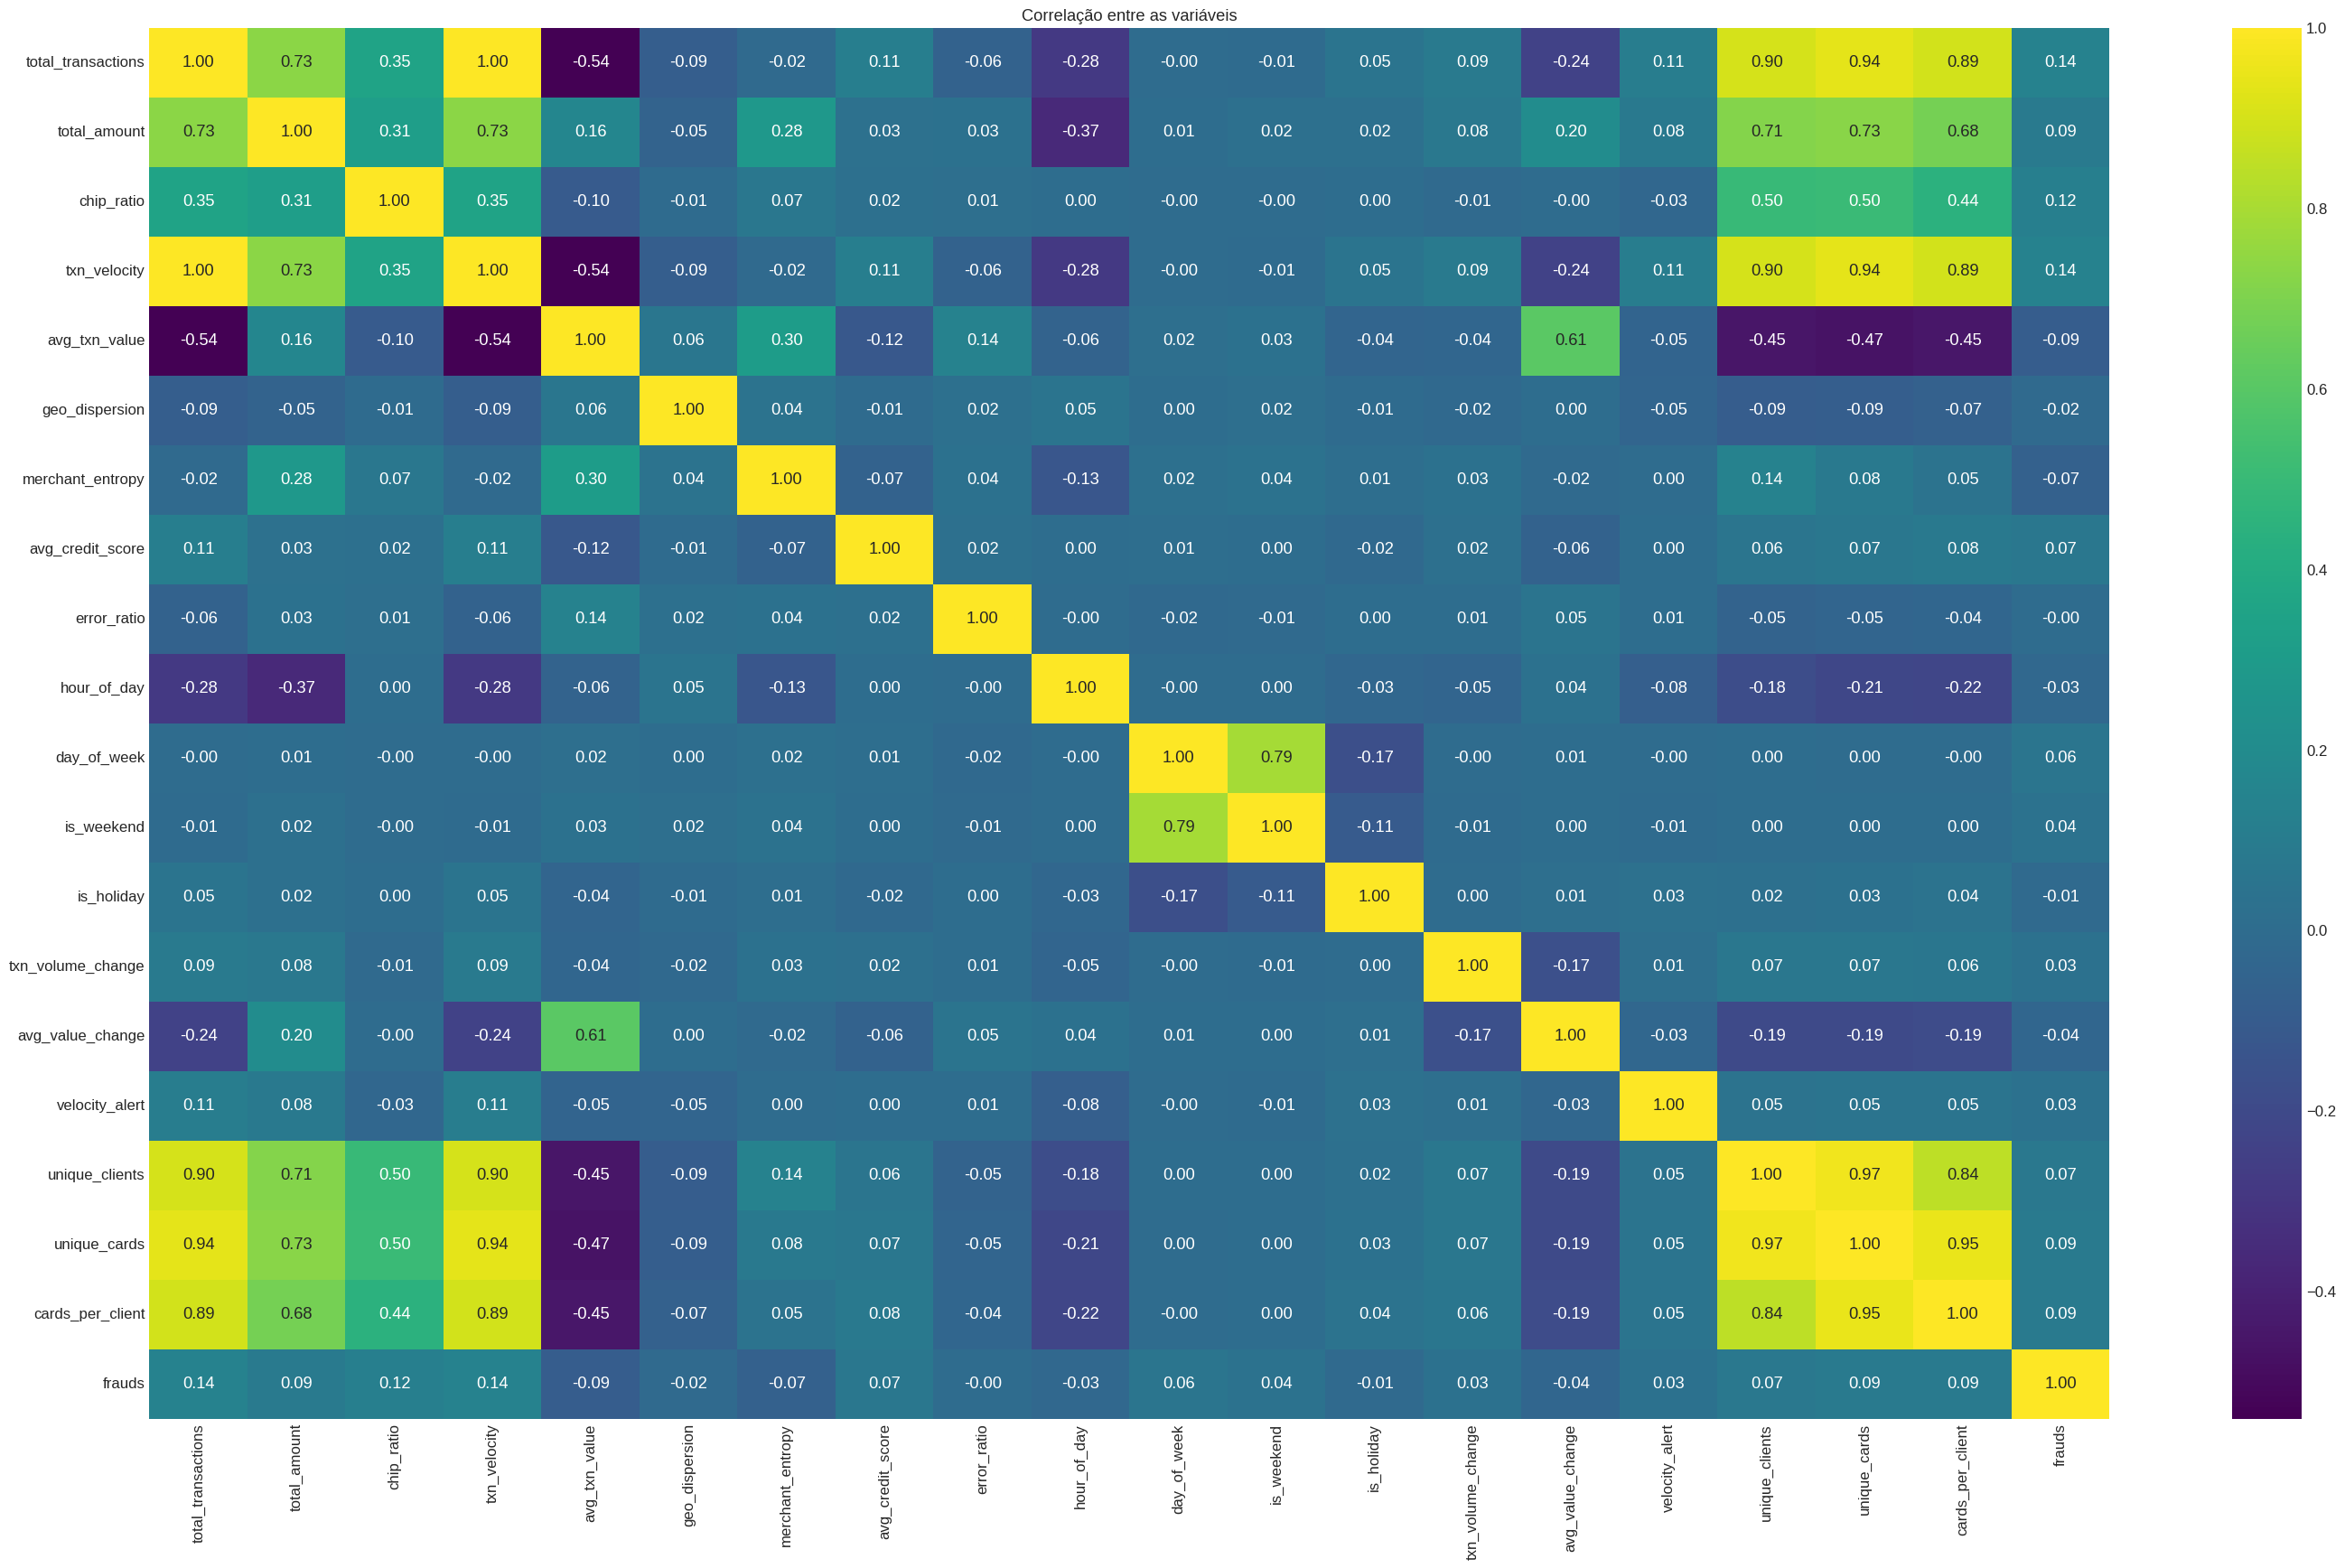

In [42]:
corr = selected_builder.df.corr(numeric_only=True)
plt.figure(figsize=(35,20))
plt.title('Correlação entre as variáveis')

sns.heatmap(corr, annot=True, cmap='viridis', fmt='.2f')

plt.show()

#### Correlação do dataframe após removação de variaveis com alta correlação

In [44]:
feature_engineering = FraudFeatureEngineer(freq=selected_builder.window.replace('m', 'T'))
df_train = feature_engineering.engineer_features(df.to_pandas())

Carregando e pré-processando dados...
Criando índice temporal...
Adicionando features temporais...
Adicionando features comportamentais...
Adicionando features de risco...
Adicionando features sazonais...
Adicionando features de mudança...
Adicionando features de rede...
Adicionando variável target...
Preenchendo valores ausentes...
Feature engineering concluído!


In [45]:
selected_builder = BaselineCoutingModel(df_train, selected_builder.window)
selected_builder.train()

Training BASELINE Poisson with window 1320m
Training BASELINE Binomial Negativa with window 1320m
Training BASELINE ZIP with window 1320m
Training BASELINE ZINB with window 1320m
Baseline Models Trained


In [29]:
# df_train, map_discretizer = window_data_builder.build(selected_builder.window, True, True)
# selected_builder = BaselineCoutingModel(df_train, selected_builder.window)
# selected_builder.train()

Removed 9 highly correlated features
Columns removed: target_description_1, target_country_0, max_credit_score, target_city_2, min_credit_limit, target_country_2, min_credit_score, min_total_debt, mean_amount
Training BASELINE Poisson with window 1440m
Training BASELINE Binomial Negativa with window 1440m
Training BASELINE ZIP with window 1440m
Training BASELINE ZINB with window 1440m
Baseline Models Trained


In [46]:
# corr = selected_builder.df.corr(numeric_only=True)
# plt.figure(figsize=(35,20))
# plt.title('Correlação entre as variáveis')

# sns.heatmap(corr, annot=True, cmap='viridis', fmt='.2f')

# plt.show()

## Modelagem

### **Métricas de Avaliação de Modelos: LLF, AIC e BIC**

Estas métricas são usadas para avaliar e comparar modelos estatísticos, buscando um equilíbrio entre o bom ajuste aos dados e a simplicidade do modelo.

---

### **1. LLF (Log-Likelihood Function / Função de Log-Verossimilhança)**

Mede o quão bem o modelo se ajusta aos dados observados.

* **Foco:** Apenas na qualidade do ajuste.
* **Interpretação:** Quanto **maior** o valor, melhor o modelo explica os dados.
* **Limitação:** Não penaliza a complexidade. Modelos mais complexos quase sempre terão uma LLF maior.

---

### **2. AIC (Akaike Information Criterion / Critério de Informação de Akaike)**

Busca um equilíbrio entre a qualidade do ajuste (LLF) e a complexidade do modelo (número de parâmetros).

* **Fórmula:**
    $$ \text{AIC} = 2k - 2 \ln(\hat{L}) $$
    * $k$: número de parâmetros do modelo.
    * $\ln(\hat{L})$: valor da Log-Verossimilhança.
* **Foco:** Encontrar o melhor modelo para previsões.
* **Interpretação:** O modelo com o **menor** valor de AIC é preferível.

---

### **3. BIC (Bayesian Information Criterion / Critério de Informação Bayesiano)**

Similar ao AIC, mas aplica uma penalidade mais rigorosa à complexidade, especialmente para grandes volumes de dados.

* **Fórmula:**
    $$ \text{BIC} = \ln(n)k - 2 \ln(\hat{L}) $$
    * $n$: número de observações (tamanho da amostra).
    * $k$: número de parâmetros do modelo.
    * $\ln(\hat{L})$: valor da Log-Verossimilhança.
* **Foco:** Encontrar o modelo mais provável de ser o "verdadeiro" gerador dos dados.
* **Interpretação:** O modelo com o **menor** valor de BIC é preferível. Geralmente, seleciona modelos mais simples que o AIC.

---

### **Tabela Resumo**

| Métrica | Foco Principal | Interpretação |
| :--- | :--- | :--- |
| **LLF** | Qualidade do ajuste | Quanto **maior**, melhor |
| **AIC** | Equilíbrio (Ajuste vs. Complexidade) | Quanto **menor**, melhor |
| **BIC** | Equilíbrio (com maior penalidade à complexidade) | Quanto **menor**, melhor |

In [ ]:
# X = selected_builder.df.drop(columns=['date_window']).copy()
# y = X['frauds']

In [49]:
X = selected_builder.df.copy()
y = X['frauds']

In [50]:
X.describe().T

count           mean          std          min  \
total_transactions  3918.0    2162.374681   184.067293    80.000000   
total_amount        3918.0  109295.993520  8242.702358  6641.420000   
chip_ratio          3918.0       0.346549     0.352558     0.000000   
txn_velocity        3918.0       0.600660     0.051130     0.022222   
avg_txn_value       3918.0      50.688209     3.121235    40.017571   
geo_dispersion      3918.0      21.348138     0.300847    20.377970   
merchant_entropy    3918.0       5.515102     0.070386     3.991962   
avg_credit_score    3918.0     714.107944     1.389136   708.837862   
error_ratio         3918.0       0.015993     0.002788     0.006323   
hour_of_day         3918.0      11.006126     6.907202     0.000000   
day_of_week         3918.0       3.000766     2.000191     0.000000   
is_weekend          3918.0       0.285860     0.451881     0.000000   
is_holiday          3918.0       0.028076     0.165210     0.000000   
txn_volume_change   3918.0       0.009845     0.447971    -0.958333   
avg_value_change    3918.0       0.002711     0.072862    -0.361683   
velocity_alert      3918.0       0.006126     0.078036     0.000000   
unique_clients      3918.0     941.621491    44.058284    74.000000   
unique_cards        3918.0    1409.708014   104.462481    78.000000   
cards_per_client    3918.0       1.495187     0.048589     1.054054   
frauds              3918.0       3.277693     5.293815     0.000000   

                              25%            50%            75%            max  
total_transactions    2034.250000    2162.000000    2295.750000    2616.000000  
total_amount        103871.902500  109096.760000  114692.650000  136957.770000  
chip_ratio               0.000000       0.000000       0.705070       0.734658  
txn_velocity             0.565069       0.600556       0.637708       0.726667  
avg_txn_value           48.437788      50.300103      52.798466      83.017750  
geo_dispersion          21.150057      21.337290      21.547944      22.571104  
merchant_entropy         5.470431       5.510964       5.558044       5.741147  
avg_credit_score       713.170399     714.131208     715.033008     718.976524  
error_ratio              0.014074       0.015873       0.017803       0.027778  
hour_of_day              6.000000      12.000000      18.000000      22.000000  
day_of_week              1.000000       3.000000       5.000000       6.000000  
is_weekend               0.000000       0.000000       1.000000       1.000000  
is_holiday               0.000000       0.000000       0.000000       1.000000  
txn_volume_change       -0.036720      -0.003616       0.038934      27.412500  
avg_value_change        -0.040939       0.003554       0.046638       0.647093  
velocity_alert           0.000000       0.000000       0.000000       1.000000  
unique_clients         917.000000     947.000000     972.000000    1027.000000  
unique_cards          1344.000000    1419.000000    1482.000000    1642.000000  
cards_per_client         1.465129       1.498418       1.529588       1.615540  
frauds                   0.000000       0.000000       5.000000      51.000000

In [51]:
y.value_counts()

frauds
0.0     2154
1.0      228
2.0      160
5.0      159
3.0      152
6.0      129
4.0      127
7.0      108
9.0      100
8.0       97
10.0      85
11.0      69
12.0      67
13.0      59
14.0      45
15.0      32
17.0      27
16.0      26
19.0      13
18.0      12
20.0      11
21.0      11
25.0       9
23.0       7
22.0       7
29.0       4
26.0       4
27.0       4
28.0       3
24.0       3
30.0       2
40.0       1
51.0       1
39.0       1
36.0       1
Name: count, dtype: int64

### Modelo de Regressão de Poisson  

Um GLM para Modelagem de Dados de Contagem

A **Regressão de Poisson** é um modelo da família dos **Modelos Lineares Generalizados (GLMs)**, apropriado para variáveis dependentes representadas por **contagens**, ou seja, números inteiros não negativos que expressam a quantidade de vezes que um determinado evento ocorre dentro de um intervalo fixo de tempo ou espaço.

---

### Estrutura dos Dados

Variáveis de contagem apresentam as seguintes características:

- Assumem valores inteiros e não negativos: $0, 1, 2, \dots$.
- Representam frequências de ocorrência de um evento.
- Apresentam, sob hipótese da Poisson, **média e variância iguais**: $\mathbb{E}[Y] = \mathrm{Var}(Y) = \lambda$.

---

### Distribuição de Poisson

A variável aleatória $Y$ segue uma distribuição de Poisson quando sua probabilidade de assumir o valor $k$ é dada por:

$$
P(Y = k) = \frac{\lambda^k e^{-\lambda}}{k!}, \quad k = 0, 1, 2, \dots
$$

onde:

- $\lambda > 0$ é o parâmetro da distribuição, que representa a média e a variância;
- $e$ é a base do logaritmo natural;
- $k!$ é o fatorial de $k$.

---

### Formulação da Regressão de Poisson

A regressão de Poisson modela o valor esperado da variável dependente $Y_i$ como uma função exponencial de uma combinação linear de variáveis explicativas.

Assume-se que:

$$
Y_i \sim \text{Poisson}(\lambda_i)
$$

com:

$$
\log(\lambda_i) = \beta_0 + \beta_1 x_{i1} + \beta_2 x_{i2} + \dots + \beta_p x_{ip}
$$

Ou, de forma vetorial:

$$
\log(\lambda_i) = x_i^\top \beta
$$

Assim, a média condicional esperada da variável resposta é dada por:

$$
\lambda_i = \exp(x_i^\top \beta)
$$

---

### Propriedade de Equidispersão

No modelo de Poisson, assume-se que:

$$
\mathrm{Var}(Y_i) = \mathbb{E}[Y_i] = \lambda_i
$$

Esse equilíbrio entre média e variância é conhecido como **equidispersão**. Caso essa condição não seja atendida (por exemplo, se a variância for significativamente maior que a média), o modelo torna-se inadequado e pode exigir alternativas como o modelo **binomial negativo**.

---

### Interpretação dos Coeficientes

Os coeficientes $\beta_j$ da regressão de Poisson são interpretados em termos da **razão de taxas**. O modelo log-linear define:

$$
\log(\lambda_i) = \beta_0 + \sum_{j=1}^{p} \beta_j x_{ij}
$$

Portanto, exponenciando $\beta_j$:

$$
e^{\beta_j}
$$

representa o fator pelo qual a taxa esperada de ocorrência $\lambda_i$ é multiplicada a cada aumento unitário em $x_{ij}$, mantendo constantes os demais preditores.

---

### Estimação

A estimação dos parâmetros do modelo é realizada por **máxima verossimilhança**, considerando a função de verossimilhança derivada da distribuição de Poisson. A convergência do modelo depende da estrutura dos dados e da ausência de sobredispersão relevante.


#### Validação de presuposto

Os dados devem apresentar **equidispersão**, ou seja, média igual a variância.

In [52]:
pd.DataFrame({'Média':[y.mean()],'Variância':[y.var()]})

Média  Variância
0  3.277693  28.024475

Existe uma diferença muito grande entre a média e a variancia referente a variável alvo, indicando possível subdispersão nos dados.

#### Implementação dos modelos

##### Completo

In [53]:
formula = "frauds ~ " + ' + '.join(X.drop(columns=['frauds']).columns)
formula

'frauds ~ total_transactions + total_amount + chip_ratio + txn_velocity + avg_txn_value + geo_dispersion + merchant_entropy + avg_credit_score + error_ratio + hour_of_day + day_of_week + is_weekend + is_holiday + txn_volume_change + avg_value_change + velocity_alert + unique_clients + unique_cards + cards_per_client'

In [54]:
modelo_poisson  = smf.glm(formula=formula, data=X, family=sm.families.Poisson()).fit()

In [55]:
modelo_poisson.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 frauds   No. Observations:                 3918
Model:                            GLM   Df Residuals:                     3899
Model Family:                 Poisson   Df Model:                           18
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -15643.
Date:                Wed, 20 Aug 2025   Deviance:                       25061.
Time:                        01:38:04   Pearson chi2:                 3.02e+04
No. Iterations:                     6   Pseudo R-squ. (CS):             0.5045
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             20.3668      7.253      2.808      0.005       6.150      34.583
total_transactions    -0.0009      0.001     -1.047      0.295      -0.003       0.001
total_amount           0.0001   1.58e-05      9.238      0.000       0.000       0.000
chip_ratio             1.1149      0.037     30.301      0.000       1.043       1.187
txn_velocity       -2.468e-07   2.36e-07     -1.047      0.295   -7.09e-07    2.15e-07
avg_txn_value         -0.3091      0.034     -9.059      0.000      -0.376      -0.242
geo_dispersion        -0.0682      0.030     -2.265      0.024      -0.127      -0.009
merchant_entropy      -0.3097      0.166     -1.864      0.062      -0.635       0.016
avg_credit_score       0.0374      0.007      5.709      0.000       0.025       0.050
error_ratio            4.4477      3.265      1.362      0.173      -1.952      10.847
hour_of_day            0.0092      0.001      6.573      0.000       0.006       0.012
day_of_week            0.0591      0.007      7.905      0.000       0.044       0.074
is_weekend            -0.0616      0.032     -1.939      0.053      -0.124       0.001
is_holiday            -0.1283      0.058     -2.216      0.027      -0.242      -0.015
txn_volume_change      0.0310      0.012      2.516      0.012       0.007       0.055
avg_value_change      -0.0879      0.167     -0.528      0.598      -0.414       0.239
velocity_alert        -0.0872      0.089     -0.980      0.327      -0.262       0.087
unique_clients        -0.0319      0.004     -7.526      0.000      -0.040      -0.024
unique_cards           0.0085      0.003      2.840      0.005       0.003       0.014
cards_per_client     -15.9282      2.792     -5.705      0.000     -21.400     -10.456
======================================================================================
"""

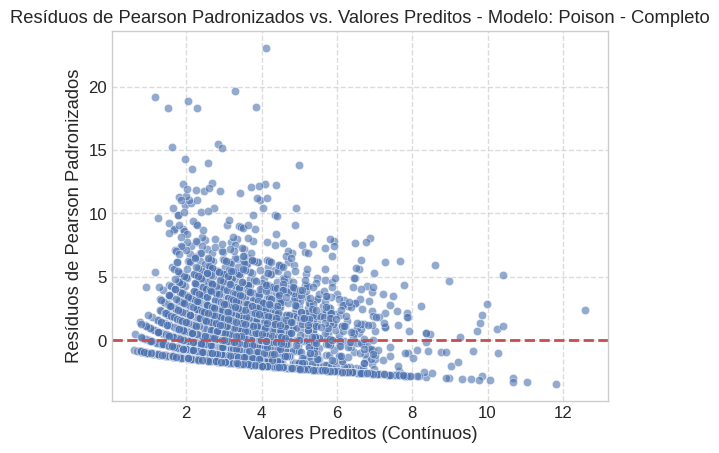

In [56]:
overdisp_plot(modelo_poisson, 'Poison - Completo')

In [57]:
diagnosticar_dispersao_ct(modelo_poisson, y)

--- Diagnóstico de Dispersão (Teste de Cameron & Trivedi) ---
P-valor do teste: 0.0000
Resultado (α = 0.05): Hipótese nula rejeitada.
Conclusão: Há evidência de má especificação da dispersão (ex: sobredispersão não capturada).
-------------------------------------------------------------


{'estatistica_t': np.float64(8.009818296772151),
 'p_valor': np.float64(1.5018707974242302e-15)}

O gráfico acima demonstra como o modelo tem dificuldade para prever os valores. O um padrão de funil no dados demonstra que o presuposto de equidispersão não foi atendido, e a variância dos resíduos não é constante em relação à média prevista, sendo muito maior para contagens baixas.

In [58]:
overdisp(modelo_poisson, X)

Estimating model...: 
 GLM
                        Results: Ordinary least squares
Model:                  OLS              Adj. R-squared (uncentered): 0.070     
Dependent Variable:     ystar            AIC:                         35543.2778
Date:                   2025-08-20 01:38 BIC:                         35549.5511
No. Observations:       3918             Log-Likelihood:              -17771.   
Df Model:               1                F-statistic:                 296.7     
Df Residuals:           3917             Prob (F-statistic):          3.81e-64  
R-squared (uncentered): 0.070            Scale:                       509.62    
--------------------------------------------------------------------------------------
            Coef.        Std.Err.          t          P>|t|        [0.025       0.975]
--------------------------------------------------------------------------------------
lmbda       1.7091         0.0992       17.2243       0.0000       1.5145       1.9036
--

O teste evidencia o ponto já validado inicialmente do presuposto. O modelo não atende a capacidade de overdispersion.

##### Stepwise

In [59]:
modelo_poisson_stepwise = stepwise(modelo_poisson, pvalue_limit=0.05)
modelo_poisson_stepwise.summary()

Regression type: GLM 

Estimating model...: 
 frauds ~ Q('total_transactions') + Q('total_amount') + Q('chip_ratio') + Q('txn_velocity') + Q('avg_txn_value') + Q('geo_dispersion') + Q('merchant_entropy') + Q('avg_credit_score') + Q('error_ratio') + Q('hour_of_day') + Q('day_of_week') + Q('is_weekend') + Q('is_holiday') + Q('txn_volume_change') + Q('avg_value_change') + Q('velocity_alert') + Q('unique_clients') + Q('unique_cards') + Q('cards_per_client')

 Family type...: 
 Poisson

 Discarding atribute "Q('avg_value_change')" with p-value equal to 0.597585258942948 

Estimating model...: 
 frauds ~ Q('total_transactions') + Q('total_amount') + Q('chip_ratio') + Q('txn_velocity') + Q('avg_txn_value') + Q('geo_dispersion') + Q('merchant_entropy') + Q('avg_credit_score') + Q('error_ratio') + Q('hour_of_day') + Q('day_of_week') + Q('is_weekend') + Q('is_holiday') + Q('txn_volume_change') + Q('velocity_alert') + Q('unique_clients') + Q('unique_cards') + Q('cards_per_client')

 Family type..

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 frauds   No. Observations:                 3918
Model:                            GLM   Df Residuals:                     3905
Model Family:                 Poisson   Df Model:                           12
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -15649.
Date:                Wed, 20 Aug 2025   Deviance:                       25072.
Time:                        01:38:16   Pearson chi2:                 3.03e+04
No. Iterations:                     6   Pseudo R-squ. (CS):             0.5032
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 15.0819      5.185      2.909      0.004       4.920      25.243
Q('total_amount')          0.0001    3.1e-06     41.824      0.000       0.000       0.000
Q('chip_ratio')            1.1192      0.036     30.738      0.000       1.048       1.191
Q('avg_txn_value')        -0.2771      0.006    -42.731      0.000      -0.290      -0.264
Q('geo_dispersion')       -0.0702      0.030     -2.341      0.019      -0.129      -0.011
Q('avg_credit_score')      0.0376      0.007      5.750      0.000       0.025       0.050
Q('hour_of_day')           0.0095      0.001      6.900      0.000       0.007       0.012
Q('day_of_week')           0.0472      0.004     10.513      0.000       0.038       0.056
Q('is_holiday')           -0.1405      0.058     -2.440      0.015      -0.253      -0.028
Q('txn_volume_change')     0.0329      0.012      2.746      0.006       0.009       0.056
Q('unique_clients')       -0.0298      0.002    -16.100      0.000      -0.033      -0.026
Q('unique_cards')          0.0069      0.001      5.108      0.000       0.004       0.010
Q('cards_per_client')    -14.5613      1.424    -10.224      0.000     -17.353     -11.770
==========================================================================================
"""

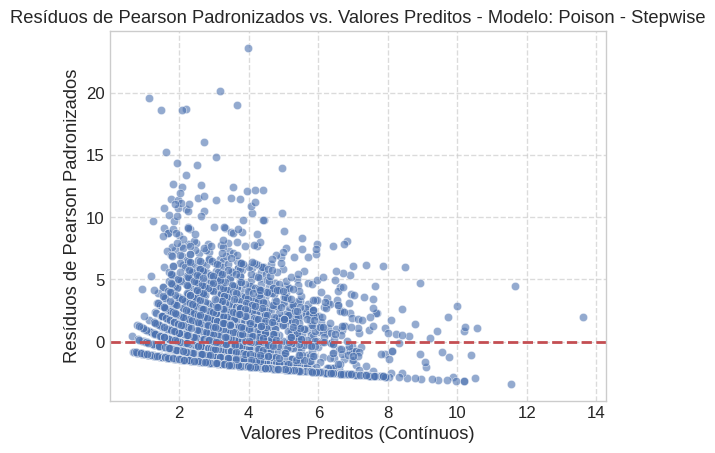

In [60]:
overdisp_plot(modelo_poisson_stepwise, 'Poison - Stepwise')

In [61]:
diagnosticar_dispersao_ct(modelo_poisson_stepwise, y)

--- Diagnóstico de Dispersão (Teste de Cameron & Trivedi) ---
P-valor do teste: 0.0000
Resultado (α = 0.05): Hipótese nula rejeitada.
Conclusão: Há evidência de má especificação da dispersão (ex: sobredispersão não capturada).
-------------------------------------------------------------


{'estatistica_t': np.float64(7.7098544456056075),
 'p_valor': np.float64(1.5866016173191973e-14)}

O gráfico apresenta o mesmo problema relatado no modelo completo, não atendendo o critério de equidispersão.

In [62]:
overdisp(modelo_poisson_stepwise, X)

Estimating model...: 
 GLM
                        Results: Ordinary least squares
Model:                  OLS              Adj. R-squared (uncentered): 0.067     
Dependent Variable:     ystar            AIC:                         35714.6314
Date:                   2025-08-20 01:38 BIC:                         35720.9047
No. Observations:       3918             Log-Likelihood:              -17856.   
Df Model:               1                F-statistic:                 283.5     
Df Residuals:           3917             Prob (F-statistic):          1.78e-61  
R-squared (uncentered): 0.067            Scale:                       532.40    
--------------------------------------------------------------------------------------
            Coef.        Std.Err.          t          P>|t|        [0.025       0.975]
--------------------------------------------------------------------------------------
lmbda       1.7077         0.1014       16.8378       0.0000       1.5089       1.9066
--

### Modelo de Regressão Binomial Negativa  

Um GLM para Dados de Contagem com Sobredispersão

A **Regressão Binomial Negativa** é uma extensão do Modelo de Poisson, indicada quando os dados de contagem apresentam **sobredispersão** — ou seja, a variância é significativamente maior que a média. Esse modelo pertence à família dos Modelos Lineares Generalizados (GLMs) e é recomendado quando a suposição de equidispersão da Poisson não é atendida.

---

### Distribuição Binomial Negativa

Na parametrização usada em modelagem de contagem, a variável aleatória $Y$ segue a distribuição:

$$
Y \sim \text{Binomial Negativa}(\mu, \theta)
$$

com média condicional $\mu$ e parâmetro de dispersão $\theta$. A variância assume a forma:

$$
\mathrm{Var}(Y) = \mu + \frac{\mu^2}{\theta}
$$

onde:

- $\mu > 0$ é a média esperada condicional de $Y$;
- $\theta > 0$ é o parâmetro de dispersão, também chamado de "tamanho" ou "alpha";
- Para $\theta \to \infty$, o modelo converge para a Poisson, reduzindo a variância a $\mu$.

---

### Estrutura do Modelo

O objetivo é expressar a média condicional $\mu_i$ da observação $i$ por meio de uma combinação linear dos preditores $x_i$, garantindo positividade com a função de ligação logaritmo:

$$
\log(\mu_i) = \beta_0 + \beta_1 x_{i1} + \beta_2 x_{i2} + \dots + \beta_p x_{ip}
$$

Ou, compactamente:

$$
\log(\mu_i) = x_i^\top \beta
$$

Portanto, a média esperada é calculada por:

$$
\mu_i = \exp(x_i^\top \beta)
$$

---

### Variância Condicional

A diferença crucial em relação à Poisson está no termo adicional da variância:

$$
\mathrm{Var}(Y_i) = \mu_i + \frac{\mu_i^2}{\theta}
$$

Esse termo permite capturar a sobredispersão observada nos dados, com variância aumentando mais rapidamente do que a média.

---

### Significado dos Coeficientes

Os coeficientes $\beta_j$ mantêm a interpretação em termos de log‑média:

$$
\log(\mu_i) = \beta_0 + \sum_{j=1}^{p} \beta_j x_{ij}
$$

Exponenciando $\beta_j$, temos:

$$
e^{\beta_j}
$$

que representa o **fator multiplicativo** na média esperada $\mu_i$ para cada aumento unitário em $x_{ij}$, mantendo os demais preditores constantes.

---

### Estimação por Máxima Verossimilhança

A estimação envolve ajuste simultâneo de $\beta$ e $\theta$ por máxima verossimilhança. A presença do parâmetro extra permite flexibilidade para se adequar a diferentes níveis de dispersão nos dados.


#### Validação de presuposto

Os dados devem apresentar **sobredispersão**, ou seja, variância maior que a média.

In [63]:
pd.DataFrame({'Média':[y.mean()],'Variância':[y.var()]})

Média  Variância
0  3.277693  28.024475

#### Implementação dos modelos

##### Completo

In [64]:
modelo_binomial = smf.glm(formula=formula, data=X, family=sm.families.NegativeBinomial()).fit()
modelo_binomial.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 frauds   No. Observations:                 3918
Model:                            GLM   Df Residuals:                     3899
Model Family:        NegativeBinomial   Df Model:                           18
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8751.4
Date:                Wed, 20 Aug 2025   Deviance:                       7733.2
Time:                        01:38:27   Pearson chi2:                 7.90e+03
No. Iterations:                    53   Pseudo R-squ. (CS):             0.1690
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             35.8329     16.276      2.202      0.028       3.932      67.734
total_transactions    -0.0029      0.002     -1.493      0.135      -0.007       0.001
total_amount           0.0002   3.63e-05      5.270      0.000       0.000       0.000
chip_ratio             1.2629      0.073     17.366      0.000       1.120       1.405
txn_velocity       -8.067e-07    5.4e-07     -1.493      0.135   -1.87e-06    2.52e-07
avg_txn_value         -0.4193      0.078     -5.394      0.000      -0.572      -0.267
geo_dispersion        -0.0861      0.063     -1.367      0.172      -0.210       0.037
merchant_entropy      -0.6937      0.347     -2.001      0.045      -1.373      -0.014
avg_credit_score       0.0473      0.014      3.438      0.001       0.020       0.074
error_ratio            7.6361      6.823      1.119      0.263      -5.737      21.009
hour_of_day            0.0092      0.003      3.044      0.002       0.003       0.015
day_of_week            0.0711      0.016      4.583      0.000       0.041       0.101
is_weekend            -0.0863      0.067     -1.281      0.200      -0.218       0.046
is_holiday            -0.1201      0.117     -1.023      0.307      -0.350       0.110
txn_volume_change      0.0296      0.039      0.751      0.453      -0.048       0.107
avg_value_change       0.5235      0.355      1.473      0.141      -0.173       1.220
velocity_alert        -0.2914      0.234     -1.244      0.214      -0.751       0.168
unique_clients        -0.0478      0.010     -4.855      0.000      -0.067      -0.029
unique_cards           0.0183      0.007      2.648      0.008       0.005       0.032
cards_per_client     -25.3163      6.412     -3.948      0.000     -37.884     -12.749
======================================================================================
"""

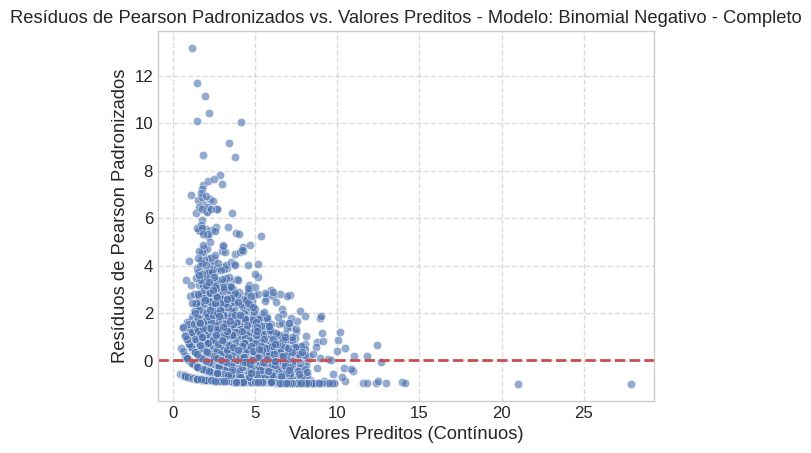

In [65]:
overdisp_plot(modelo_binomial, 'Binomial Negativo - Completo')

In [66]:
diagnosticar_dispersao_ct(modelo_binomial, y)

--- Diagnóstico de Dispersão (Teste de Cameron & Trivedi) ---
P-valor do teste: 0.0000
Resultado (α = 0.05): Hipótese nula rejeitada.
Conclusão: Há evidência de má especificação da dispersão (ex: sobredispersão não capturada).
-------------------------------------------------------------


{'estatistica_t': np.float64(13.709639191792007),
 'p_valor': np.float64(8.09567807966138e-42)}

O gráfico de dispersão de residuos demonstra que o modelo conseguiu capturar melhor a relação dos dados uma vez que o presuposto do modelo foi atendido. No entanto nota-se que o modelo teve um problema com outlier, indicando que algum comportamento não foi corretamente mapeado. A alta concentração no eixo vertical proximo a zero pode indicar que o modelo esteja tendo dificuldades para identificar quando a classificação seja realmente um zero estrutural.

##### Stepwise

In [67]:
modelo_binomial_stepwise = stepwise(modelo_binomial, pvalue_limit=0.05)
modelo_binomial_stepwise.summary()

Regression type: GLM 

Estimating model...: 
 frauds ~ Q('total_transactions') + Q('total_amount') + Q('chip_ratio') + Q('txn_velocity') + Q('avg_txn_value') + Q('geo_dispersion') + Q('merchant_entropy') + Q('avg_credit_score') + Q('error_ratio') + Q('hour_of_day') + Q('day_of_week') + Q('is_weekend') + Q('is_holiday') + Q('txn_volume_change') + Q('avg_value_change') + Q('velocity_alert') + Q('unique_clients') + Q('unique_cards') + Q('cards_per_client')

 Family type...: 
 Negative Binomial

 Discarding atribute "Q('txn_volume_change')" with p-value equal to 0.45292536863898447 

Estimating model...: 
 frauds ~ Q('total_transactions') + Q('total_amount') + Q('chip_ratio') + Q('txn_velocity') + Q('avg_txn_value') + Q('geo_dispersion') + Q('merchant_entropy') + Q('avg_credit_score') + Q('error_ratio') + Q('hour_of_day') + Q('day_of_week') + Q('is_weekend') + Q('is_holiday') + Q('avg_value_change') + Q('velocity_alert') + Q('unique_clients') + Q('unique_cards') + Q('cards_per_client')

 F

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 frauds   No. Observations:                 3918
Model:                            GLM   Df Residuals:                     3907
Model Family:        NegativeBinomial   Df Model:                           10
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8757.6
Date:                Wed, 20 Aug 2025   Deviance:                       7745.6
Time:                        01:38:35   Pearson chi2:                 7.98e+03
No. Iterations:                    63   Pseudo R-squ. (CS):             0.1663
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                16.6911     10.813      1.544      0.123      -4.501      37.883
Q('total_amount')         0.0001   6.82e-06     19.910      0.000       0.000       0.000
Q('chip_ratio')           1.2520      0.072     17.415      0.000       1.111       1.393
Q('avg_txn_value')       -0.2889      0.015    -19.820      0.000      -0.317      -0.260
Q('merchant_entropy')    -0.8641      0.329     -2.623      0.009      -1.510      -0.218
Q('avg_credit_score')     0.0485      0.014      3.538      0.000       0.022       0.075
Q('hour_of_day')          0.0096      0.003      3.181      0.001       0.004       0.015
Q('day_of_week')          0.0560      0.009      5.979      0.000       0.038       0.074
Q('unique_clients')      -0.0362      0.004     -8.157      0.000      -0.045      -0.028
Q('unique_cards')         0.0105      0.003      3.359      0.001       0.004       0.017
Q('cards_per_client')   -18.1629      3.256     -5.579      0.000     -24.544     -11.782
=========================================================================================
"""

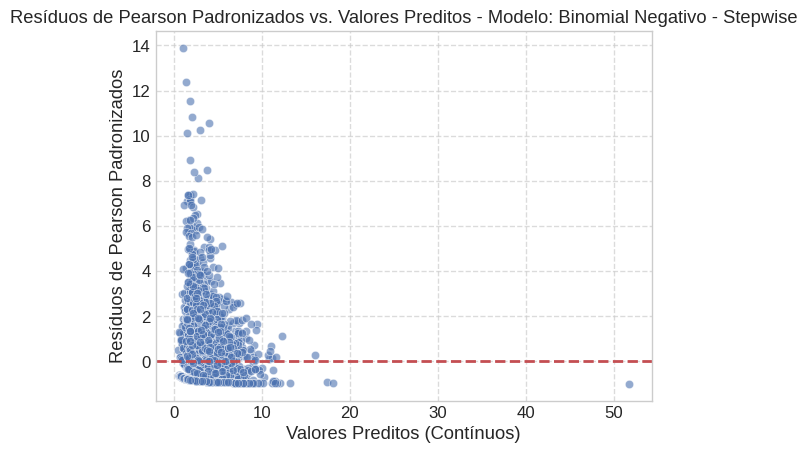

In [68]:
overdisp_plot(modelo_binomial_stepwise, 'Binomial Negativo - Stepwise')

In [69]:
diagnosticar_dispersao_ct(modelo_binomial_stepwise, y)

--- Diagnóstico de Dispersão (Teste de Cameron & Trivedi) ---
P-valor do teste: 0.0000
Resultado (α = 0.05): Hipótese nula rejeitada.
Conclusão: Há evidência de má especificação da dispersão (ex: sobredispersão não capturada).
-------------------------------------------------------------


{'estatistica_t': np.float64(35.891378755370134),
 'p_valor': np.float64(3.755643786405286e-244)}

O modelo stepwise apresenta o mesmo comportamento em relação ao modelo completo.

### Modelo Zero-Inflated Poisson (ZIP)  

Modelagem de Dados de Contagem com Excesso de Zeros

O **Modelo Zero-Inflated Poisson (ZIP)** é uma extensão do modelo de regressão de Poisson, utilizado quando os dados de contagem apresentam uma **frequência excessiva de zeros**, superior àquela esperada pela distribuição de Poisson. Esse tipo de modelo permite separar o processo gerador de zeros do processo de contagem positivo, proporcionando uma abordagem mais flexível para lidar com esse tipo de estrutura nos dados.

---

### Estrutura do ZIP

O modelo ZIP assume que os dados são gerados por **dois processos distintos**:

1. Um processo binário (discreto), que determina se a observação pertence à **parte estrutural de zeros** (com probabilidade $\pi_i$);
2. Um processo de contagem, que segue uma **distribuição de Poisson** com parâmetro $\lambda_i$, para as observações que **não pertencem** à parte estrutural de zeros (com probabilidade $1 - \pi_i$).

A distribuição de probabilidade para $Y_i$ no modelo ZIP é definida como:

$$
P(Y_i = 0) = \pi_i + (1 - \pi_i) \cdot e^{-\lambda_i}
$$

$$
P(Y_i = k) = (1 - \pi_i) \cdot \frac{\lambda_i^k e^{-\lambda_i}}{k!}, \quad \text{para } k = 1, 2, 3, \dots
$$

---

### Componentes do Modelo

O ZIP envolve duas submodelagens:

#### 1. Modelo para contagem (Poisson)

A média esperada da parte de contagem é modelada com função de ligação logarítmica:

$$
\log(\lambda_i) = \beta_0 + \beta_1 x_{i1} + \dots + \beta_p x_{ip}
$$

ou

$$
\lambda_i = \exp(x_i^\top \beta)
$$

#### 2. Modelo logístico para inflação de zeros

A probabilidade $\pi_i$ de uma observação pertencer à parte inflacionada de zeros é modelada via regressão logística:

$$
\text{logit}(\pi_i) = \gamma_0 + \gamma_1 z_{i1} + \dots + \gamma_q z_{iq}
$$

ou

$$
\pi_i = \frac{\exp(z_i^\top \gamma)}{1 + \exp(z_i^\top \gamma)}
$$

onde:

- $x_i$ é o vetor de preditores da parte Poisson (contagem);
- $z_i$ é o vetor de preditores da parte binária (zero inflacionado), que pode coincidir ou não com $x_i$;
- $\beta$ e $\gamma$ são os vetores de coeficientes de cada parte do modelo.

---

### Interpretação dos Coeficientes

#### Parte de contagem (Poisson):

Os coeficientes $\beta_j$ representam o **efeito logarítmico** sobre a taxa de contagem, tal como na regressão de Poisson. A razão de taxas é dada por:

$$
e^{\beta_j}
$$

e indica o multiplicador da média esperada de eventos para uma unidade adicional em $x_{ij}$.

#### Parte de inflação de zeros (logística):

Os coeficientes $\gamma_j$ representam o **efeito log-odds** sobre a probabilidade de que a observação pertença à parte estrutural de zeros. A exponenciação dos coeficientes fornece a **razão de chances** associada a cada preditor $z_{ij}$.

---

### Estimação

A estimação dos parâmetros é feita por **máxima verossimilhança**, utilizando uma função composta que combina as verossimilhanças das partes Poisson e logística. O processo é iterativo e requer inicialização adequada dos parâmetros.

---

### Utilização

O modelo ZIP é adequado para situações em que:

- A variável de contagem apresenta um **excesso de zeros** não compatível com a distribuição de Poisson;
- Há **dois mecanismos distintos** para geração de zeros: um processo estrutural e outro aleatório (via Poisson);
- Deseja-se identificar **fatores associados à presença estrutural de zeros**, além da contagem em si.

---

### Considerações

- A escolha entre o modelo de Poisson, Binomial Negativa e ZIP deve ser guiada por testes de sobredispersão e verificação do excesso de zeros nos dados.
- O modelo ZIP permite maior flexibilidade e interpretação, porém requer cuidado na separação adequada dos preditores entre as duas partes do modelo.

#### Validação de presuposto

Os dados devem apresentar **equidispersão**, ou seja, média igual a variância.

In [70]:
pd.DataFrame({'Média':[y.mean()],'Variância':[y.var()]})

Média  Variância
0  3.277693  28.024475

Existe uma diferença muito grande entre a média e a variancia referente a variável alvo, indicando possível subdispersão nos dados.

##### Completo

In [71]:
X1 = X.drop(columns=['frauds']).copy()
X1 = sm.add_constant(X1)

In [78]:
modelo_zip = sm.ZeroInflatedPoisson(y, X1, exog_infl=X1).fit(disp=False, method='lbfgs', cov_type='HC2')
modelo_zip.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedPoisson Regression Results                    
===============================================================================
Dep. Variable:                  frauds   No. Observations:                 3918
Model:             ZeroInflatedPoisson   Df Residuals:                     3899
Method:                            MLE   Df Model:                           18
Date:                 Wed, 20 Aug 2025   Pseudo R-squ.:                  -483.1
Time:                         01:39:50   Log-Likelihood:            -4.5831e+06
converged:                        True   LL-Null:                       -9466.4
Covariance Type:                   HC2   LLR p-value:                     1.000
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
inflate_const                  0.1000    4.1e+23   2.44e-25      1.000   -8.04e+23    8.04e+23
inflate_total_transactions     0.1000      6e+27   1.67e-29      1.000   -1.18e+28    1.18e+28
inflate_total_amount           0.1000   4.64e+15   2.15e-17      1.000    -9.1e+15     9.1e+15
inflate_chip_ratio             0.1000   7.55e+16   1.33e-18      1.000   -1.48e+17    1.48e+17
inflate_txn_velocity           0.1000   2.67e+31   3.74e-33      1.000   -5.24e+31    5.24e+31
inflate_avg_txn_value          0.1000   1.05e+19   9.54e-21      1.000   -2.05e+19    2.05e+19
inflate_geo_dispersion         0.1000   8.66e+17   1.16e-19      1.000    -1.7e+18     1.7e+18
inflate_merchant_entropy       0.1000   1.99e+17   5.02e-19      1.000   -3.91e+17    3.91e+17
inflate_avg_credit_score       0.1000   3.71e+18    2.7e-20      1.000   -7.27e+18    7.27e+18
inflate_error_ratio            0.1000   8.37e+19   1.19e-21      1.000   -1.64e+20    1.64e+20
inflate_hour_of_day            0.1000   7.41e+16   1.35e-18      1.000   -1.45e+17    1.45e+17
inflate_day_of_week            0.1000   3.12e+16   3.21e-18      1.000   -6.11e+16    6.11e+16
inflate_is_weekend             0.1000   4.43e+17   2.26e-19      1.000   -8.68e+17    8.68e+17
inflate_is_holiday             0.1000      1e+17   9.95e-19      1.000   -1.97e+17    1.97e+17
inflate_txn_volume_change      0.1000   9.48e+15   1.05e-17      1.000   -1.86e+16    1.86e+16
inflate_avg_value_change       0.1000   3.01e+17   3.32e-19      1.000   -5.91e+17    5.91e+17
inflate_velocity_alert         0.1000   2.03e+17   4.92e-19      1.000   -3.99e+17    3.99e+17
inflate_unique_clients         0.1000   1.19e+18   8.37e-20      1.000   -2.34e+18    2.34e+18
inflate_unique_cards           0.1000   8.97e+17   1.11e-19      1.000   -1.76e+18    1.76e+18
inflate_cards_per_client       0.1000   7.14e+20    1.4e-22      1.000    -1.4e+21     1.4e+21
const                          1.1736   7.29e+57   1.61e-58      1.000   -1.43e+58    1.43e+58
total_transactions             0.0009   7.24e+54   1.26e-58      1.000   -1.42e+55    1.42e+55
total_amount                  -0.0032   6.14e+52  -5.26e-56      1.000    -1.2e+53     1.2e+53
chip_ratio                     0.0010   6.14e+58   1.63e-62      1.000    -1.2e+59     1.2e+59
txn_velocity                   0.0011   2.72e+58   4.05e-62      1.000   -5.33e+58    5.33e+58
avg_txn_value                  0.0010   1.91e+55    5.2e-59      1.000   -3.75e+55    3.75e+55
geo_dispersion                 0.0010   2.96e+56   3.37e-60      1.000    -5.8e+56     5.8e+56
merchant_entropy               0.0010   7.21e+56   1.39e-60      1.000   -1.41e+57    1.41e+57
avg_credit_score               0.0010   7.38e+54   1.32e-58      1.000   -1.45e+55    1.45e+55
error_ratio                    0.0010   8.69e+58   1.17e-62      1.000    -1.7e+59     1.7e+59
hour_of_day                    0.0010   8.48e+56   1.19e-60      1.000   -1.66e+57    1.66e+57
da

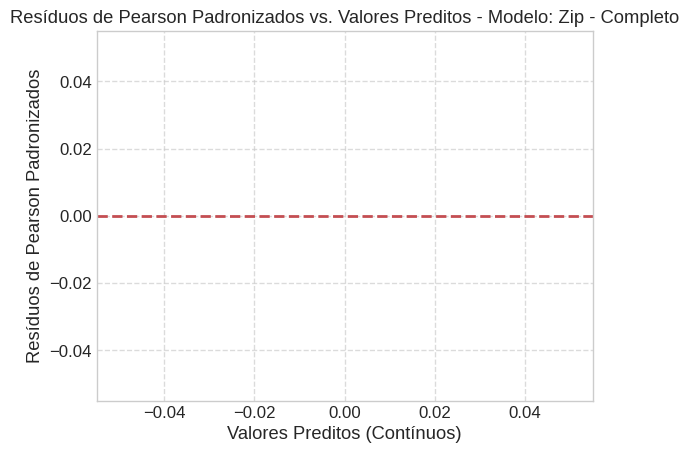

In [79]:
overdisp_plot(modelo_zip, 'Zip - Completo')

In [80]:
diagnosticar_dispersao_ct(modelo_zip, y)

--- Diagnóstico de Dispersão (Teste de Cameron & Trivedi) ---
P-valor do teste: nan
Resultado (α = 0.05): Falha em rejeitar a hipótese nula.
Conclusão: O pressuposto de dispersão do modelo é considerado adequado.
-------------------------------------------------------------


{'estatistica_t': np.float64(nan), 'p_valor': np.float64(nan)}

Igual ao modelo Poisson, o modelo ZIP apresenta problemas de sobredispersão, quando a média é menor que a variância. O modelo tem diculdades para modelar os componentes de contagem e zeros estruturais uma vez que o presuposto do modelo Poisson não foi atendido e todos as features foram incluídas em ambos componentes.

In [81]:
vuong_test(modelo_poisson, modelo_zip)

         Current function value: 86432830101429065206923854450820899558916096.000000
         Iterations: 35
Vuong Non-Nested Hypothesis Test-Statistic (Raw):
Vuong z-statistic: nan
p-value: nan

==================Result======================== 

H0: Indicates no inflation of zeros at 95% confidence level


Conforme teste de Vuong, é possível confirmar que os dados estão com inflação de zeros, sendo assim, o modelo ZIP acaba sendo indicado para esse problema em questão da inflação de zeros.

##### Stepwise

In [82]:
X1 = X.drop(columns=['frauds']).copy()

In [108]:
step_wise = SimpleStepwiseZeroInflated(
    alpha=0.05,
    model_type='ZIP',
    selection_criterion='LLF',
    cov_type='HC2',
    verbose=False,
    method='lbfgs',
    convergence_strictness='low',
    shuffle_features=True,
    shuffle_random_state=45
)
random_selector_zip = RandomFeatureSelector(step_wise, max_features=0.75, random_state=45)
random_selector_zip.fit(X1, y)

Stepwise Selection:   0%|          | 0/50 [00:00<?]

  Testing features:   0%|          | 0/15 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/10 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/9 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/8 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/7 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/1 [00:00<?, ?it/s]

Stepwise Selection:   0%|          | 0/50 [00:00<?]

  Testing features:   0%|          | 0/15 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/9 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/8 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/7 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/4 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/3 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/1 [00:00<?, ?it/s]

Stepwise Selection:   0%|          | 0/50 [00:00<?]

  Testing features:   0%|          | 0/15 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/8 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/7 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/6 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/1 [00:00<?, ?it/s]

Stepwise Selection:   0%|          | 0/50 [00:00<?]

  Testing features:   0%|          | 0/15 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/11 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/10 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/9 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/5 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/4 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/3 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/2 [00:00<?, ?it/s]

Stepwise Selection:   0%|          | 0/50 [00:00<?]

  Testing features:   0%|          | 0/15 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/9 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/7 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/6 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/3 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/1 [00:00<?, ?it/s]

Stepwise Selection:   0%|          | 0/50 [00:00<?]

  Testing features:   0%|          | 0/15 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/9 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/8 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/7 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/3 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/1 [00:00<?, ?it/s]

Stepwise Selection:   0%|          | 0/50 [00:00<?]

  Testing features:   0%|          | 0/15 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/10 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/8 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/7 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/5 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/4 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/3 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/2 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/1 [00:00<?, ?it/s]

Stepwise Selection:   0%|          | 0/50 [00:00<?]

  Testing features:   0%|          | 0/15 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/10 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/8 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/7 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/4 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/3 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/2 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/1 [00:00<?, ?it/s]

Stepwise Selection:   0%|          | 0/50 [00:00<?]

  Testing features:   0%|          | 0/15 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/10 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/9 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/8 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/5 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/4 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/3 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/2 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/1 [00:00<?, ?it/s]

Stepwise Selection:   0%|          | 0/50 [00:00<?]

  Testing features:   0%|          | 0/15 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/9 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/7 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/6 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/5 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/4 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/3 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/2 [00:00<?, ?it/s]

RandomFeatureSelector(estimator=SimpleStepwiseZeroInflated(convergence_strictness='low',
                                                           selection_criterion='LLF',
                                                           verbose=False),
                      max_features=0.75, random_state=45)

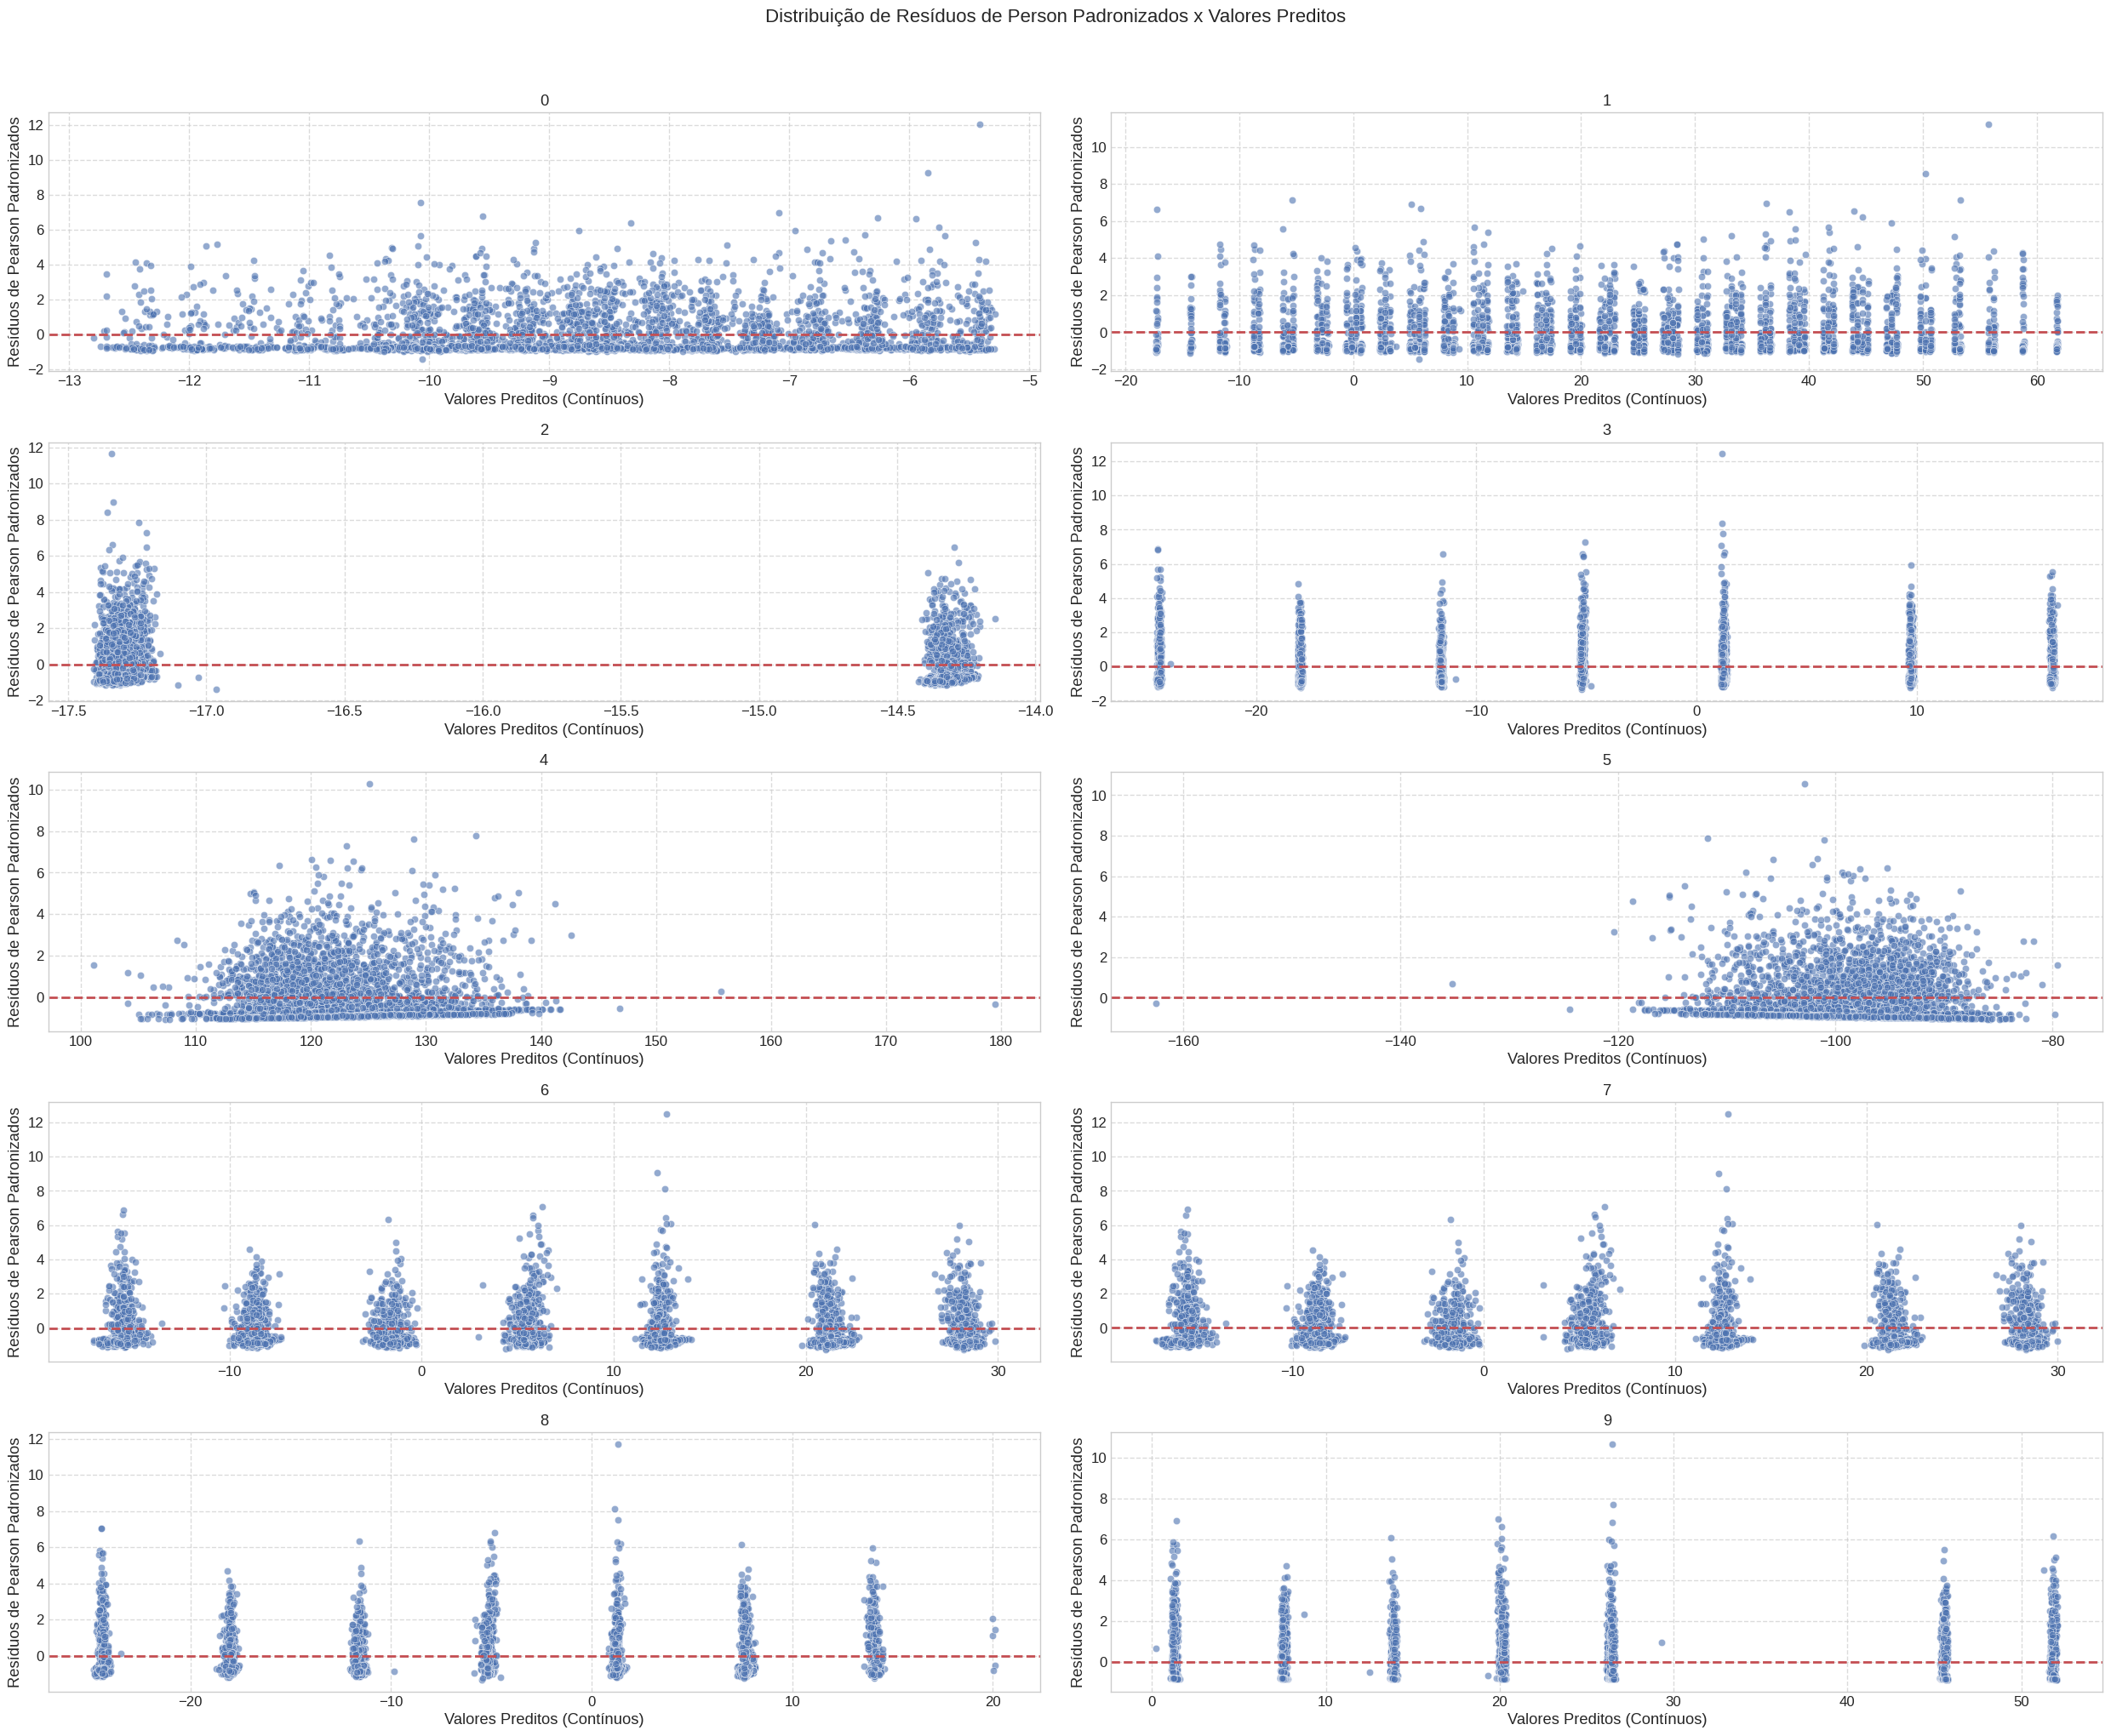

In [109]:
plt.figure(figsize=(25, 20))

# Define o título com uma posição mais alta usando y
plt.suptitle('Distribuição de Resíduos de Person Padronizados x Valores Preditos', fontsize=16, y=1.02)

# Ajusta espaço entre os subplots e o título
plt.subplots_adjust(top=0.92)

for i, model in enumerate(map(lambda x: x.final_model_, random_selector_zip.models)):
    plt.subplot(5, 2, i + 1)
    overdisp_plot(model, str(i), "{}")

plt.tight_layout()
plt.show()

In [151]:
df_trained_zip = pd.DataFrame(list(map(lambda x: dict(iter=x['iter'], llf=x['model'].llf, bic=x['model'].bic, aic=x['model'].aic, params=len(x['model'].params)),
        filter(lambda x: x['model'].converged,
        map(lambda x: dict(iter=x[0], model=x[1].final_model_), enumerate(random_selector_zip.models))))))
df_trained_zip = df_trained_zip.sort_values(by=['bic'], ascending=True).reset_index(drop=True)
df_trained_zip

iter          llf           bic           aic  params
0     8 -9047.506277  18194.292593  18119.012554      12
1     7 -9047.989910  18195.259859  18119.979820      12
2     3 -9053.396146  18197.798995  18128.792292      11
3     6 -9045.859731  18199.272839  18117.719463      13
4     4 -9086.733700  18247.927430  18191.467400       9
5     5 -9093.461550  18261.383130  18204.923101       9
6     9 -9126.378285  18327.216599  18270.756570       9
7     1 -9181.776817  18438.013663  18381.553634       9
8     2 -9212.331385  18482.576125  18438.662769       7
9     0 -9228.003507  18522.193707  18472.007014       8

In [152]:
best_model_index_zip = df_trained_zip.loc[0, 'iter']
best_model_index_zip

np.int64(8)

In [153]:
modelo_zip_stepwise = random_selector_zip.models[best_model_index_zip].final_model_
modelo_zip_stepwise.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedPoisson Regression Results                    
===============================================================================
Dep. Variable:                       y   No. Observations:                 3918
Model:             ZeroInflatedPoisson   Df Residuals:                     3911
Method:                            MLE   Df Model:                            6
Date:                 Wed, 20 Aug 2025   Pseudo R-squ.:                 0.04425
Time:                         02:03:42   Log-Likelihood:                -9047.5
converged:                        True   LL-Null:                       -9466.4
Covariance Type:             nonrobust   LLR p-value:                1.066e-177
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
inflate_const              -23.8369      3.186     -7.481      0.000     -30.082     -17.592
inflate_chip_ratio          -1.1737      0.108    -10.913      0.000      -1.384      -0.963
inflate_cards_per_client     6.4175      0.880      7.289      0.000       4.692       8.143
inflate_avg_txn_value        0.0625      0.013      4.654      0.000       0.036       0.089
inflate_merchant_entropy     2.1182      0.575      3.684      0.000       0.991       3.245
const                        1.6777      0.396      4.232      0.000       0.901       2.455
txn_velocity                 6.0802      0.400     15.188      0.000       5.296       6.865
day_of_week                  0.0498      0.005     11.057      0.000       0.041       0.059
cards_per_client            -2.4986      0.398     -6.281      0.000      -3.278      -1.719
error_ratio                 12.5130      3.298      3.795      0.000       6.050      18.976
avg_value_change             0.2844      0.126      2.253      0.024       0.037       0.532
velocity_alert               0.1927      0.089      2.170      0.030       0.019       0.367
============================================================================================
"""

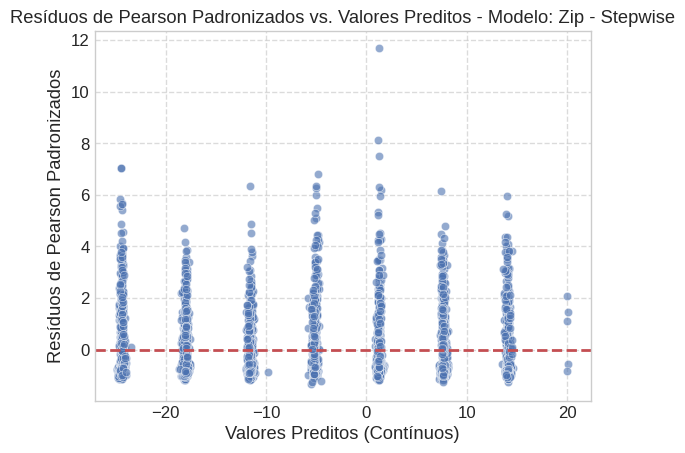

In [154]:
overdisp_plot(modelo_zip_stepwise, 'Zip - Stepwise')

In [155]:
diagnosticar_dispersao_ct(modelo_zip_stepwise, y)

--- Diagnóstico de Dispersão (Teste de Cameron & Trivedi) ---
P-valor do teste: 0.0000
Resultado (α = 0.05): Hipótese nula rejeitada.
Conclusão: Há evidência de má especificação da dispersão (ex: sobredispersão não capturada).
-------------------------------------------------------------


{'estatistica_t': np.float64(5.8633002183304175),
 'p_valor': np.float64(4.91220079274006e-09)}

In [156]:
vuong_test(modelo_poisson_stepwise, modelo_zip_stepwise)

         Current function value: 7363867086559577896704694750374130731712512.000000
         Iterations: 35
Vuong Non-Nested Hypothesis Test-Statistic (Raw):
Vuong z-statistic: nan
p-value: nan

==================Result======================== 

H0: Indicates no inflation of zeros at 95% confidence level


O modelo apresentou uma melhora significativa em relação ao modelo zip completo uma vez que agora os residuos estão bem mais espelhados em torno da linha vermelha (y=0). No entanto ainda é perceptivo uma dispersão maior ao longo que os valores preditos aumentam, indicando ainda sobredispersão.

Conforme teste de Vuong, é possível confirmar que os dados estão com inflação de zeros, sendo assim, o modelo ZIP acaba sendo indicado para esse problema em questão da inflação de zeros.

### Modelo Zero-Inflated Negative Binomial (ZINB)  
Modelagem de Contagem com Sobredispersão e Excesso de Zeros

O **Modelo Zero-Inflated Negative Binomial (ZINB)** é uma extensão do modelo Zero-Inflated Poisson (ZIP), indicado quando os dados de contagem apresentam simultaneamente:

- Um **excesso de zeros** não compatível com a distribuição de Poisson ou Binomial Negativa;
- Uma **sobredispersão** (variância maior que a média) nas contagens positivas.

Esse modelo permite que a variável resposta $Y_i$ seja gerada por dois processos distintos:

1. Um processo binário que determina a ocorrência de **zeros estruturais** com probabilidade $\pi_i$;
2. Um processo de **contagem sob a distribuição Binomial Negativa** com média $\mu_i$ e parâmetro de dispersão $\theta$, para as demais observações.

---

### Estrutura do Modelo

A função de probabilidade do modelo ZINB é definida da seguinte forma:

$$
P(Y_i = 0) = \pi_i + (1 - \pi_i) \cdot \left( \frac{\theta}{\mu_i + \theta} \right)^{\theta}
$$

$$
P(Y_i = k) = (1 - \pi_i) \cdot \binom{k + \theta - 1}{k} \cdot \left( \frac{\mu_i}{\mu_i + \theta} \right)^k \cdot \left( \frac{\theta}{\mu_i + \theta} \right)^{\theta}, \quad \text{para } k = 1, 2, 3, \dots
$$

onde:

- $\mu_i > 0$ é a média condicional do componente Binomial Negativo;
- $\theta > 0$ é o parâmetro de dispersão;
- $\pi_i$ é a probabilidade de a observação pertencer à **parte inflacionada de zeros**.

---

### Componentes do Modelo

O modelo é composto por duas partes principais:

#### 1. Parte de contagem (Binomial Negativa)

A média da distribuição é modelada com função de ligação logarítmica:

$$
\log(\mu_i) = \beta_0 + \beta_1 x_{i1} + \dots + \beta_p x_{ip}
$$

ou

$$
\mu_i = \exp(x_i^\top \beta)
$$

#### 2. Parte de inflação de zeros (Logística)

A probabilidade $\pi_i$ é modelada com uma função logística:

$$
\text{logit}(\pi_i) = \gamma_0 + \gamma_1 z_{i1} + \dots + \gamma_q z_{iq}
$$

ou

$$
\pi_i = \frac{\exp(z_i^\top \gamma)}{1 + \exp(z_i^\top \gamma)}
$$

---

### Variância

A variância condicional da parte de contagem segue a distribuição Binomial Negativa:

$$
\mathrm{Var}(Y_i \mid Y_i > 0) = \mu_i + \frac{\mu_i^2}{\theta}
$$

O termo adicional $\frac{\mu_i^2}{\theta}$ permite capturar sobredispersão, ajustando o modelo para casos em que a variabilidade excede a esperada por uma Poisson.

---

### Interpretação dos Coeficientes

#### Parte de Contagem (Binomial Negativa)

- Os coeficientes $\beta_j$ são interpretados como efeitos logarítmicos sobre a média $\mu_i$.
- A razão de taxas $e^{\beta_j}$ indica o **fator multiplicativo** sobre a contagem média de eventos para uma variação unitária em $x_{ij}$.

#### Parte de Zeros (Logística)

- Os coeficientes $\gamma_j$ representam o efeito **log-odds** sobre a probabilidade de a observação pertencer ao componente de zeros estruturais.
- O termo $e^{\gamma_j}$ fornece a **razão de chances** associada a cada preditor $z_{ij}$.

---

### Estimação

A estimação dos parâmetros $\beta$, $\gamma$ e $\theta$ é feita por **máxima verossimilhança**, com otimização conjunta das duas partes do modelo. A presença do parâmetro de dispersão $\theta$ requer métodos numéricos robustos para convergência adequada.

---

### Utilização

O modelo ZINB é apropriado quando:

- A variável resposta apresenta **muitos zeros** e **sobredispersão** simultaneamente;
- Há **dois mecanismos distintos** de geração de zeros: um estrutural (determinístico) e outro probabilístico (contagem);
- É necessário identificar fatores que influenciam tanto a **presença de zeros estruturais** quanto o **nível da contagem**.

---

### Considerações Finais

O modelo ZINB é uma alternativa robusta ao ZIP e à Binomial Negativa padrão. Ele oferece maior capacidade de ajuste e interpretação quando a estrutura dos dados de contagem é complexa, com variações acentuadas e presença de dois regimes distintos (zero e contagem positiva).


#### Validação de presuposto

Os dados devem apresentar **sobredispersão**, ou seja, variância é maior que a média.

In [123]:
pd.DataFrame({'Média':[y.mean()],'Variância':[y.var()]})

Média  Variância
0  3.277693  28.024475

##### Completo

In [124]:
X1 = X.drop(columns=['frauds']).copy(deep=True)
X1 = sm.add_constant(X1)

In [136]:
modelo_zinb = ZeroInflatedNegativeBinomialP(y, X1, exog_infl=X1).fit(disp=False)
modelo_zinb.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedNegativeBinomialP Regression Results                    
=========================================================================================
Dep. Variable:                            frauds   No. Observations:                 3918
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                     3899
Method:                                      MLE   Df Model:                           18
Date:                           Wed, 20 Aug 2025   Pseudo R-squ.:                     nan
Time:                                   01:57:54   Log-Likelihood:                    nan
converged:                                 False   LL-Null:                       -7814.1
Covariance Type:                       nonrobust   LLR p-value:                       nan
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
inflate_const                 -0.0007        nan        nan        nan         nan         nan
inflate_total_transactions    -1.4701        nan        nan        nan         nan         nan
inflate_total_amount         -71.2691        nan        nan        nan         nan         nan
inflate_chip_ratio            -0.0003        nan        nan        nan         nan         nan
inflate_txn_velocity          -0.0004        nan        nan        nan         nan         nan
inflate_avg_txn_value         -0.0325        nan        nan        nan         nan         nan
inflate_geo_dispersion        -0.0143        nan        nan        nan         nan         nan
inflate_merchant_entropy      -0.0037        nan        nan        nan         nan         nan
inflate_avg_credit_score      -0.4785        nan        nan        nan         nan         nan
inflate_error_ratio         -1.05e-05        nan        nan        nan         nan         nan
inflate_hour_of_day           -0.0081        nan        nan        nan         nan         nan
inflate_day_of_week           -0.0020        nan        nan        nan         nan         nan
inflate_is_weekend            -0.0002        nan        nan        nan         nan         nan
inflate_is_holiday          -1.64e-05        nan        nan        nan         nan         nan
inflate_txn_volume_change  -2.102e-05        nan        nan        nan         nan         nan
inflate_avg_value_change    1.682e-05        nan        nan        nan         nan         nan
inflate_velocity_alert     -4.981e-06        nan        nan        nan         nan         nan
inflate_unique_clients        -0.6318        nan        nan        nan         nan         nan
inflate_unique_cards          -0.9478        nan        nan        nan         nan         nan
inflate_cards_per_client      -0.0010        nan        nan        nan         nan         nan
const                        -36.2200        nan        nan        nan         nan         nan
total_transactions         -1213.5899        nan        nan        nan         nan         nan
total_amount                1031.4005        nan        nan        nan         nan         nan
chip_ratio                     0.0039        nan        nan        nan         nan         nan
txn_velocity                4.446e+06        nan        nan        nan         nan         nan
avg_txn_value                  0.4624        nan        nan        nan         nan         nan
geo_dispersion                 0.2054        nan        nan        nan         nan         nan
merchant_entropy               0.0547        nan        nan        nan         nan         nan
avg_credit_score               6.8379        nan        nan        nan         nan         nan
error_ratio                    0.0724        nan        nan        nan         nan         nan
hour_of

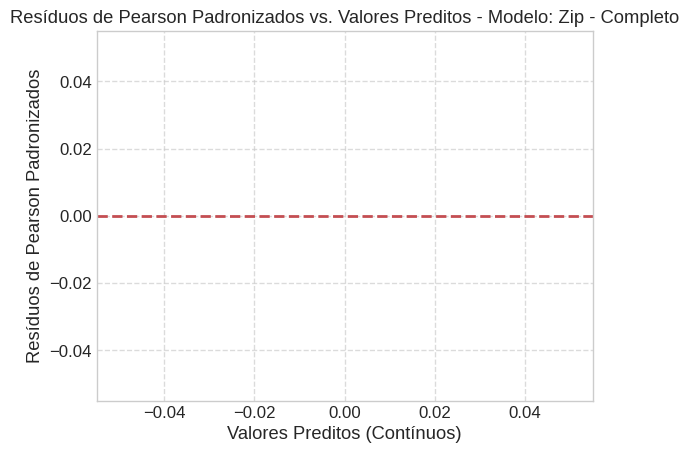

In [137]:
overdisp_plot(modelo_zinb, 'Zip - Completo')

In [138]:
diagnosticar_dispersao_ct(modelo_zinb, y)

Ocorreu um erro ao executar o teste: exog contains inf or nans


{'estatistica_t': nan, 'p_valor': nan}

O gráfico mostra que o modelo prevê quase sempre valores próximos de zero, mas quando ocorrem contagens positivas ele não consegue explicar bem, gerando erros muito grandes.
Isso significa que o modelo está superestimando zeros e subestimando casos com eventos reais.
Os resíduos deveriam se espalhar de forma equilibrada em torno de zero, mas aqui aparecem concentrados e com cauda longa para cima, sinal claro de mau ajuste.

In [139]:
vuong_test(modelo_binomial, modelo_zinb)

         Current function value: 77.021832
         Iterations: 0
         Function evaluations: 15
         Gradient evaluations: 14
Vuong Non-Nested Hypothesis Test-Statistic (Raw):
Vuong z-statistic: nan
p-value: nan

==================Result======================== 

H0: Indicates no inflation of zeros at 95% confidence level


##### Stepwise

In [140]:
X1 = X.drop(columns=['frauds']).copy()

In [141]:
step_wise = SimpleStepwiseZeroInflated(
    alpha=0.05,
    model_type='ZINB',
    selection_criterion='LLF',
    cov_type='HC1',
    verbose=False,
    method='lbfgs',
    convergence_strictness='low',
    shuffle_features=True,
    shuffle_random_state=40
)
random_selector_bneg = RandomFeatureSelector(step_wise, max_features=0.75, random_state=40)
random_selector_bneg.fit(X1, y)

Stepwise Selection:   0%|          | 0/50 [00:00<?]

  Testing features:   0%|          | 0/15 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/9 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/5 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/3 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/2 [00:00<?, ?it/s]

Stepwise Selection:   0%|          | 0/50 [00:00<?]

  Testing features:   0%|          | 0/15 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/7 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/4 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/2 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/1 [00:00<?, ?it/s]

Stepwise Selection:   0%|          | 0/50 [00:00<?]

  Testing features:   0%|          | 0/15 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/9 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/5 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/2 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/1 [00:00<?, ?it/s]

Stepwise Selection:   0%|          | 0/50 [00:00<?]

  Testing features:   0%|          | 0/15 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/8 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/4 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/1 [00:00<?, ?it/s]

Stepwise Selection:   0%|          | 0/50 [00:00<?]

  Testing features:   0%|          | 0/15 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/10 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/5 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/3 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/2 [00:00<?, ?it/s]

Stepwise Selection:   0%|          | 0/50 [00:00<?]

  Testing features:   0%|          | 0/15 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/10 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/5 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/2 [00:00<?, ?it/s]

Stepwise Selection:   0%|          | 0/50 [00:00<?]

  Testing features:   0%|          | 0/15 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/8 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/3 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/2 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/1 [00:00<?, ?it/s]

Stepwise Selection:   0%|          | 0/50 [00:00<?]

  Testing features:   0%|          | 0/15 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/9 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/4 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/2 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/1 [00:00<?, ?it/s]

Stepwise Selection:   0%|          | 0/50 [00:00<?]

  Testing features:   0%|          | 0/15 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/9 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/5 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/2 [00:00<?, ?it/s]

Stepwise Selection:   0%|          | 0/50 [00:00<?]

  Testing features:   0%|          | 0/15 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/7 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/4 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/1 [00:00<?, ?it/s]

RandomFeatureSelector(estimator=SimpleStepwiseZeroInflated(convergence_strictness='low',
                                                           model_type='ZINB',
                                                           selection_criterion='LLF',
                                                           verbose=False),
                      max_features=0.75, random_state=40)

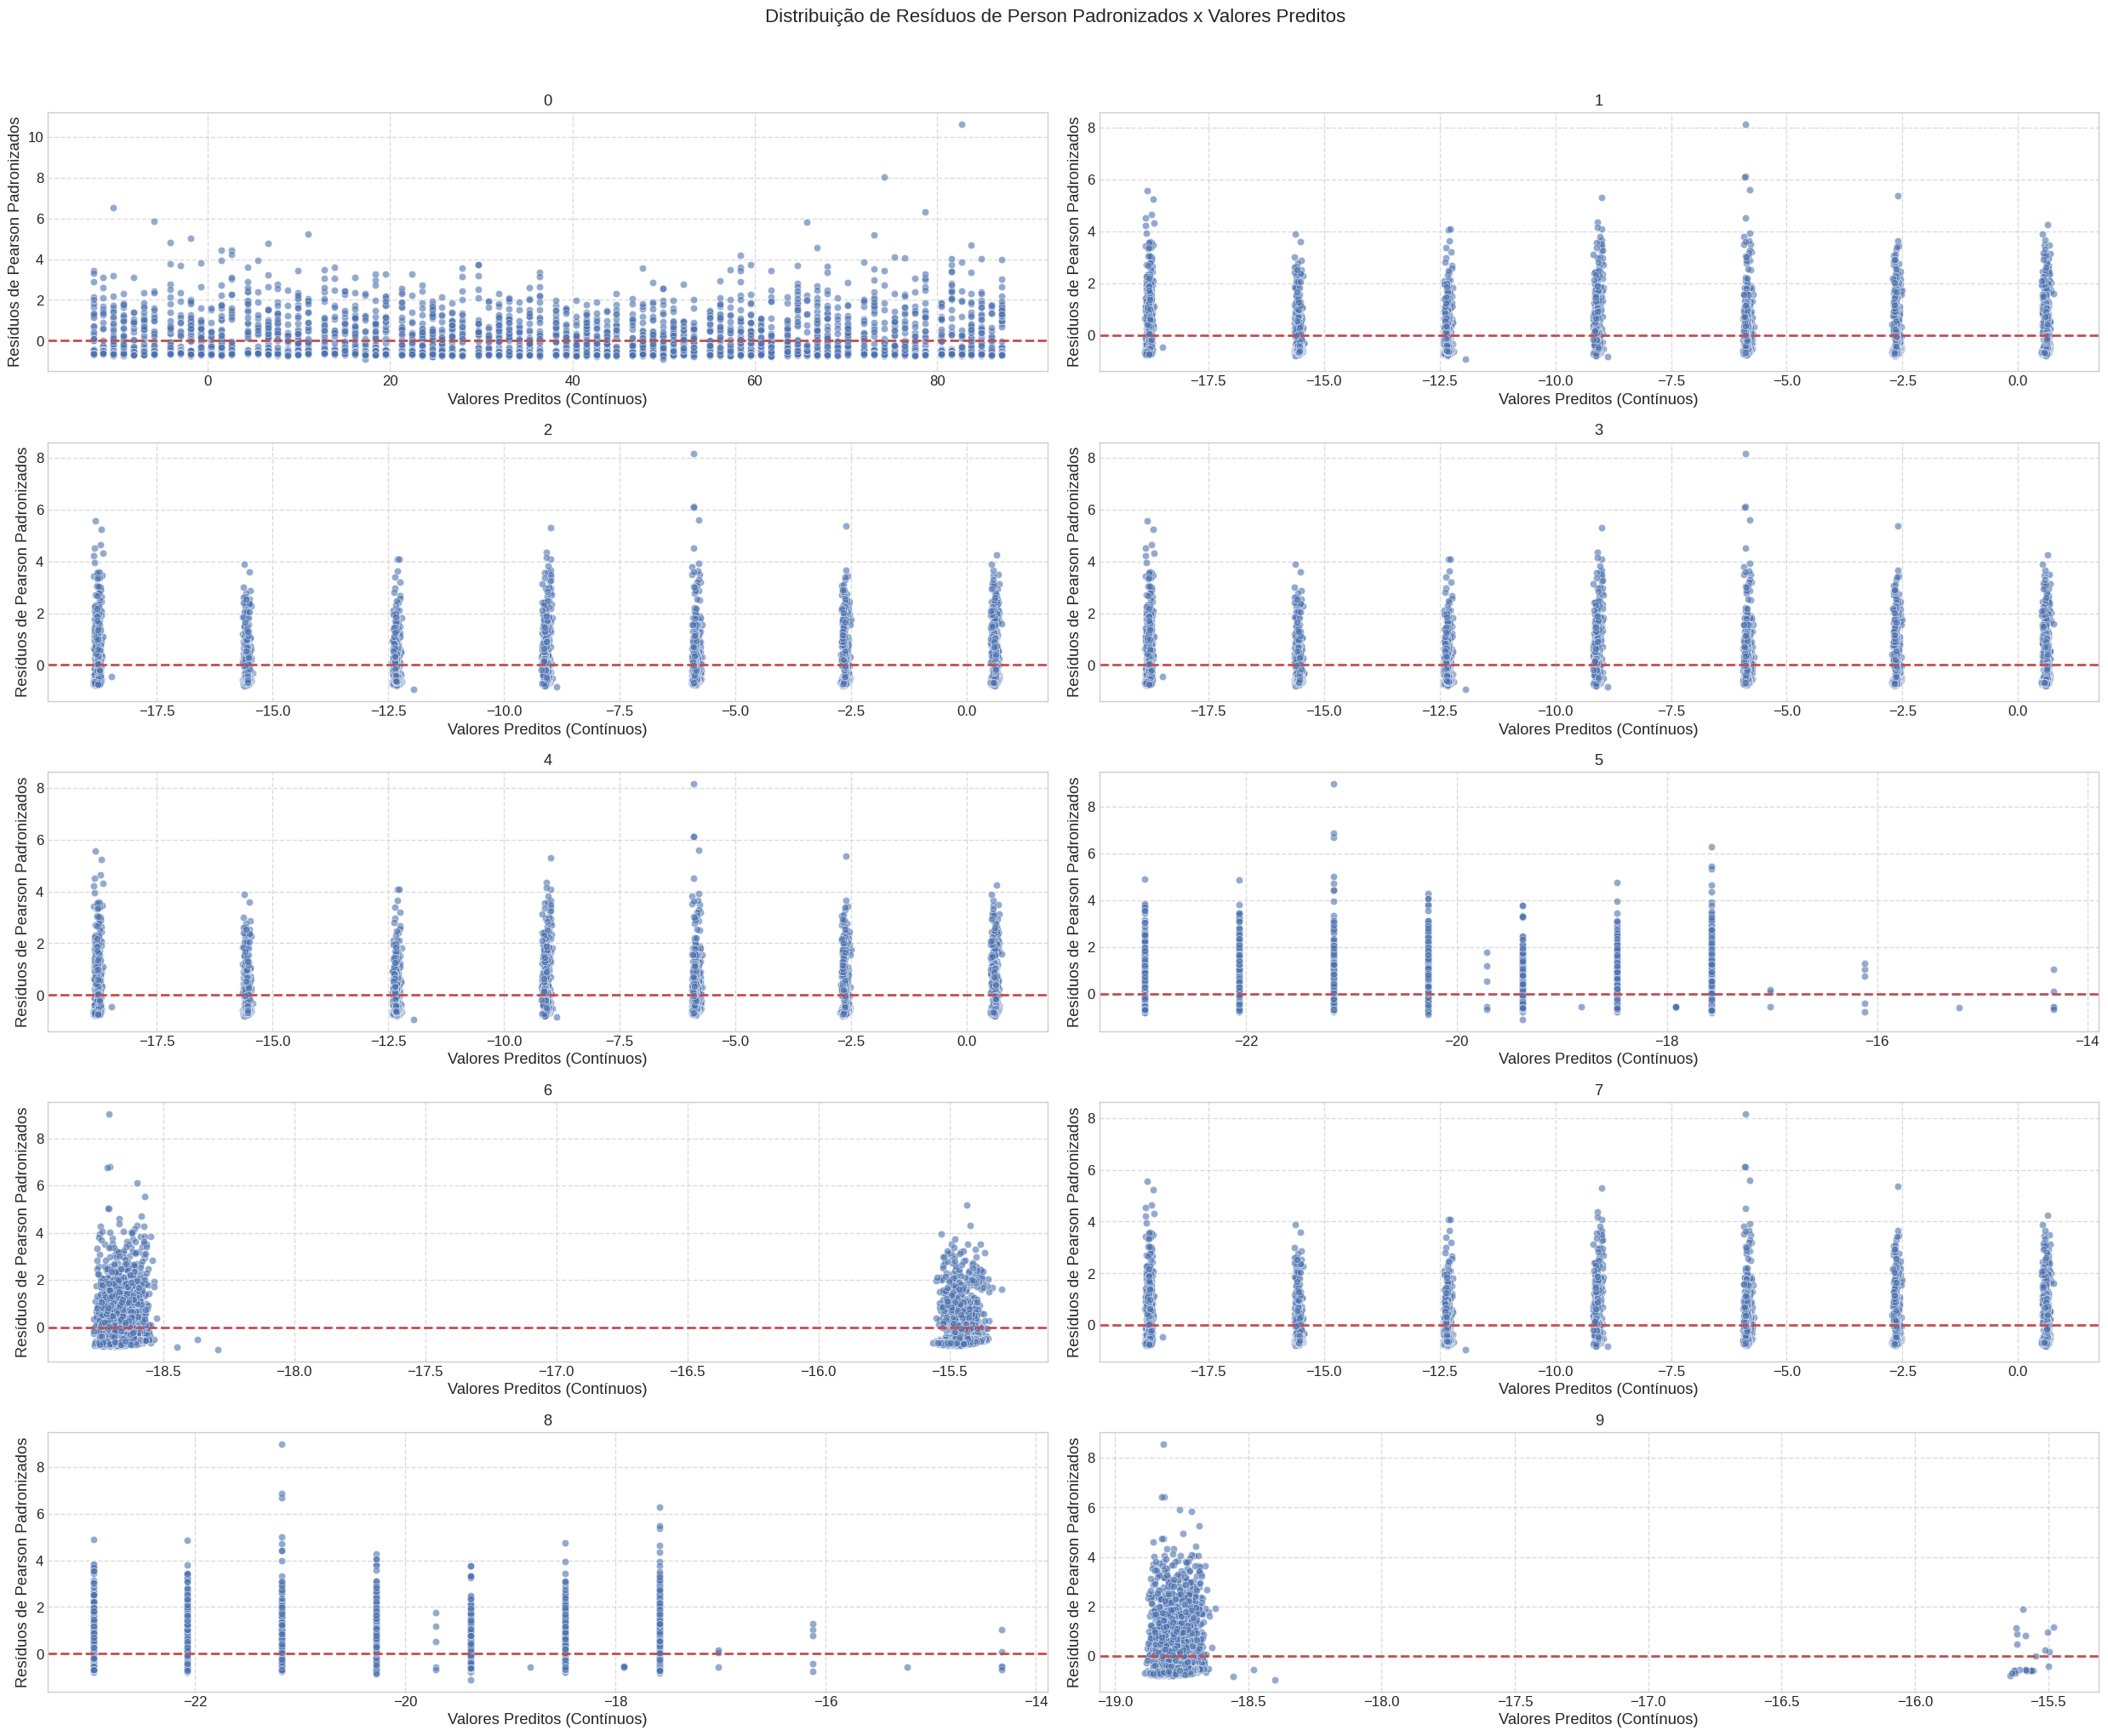

In [157]:
plt.figure(figsize=(25, 20))

# Define o título com uma posição mais alta usando y
plt.suptitle('Distribuição de Resíduos de Person Padronizados x Valores Preditos', fontsize=16, y=1.02)

# Ajusta espaço entre os subplots e o título
plt.subplots_adjust(top=0.92)

for i, model in enumerate(map(lambda x: x.final_model_, random_selector_bneg.models)):
    plt.subplot(5, 2, i + 1)
    overdisp_plot(model, str(i), "{}")

plt.tight_layout()
plt.show()

In [158]:
df_trained_zinb = pd.DataFrame(list(map(lambda x: dict(iter=x['iter'], llf=x['model'].llf, bic=x['model'].bic, aic=x['model'].aic, params=len(x['model'].params)),
        filter(lambda x: x['model'].converged,
        map(lambda x: dict(iter=x[0], model=x[1].final_model_), enumerate(random_selector_bneg.models))))))
df_trained_zinb = df_trained_zinb.sort_values(by=['bic'], ascending=True)
best_model_index_zinb = df_trained_zinb.loc[0, 'iter']
best_model_index_zinb

np.int64(0)

In [159]:
modelo_zinb_stepwise = random_selector_bneg.models[best_model_index_zinb].final_model_
modelo_zinb_stepwise.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedNegativeBinomialP Regression Results                    
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 3918
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                     3915
Method:                                      MLE   Df Model:                            2
Date:                           Wed, 20 Aug 2025   Pseudo R-squ.:                0.009087
Time:                                   02:04:23   Log-Likelihood:                -7743.1
converged:                                  True   LL-Null:                       -7814.1
Covariance Type:                       nonrobust   LLR p-value:                 1.452e-31
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
inflate_const               -5.8909      1.268     -4.647      0.000      -8.376      -3.406
inflate_chip_ratio          -1.1129      0.114     -9.741      0.000      -1.337      -0.889
inflate_cards_per_client     4.2268      0.849      4.979      0.000       2.563       5.891
inflate_hour_of_day         -0.0028      0.005     -0.535      0.592      -0.013       0.008
inflate_is_weekend           0.1564      0.077      2.024      0.043       0.005       0.308
const                        1.8608      0.052     35.929      0.000       1.759       1.962
day_of_week                  0.0524      0.011      4.960      0.000       0.032       0.073
hour_of_day                 -0.0104      0.003     -3.445      0.001      -0.016      -0.004
alpha                        0.6333      0.038     16.696      0.000       0.559       0.708
============================================================================================
"""

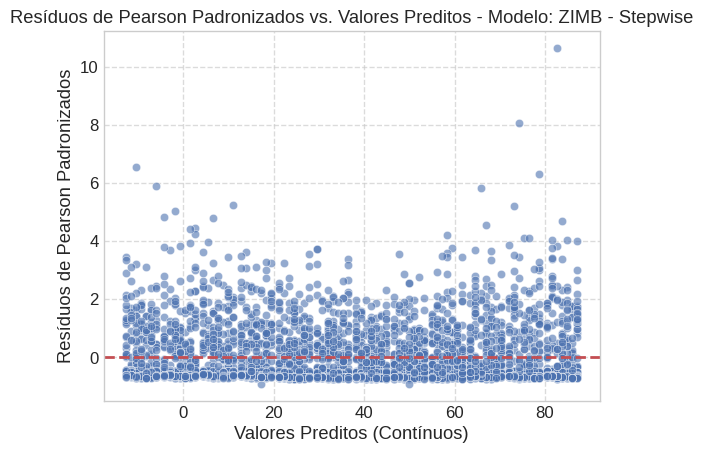

In [160]:
overdisp_plot(modelo_zinb_stepwise, 'ZIMB - Stepwise')

In [161]:
diagnosticar_dispersao_ct(modelo_zinb_stepwise, y)

--- Diagnóstico de Dispersão (Teste de Cameron & Trivedi) ---
P-valor do teste: 0.1831
Resultado (α = 0.05): Falha em rejeitar a hipótese nula.
Conclusão: O pressuposto de dispersão do modelo é considerado adequado.
-------------------------------------------------------------


{'estatistica_t': np.float64(1.331637369985674),
 'p_valor': np.float64(0.18305688330650702)}

O modelo stepwise apresenta previsões mais altas e consistentes, evitando o excesso de zeros visto no modelo anterior.
Os resíduos estão mais próximos de zero e com menor amplitude, sinal de um ajuste mais estável.
Ainda assim, surgem faixas verticais de pontos, indicando previsões pouco flexíveis e repetitivas.
Existem alguns resíduos acima de 5, mostrando que erros relevantes ainda ocorrem.

In [162]:
vuong_test(modelo_binomial_stepwise, modelo_zinb_stepwise)

         Current function value: 74.892739
         Iterations: 0
         Function evaluations: 15
         Gradient evaluations: 14
Vuong Non-Nested Hypothesis Test-Statistic (Raw):
Vuong z-statistic: -571.601
p-value: 0.000

==================Result======================== 

H1: Indicates inflation of zeros at 95% confidence level


### Comparação dos modelos com base em seu Log-Likelihood Function (LLF)

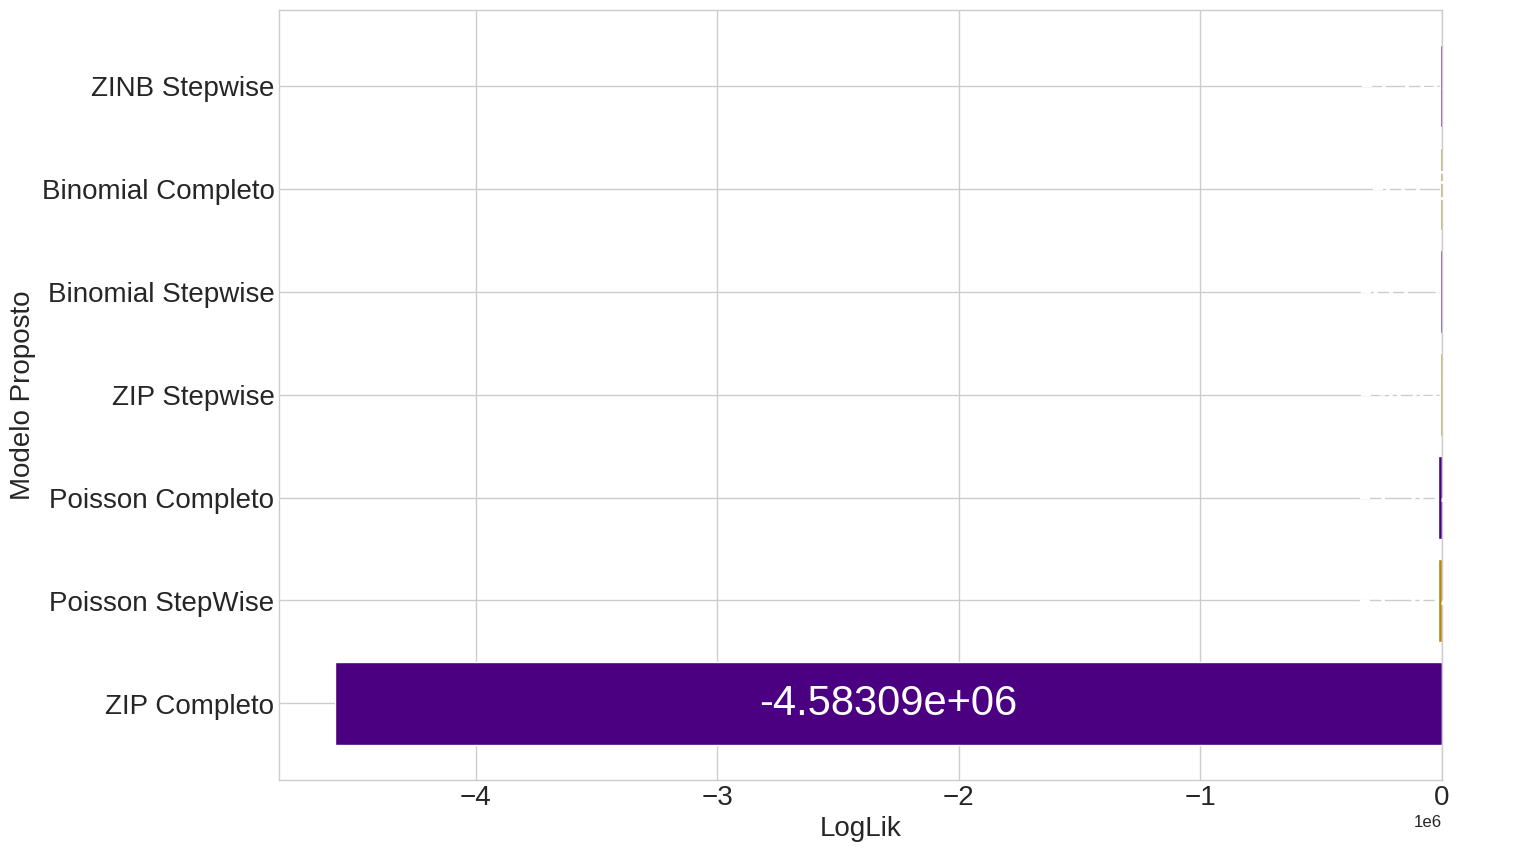

In [163]:
compare_models({
    'modelo':[
        'Poisson Completo',
        'Poisson StepWise',
        'Binomial Completo',
        'Binomial Stepwise',
        'ZIP Completo',
        'ZIP Stepwise',
        'ZINB Completo',
        'ZINB Stepwise'
    ],
    'loglik':[
        modelo_poisson.llf,
        modelo_poisson_stepwise.llf,
        modelo_binomial.llf,
        modelo_binomial_stepwise.llf,
        modelo_zip.llf,
        modelo_zip_stepwise.llf,
        modelo_zinb.llf,
        modelo_zinb_stepwise.llf
      ]
})

Analisando diretamente a métrica do LLF podemos ver claramente que o modelo ZINB obeteve um melhor resultado, sugerindo que esse possa ser o melho modelo, no entanto será necessário validar outros aspectos a fim de garantir que esse modelo realmente possa ser utilizado.

In [164]:
titles = [
    'Poisson Completo',
    'Poisson StepWise',
    'Binomial Completo',
    'Binomial Stepwise',
    'ZIP Completo',
    'ZIP Stepwise',
    'ZINB Completo',
    'ZINB Stepwise'
]
models = [
    modelo_poisson,
    modelo_poisson_stepwise,
    modelo_binomial,
    modelo_binomial_stepwise,
    modelo_zip,
    modelo_zip_stepwise,
    modelo_zinb,
    modelo_zinb_stepwise
]

### Dispersão dos residuos

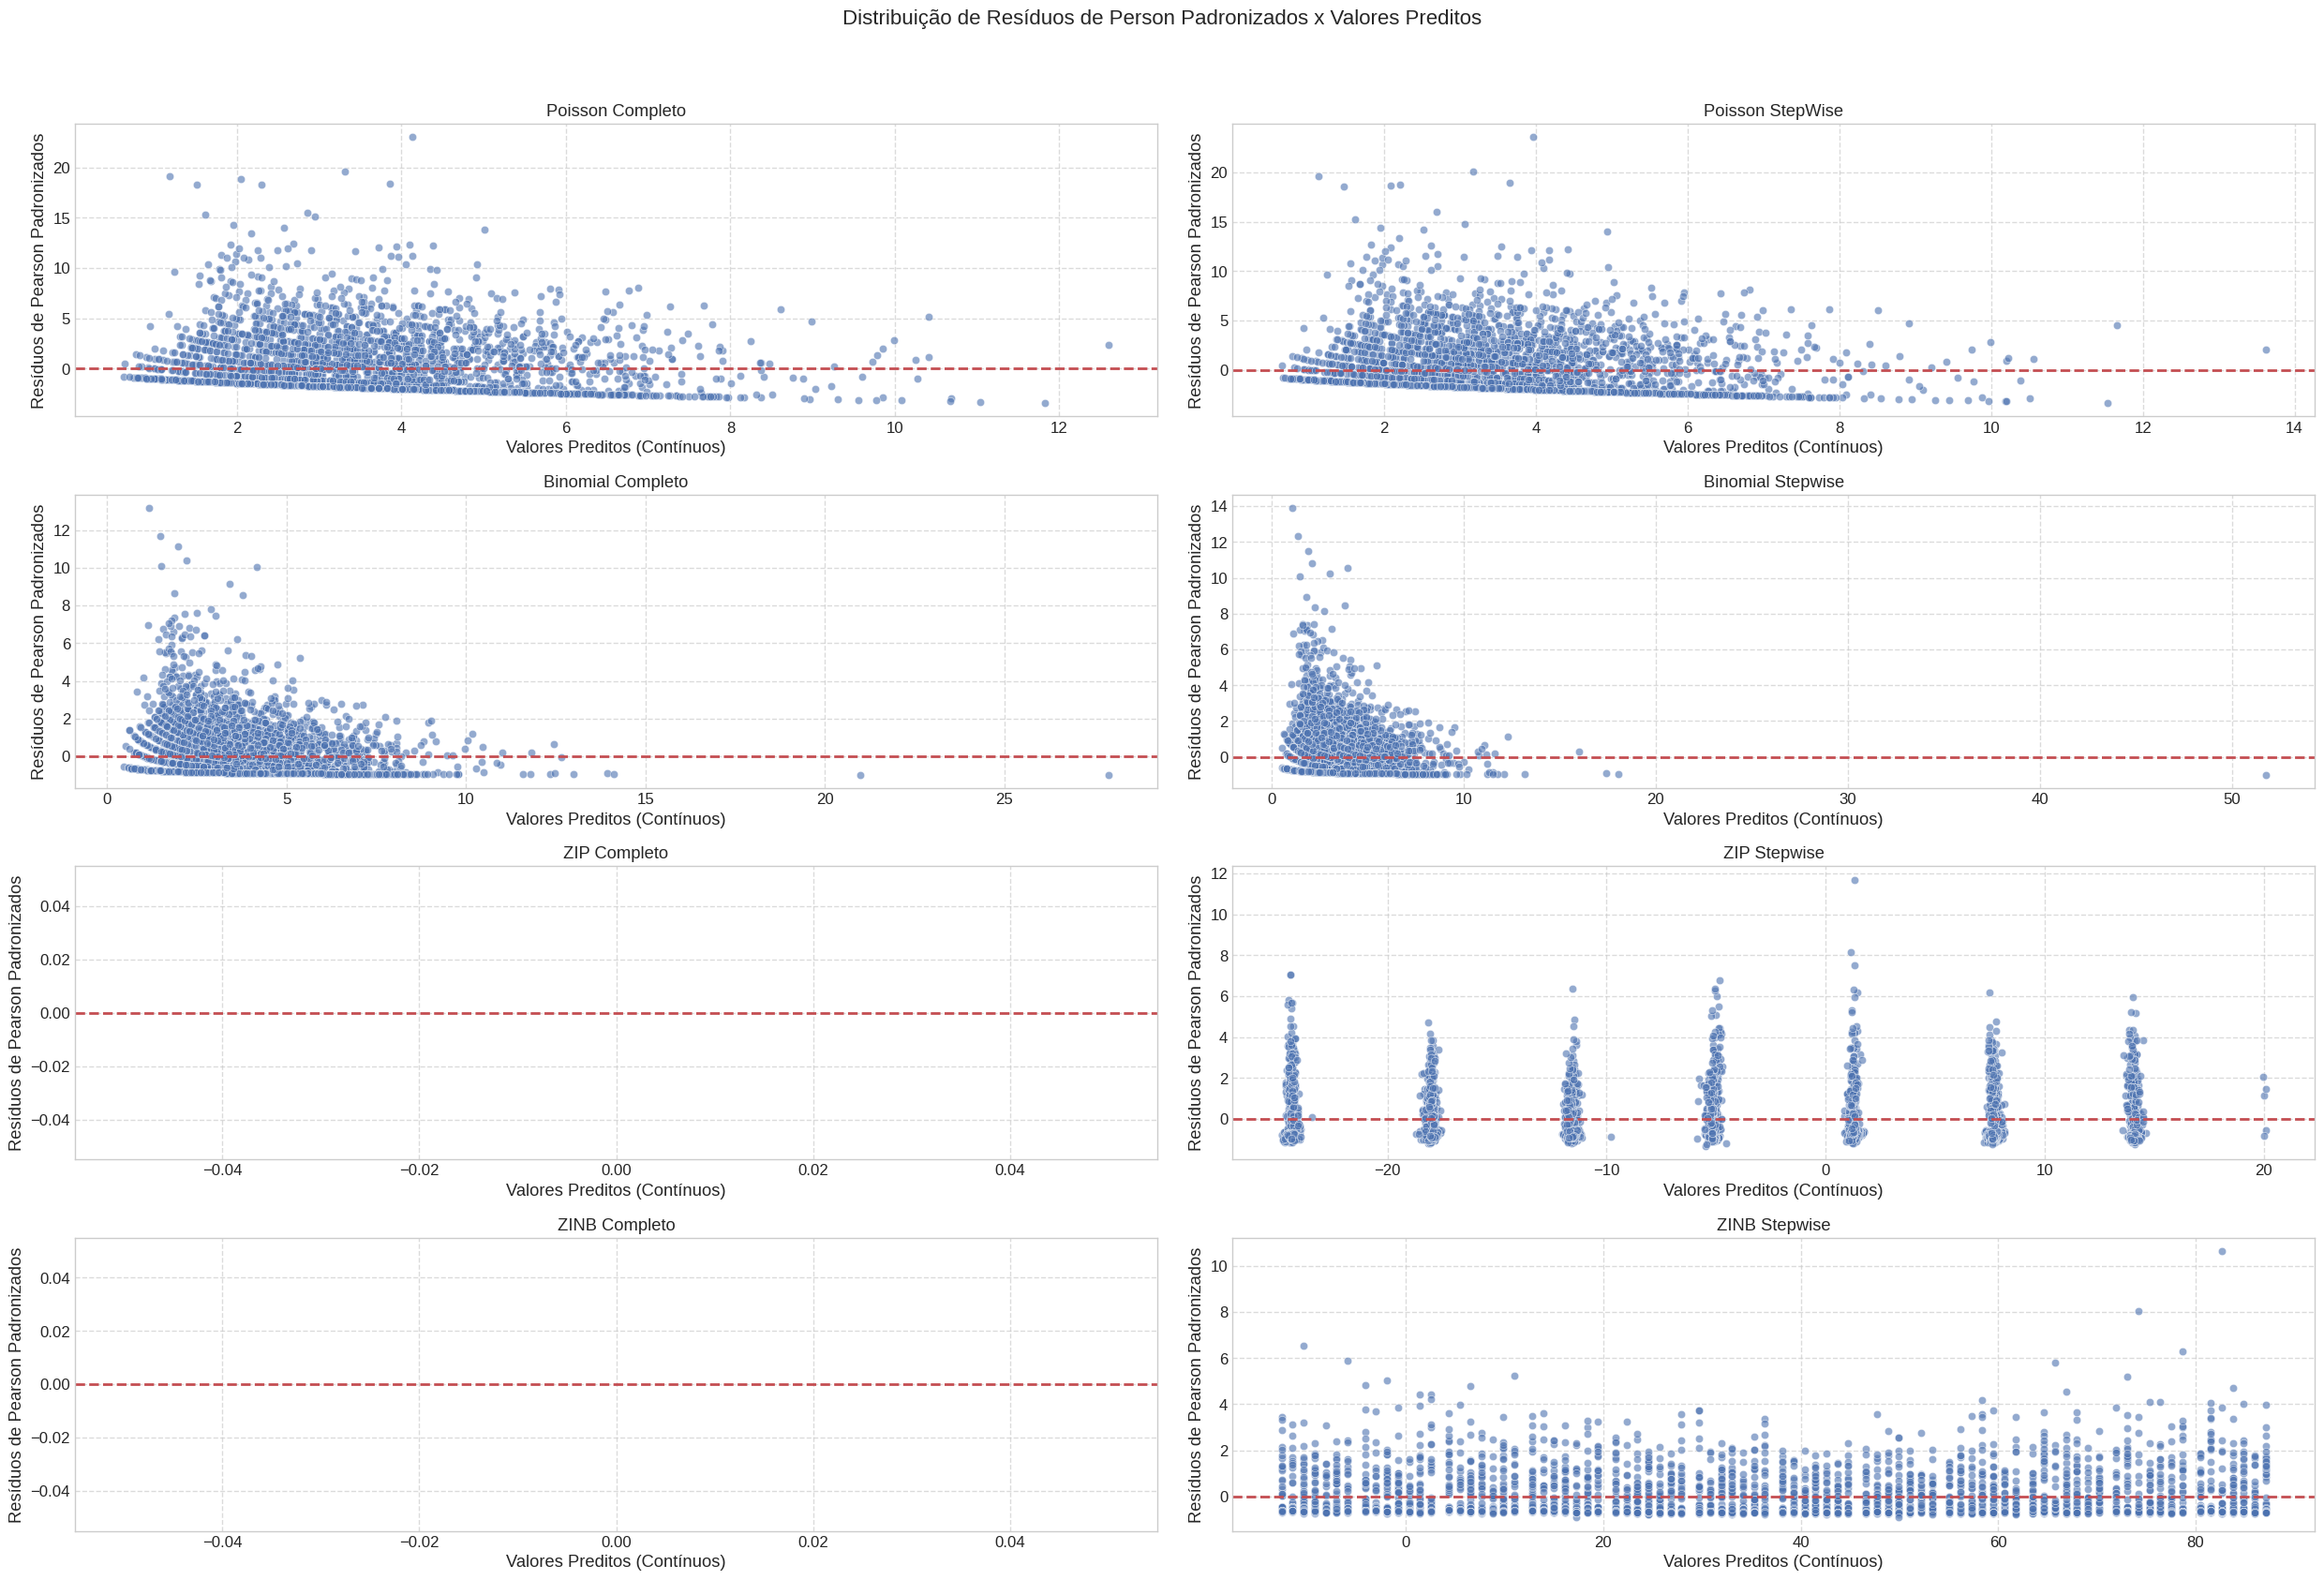

In [165]:
plt.figure(figsize=(25, 20))

# Define o título com uma posição mais alta usando y
plt.suptitle('Distribuição de Resíduos de Person Padronizados x Valores Preditos', fontsize=16, y=1.02)

# Ajusta espaço entre os subplots e o título
plt.subplots_adjust(top=0.92)

for i, model in enumerate(models):
    plt.subplot(5, 2, i + 1)
    overdisp_plot(model, titles[i], "{}")

plt.tight_layout()
plt.show()

Com base nos residuos de cada modelos em relação ao valor predito, podemos observar que o modelo ZINB Stepwise apresenta uma melhor distribuição dos residuos não apresentando um padrão fixo nos dados, sua dispersão é a menor em relação aos outros modelos e com poucos pontos extremos.

### Análise das métricas dos modelos

In [191]:
metrics = []
for title, model in zip(titles, models):
  metric = dict(title=title, LLF=model.llf, BIC=model.bic, AIC=model.aic, Converged=model.converged)

  if np.isnan(model.llf):
    continue

  rmse_resid = np.sqrt(np.mean(model.resid_pearson**2))
  outliers = np.sum(np.abs(model.resid_pearson) > 2)

  if hasattr(model, 'prsquared'):
    metric['PseudoR2'] = model.prsquared
  else:
    metric['PseudoR2'] = model.pseudo_rsquared()
  metric['RMSE_Pearson'] = rmse_resid
  metric['Outliers'] = outliers

  metrics.append(metric)

In [192]:
df_metrics = pd.DataFrame(metrics)
df_metrics.sort_values(by=['LLF', 'Converged'], ascending=False).reset_index(drop=True)

title           LLF           BIC           AIC  Converged  \
0      ZINB Stepwise -7.743067e+03  1.556059e+04  1.550413e+04       True   
1  Binomial Completo -8.751400e+03 -2.452450e+04  1.754080e+04       True   
2  Binomial Stepwise -8.757585e+03 -2.457832e+04  1.753717e+04       True   
3       ZIP Stepwise -9.047506e+03  1.819429e+04  1.811901e+04       True   
4   Poisson Completo -1.564343e+04 -7.196800e+03  3.132486e+04       True   
5   Poisson StepWise -1.564892e+04 -7.235454e+03  3.132384e+04       True   
6       ZIP Completo -4.583087e+06  9.166496e+06  9.166251e+06       True   

     PseudoR2  RMSE_Pearson  Outliers  
0    0.009087      0.991302       200  
1    0.168960      1.419545       340  
2    0.166332      1.427066       338  
3    0.044249      1.279623       337  
4    0.504542      2.775958      1186  
5    0.503151      2.781634      1184  
6 -483.143167           NaN      1764

In [193]:
df_metrics = df_metrics.query('Converged == True').sort_values(by=['RMSE_Pearson'], ascending=True).reset_index(drop=True)
df_metrics

title           LLF           BIC           AIC  Converged  \
0      ZINB Stepwise -7.743067e+03  1.556059e+04  1.550413e+04       True   
1       ZIP Stepwise -9.047506e+03  1.819429e+04  1.811901e+04       True   
2  Binomial Completo -8.751400e+03 -2.452450e+04  1.754080e+04       True   
3  Binomial Stepwise -8.757585e+03 -2.457832e+04  1.753717e+04       True   
4   Poisson Completo -1.564343e+04 -7.196800e+03  3.132486e+04       True   
5   Poisson StepWise -1.564892e+04 -7.235454e+03  3.132384e+04       True   
6       ZIP Completo -4.583087e+06  9.166496e+06  9.166251e+06       True   

     PseudoR2  RMSE_Pearson  Outliers  
0    0.009087      0.991302       200  
1    0.044249      1.279623       337  
2    0.168960      1.419545       340  
3    0.166332      1.427066       338  
4    0.504542      2.775958      1186  
5    0.503151      2.781634      1184  
6 -483.143167           NaN      1764

Percebemos que o modelo com maior LLF não convergiu durante o treinamento, o que invalida sua escolha uma vez que os pesos obtidos não refletem a correta relação dos dados com o modelo escohido.

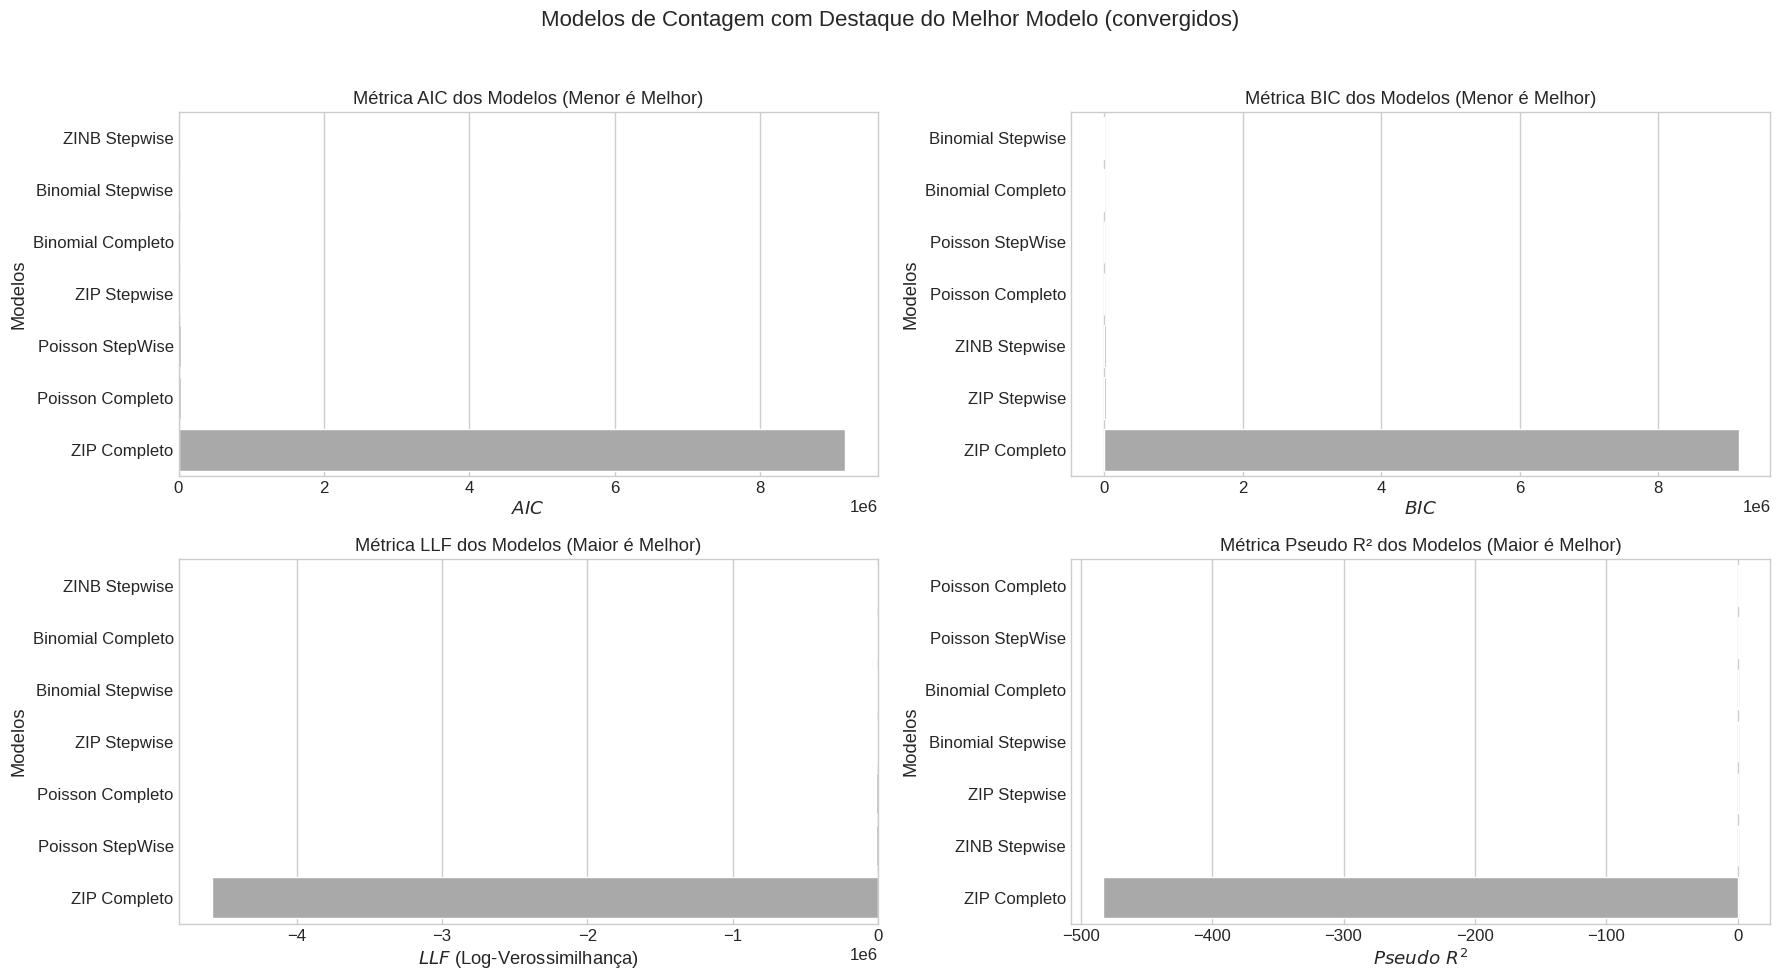

In [194]:
plt.figure(figsize=(18, 10))
plt.suptitle('Modelos de Contagem com Destaque do Melhor Modelo (convergidos)', fontsize=16)

# Cor de destaque para o melhor modelo e cor padrão para os outros
highlight_color = '#32a852' # Verde
default_color = '#a9a9a9'   # Cinza

# --- Subplot 1: AIC ---
plt.subplot(2, 2, 1)
plt.title('Métrica AIC dos Modelos (Menor é Melhor)')
# Ordena os valores para o gráfico
df_sorted = df_metrics.sort_values(by='AIC', ascending=True)
# Encontra o nome do melhor modelo (menor AIC)
best_model_aic = df_metrics.loc[df_metrics['AIC'].idxmin()]['title']
# Cria a paleta de cores: destaca o melhor modelo
palette_aic = [highlight_color if title == best_model_aic else default_color for title in df_sorted['title']]
# Plota o gráfico com a paleta de cores
sns.barplot(data=df_sorted, y='title', x='AIC', palette=palette_aic)
plt.xlabel('$AIC$')
plt.ylabel('Modelos')

# --- Subplot 2: BIC ---
plt.subplot(2, 2, 2)
plt.title('Métrica BIC dos Modelos (Menor é Melhor)')
df_sorted = df_metrics.sort_values(by='BIC', ascending=True)
best_model_bic = df_metrics.loc[df_metrics['BIC'].idxmin()]['title']
palette_bic = [highlight_color if title == best_model_bic else default_color for title in df_sorted['title']]
sns.barplot(data=df_sorted, y='title', x='BIC', palette=palette_bic)
plt.xlabel('$BIC$')
plt.ylabel('Modelos')

# --- Subplot 3: LLF ---
plt.subplot(2, 2, 3)
plt.title('Métrica LLF dos Modelos (Maior é Melhor)')
df_sorted = df_metrics.sort_values(by='LLF', ascending=False)
best_model_llf = df_metrics.loc[df_metrics['LLF'].idxmax()]['title']
palette_llf = [highlight_color if title == best_model_llf else default_color for title in df_sorted['title']]
sns.barplot(data=df_sorted, y='title', x='LLF', palette=palette_llf)
plt.xlabel('$LLF$ (Log-Verossimilhança)')
plt.ylabel('Modelos')

# --- Subplot 4: Pseudo R² ---
plt.subplot(2, 2, 4)
plt.title('Métrica Pseudo R² dos Modelos (Maior é Melhor)')
df_sorted = df_metrics.sort_values(by='PseudoR2', ascending=False)
best_model_r2 = df_metrics.loc[df_metrics['PseudoR2'].idxmax()]['title']
palette_r2 = [highlight_color if title == best_model_r2 else default_color for title in df_sorted['title']]
sns.barplot(data=df_sorted, y='title', x='PseudoR2', palette=palette_r2)
plt.xlabel('$Pseudo \ R^2$')
plt.ylabel('Modelos')

plt.tight_layout(rect=[0, 0, 1, 0.96]) # Ajusta o layout para não sobrepor o super-título
plt.show()

Podemos perceber que o modelo ZINB Stepwise se demonstra melhor em duas métricas, LLF e AIC, sendo assim a melhor escolha.

## Análise do melhor modelo

#### Seleção do melhor modelo

In [195]:
best_model = df_metrics.loc[0, 'title']
best_model

'ZINB Stepwise'

In [196]:
indice = titles.index(best_model)
best_model = models[indice]
best_model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                    Results: ZeroInflatedNegativeBinomialP
==============================================================================
Model:              ZeroInflatedNegativeBinomialP Pseudo R-squared: 0.009     
Dependent Variable: y                             AIC:              15504.1341
Date:               2025-08-20 02:11              BIC:              15560.5942
No. Observations:   3918                          Log-Likelihood:   -7743.1   
Df Model:           2                             LL-Null:          -7814.1   
Df Residuals:       3915                          LLR p-value:      1.4518e-31
Converged:          1.0000                        Scale:            1.0000    
Method:             MLE                                                       
-------------------------------------------------------------------------------
                            Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
-------------------------------------------------------------------------------
inflate_const              -5.8909    1.2678  -4.6467  0.0000  -8.3757  -3.4062
inflate_chip_ratio         -1.1129    0.1143  -9.7405  0.0000  -1.3369  -0.8890
inflate_cards_per_client    4.2268    0.8490   4.9787  0.0000   2.5628   5.8908
inflate_hour_of_day        -0.0028    0.0053  -0.5352  0.5925  -0.0131   0.0075
inflate_is_weekend          0.1564    0.0773   2.0240  0.0430   0.0050   0.3078
const                       1.8608    0.0518  35.9288  0.0000   1.7593   1.9623
day_of_week                 0.0524    0.0106   4.9595  0.0000   0.0317   0.0730
hour_of_day                -0.0104    0.0030  -3.4454  0.0006  -0.0163  -0.0045
alpha                       0.6333    0.0379  16.6957  0.0000   0.5590   0.7077
==============================================================================

"""

#### Tabela de features

In [197]:
df_exog_inf = pd.DataFrame()
if hasattr(best_model.model, 'exog_infl'):
  df_exog_inf = best_model.model.exog_infl
  feature_exog_inf = [column for column in best_model.model.exog_names if ('inflate_' in column)]
  df_exog_inf = pd.DataFrame(df_exog_inf, columns=feature_exog_inf)

In [198]:
df_exog = best_model.model.exog
features_exog = [column for column in best_model.model.exog_names if not ('inflate_' in column or 'alpha' in column)]
df_exog = pd.DataFrame(df_exog, columns=features_exog)

In [199]:
df_features = pd.concat([df_exog, df_exog_inf], axis=1)
df_features['residuos'] = best_model.resid_response
df_features['fitted'] = best_model.fittedvalues
df_features['target'] = y
df_features

const  day_of_week  hour_of_day  inflate_const  inflate_chip_ratio  \
0       1.0          4.0          0.0            1.0            0.000000   
1       1.0          4.0         22.0            1.0            0.000000   
2       1.0          5.0         20.0            1.0            0.000000   
3       1.0          6.0         18.0            1.0            0.000000   
4       1.0          0.0         16.0            1.0            0.000000   
...     ...          ...          ...            ...                 ...   
3913    1.0          6.0         22.0            1.0            0.702427   
3914    1.0          0.0         20.0            1.0            0.676652   
3915    1.0          1.0         18.0            1.0            0.696133   
3916    1.0          2.0         16.0            1.0            0.696078   
3917    1.0          3.0         14.0            1.0            0.702929   

      inflate_cards_per_client  inflate_hour_of_day  inflate_is_weekend  \
0                     1.428405                  0.0                 0.0   
1                     1.358788                 22.0                 0.0   
2                     1.393904                 20.0                 1.0   
3                     1.380298                 18.0                 1.0   
4                     1.387173                 16.0                 0.0   
...                        ...                  ...                 ...   
3913                  1.535961                 22.0                 1.0   
3914                  1.484310                 20.0                 0.0   
3915                  1.466377                 18.0                 0.0   
3916                  1.511868                 16.0                 0.0   
3917                  1.235690                 14.0                 0.0   

      residuos  fitted  target  
0    -3.673173     NaN     NaN  
1    -2.485012     NaN     NaN  
2    -3.223690     NaN     NaN  
3    -2.562656     NaN     NaN  
4     0.177574     NaN     NaN  
...        ...     ...     ...  
3913 -3.654564     NaN     NaN  
3914 -3.161776     NaN     NaN  
3915 -3.523581     NaN     NaN  
3916 -3.504345     NaN     NaN  
3917 -5.309569     NaN     NaN  

[3918 rows x 11 columns]

#### Análises de resíduos padronizados

##### Histograma

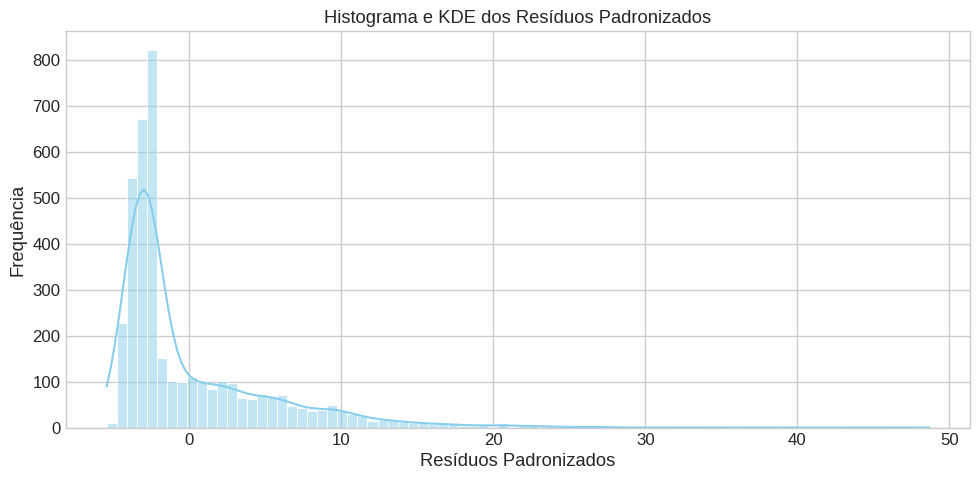

In [200]:
plt.figure(figsize=(10, 5))
sns.histplot(df_features["residuos"], kde=True, color='skyblue')
plt.title("Histograma e KDE dos Resíduos Padronizados")
plt.xlabel("Resíduos Padronizados")
plt.ylabel("Frequência")
plt.tight_layout()
plt.show()

##### Análise dos residuos com um quantis teóricos

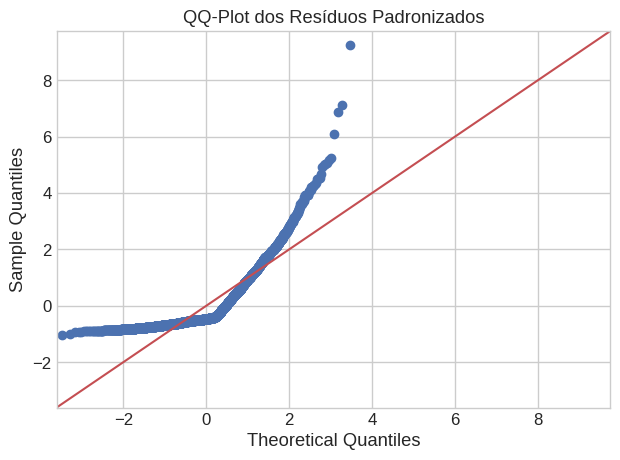

In [201]:
sm.qqplot(df_features["residuos"], line='45', fit=True)
plt.title("QQ-Plot dos Resíduos Padronizados")
plt.tight_layout()
plt.show()

##### Testes de normalidades de resíduos

In [202]:
# Shapiro-Wilk
shapiro_stat, shapiro_p = stats.shapiro(df_features["residuos"])
print(f"[Shapiro-Wilk] Estatística: {shapiro_stat:.4f} | p-valor: {shapiro_p:.4f}")

alpha = 0.05
if shapiro_p > alpha:
    print("Não rejeitamos H₀: os resíduos seguem uma distribuição normal (dentro do nível de 5%).")
else:
    print("Rejeitamos H₀: os resíduos NÃO seguem uma distribuição normal.")

[Shapiro-Wilk] Estatística: 0.7453 | p-valor: 0.0000
Rejeitamos H₀: os resíduos NÃO seguem uma distribuição normal.


In [203]:
# D’Agostino and Pearson's test
dagostino_stat, dagostino_p = stats.normaltest(df_features["residuos"])
print(f"[D’Agostino] Estatística: {dagostino_stat:.4f} | p-valor: {dagostino_p:.4f}")

alpha = 0.05  # nível de significância
if dagostino_p > alpha:
    print("Não rejeitamos H₀: os resíduos seguem uma distribuição normal (dentro do nível de 5%).")
else:
    print("Rejeitamos H₀: os resíduos NÃO seguem uma distribuição normal.")

[D’Agostino] Estatística: 1803.3974 | p-valor: 0.0000
Rejeitamos H₀: os resíduos NÃO seguem uma distribuição normal.


##### Teste de validação de homocedasticidade

In [204]:
X = sm.add_constant(df_features["fitted"])
model_bp = sm.OLS(df_features["residuos"], X).fit()
bp_test = het_breuschpagan(model_bp.resid, X)
bp_labels = ['LM Stat', 'LM p-val', 'F Stat', 'F p-val']

print("\n[Breusch-Pagan]")
for label, val in zip(bp_labels, bp_test):
    print(f"{label}: {val:.4f}")

# Define o nível de significância (alpha)
alpha = 0.05
p_valor_lm = bp_test[1] # p-valor da estatística LM é o mais comum

print(f"\n--- Validação da Hipótese (Nível de Significância α = {alpha}) ---")
print("H₀ (Hipótese Nula): O modelo é homocedástico (variância dos erros é constante).")
print("Hₐ (Hipótese Alternativa): O modelo é heterocedástico (variância dos erros não é constante).")

if p_valor_lm < alpha:
    print(f"\nResultado: O p-valor ({p_valor_lm:.4f}) é MENOR que {alpha}.")
    print("Decisão: Rejeitamos a Hipótese Nula (H₀).")
    print("Conclusão: A validação indica que o modelo APRESENTA HETEROCEDASTICIDADE.")
else:
    print(f"\nResultado: O p-valor ({p_valor_lm:.4f}) é MAIOR ou IGUAL a {alpha}.")
    print("Decisão: Não Rejeitamos a Hipótese Nula (H₀).")
    print("Conclusão: A validação indica que o modelo é HOMOCEDÁSTICO.")


MissingDataError: exog contains inf or nans

##### Teste de autocorrelação de resíduos

In [205]:
# Teste de Autocorrelação (Durbin-Watson)
dw_stat = durbin_watson(df_features["residuos"])

print(f"\n--- Resultado do Teste de Durbin-Watson ---")
print(f"Estatística d: {dw_stat:.4f}")

# --- VALIDAÇÃO AUTOMÁTICA DAS HIPÓTESES ---
print(f"\n--- Validação da Hipótese (Regra de Bolso 1.5 - 2.5) ---")
print("H₀ (Hipótese Nula): Não há autocorrelação entre os resíduos.")
print("Hₐ (Hipótese Alternativa): Existe autocorrelação entre os resíduos.")

if dw_stat < 1.5:
    print(f"\nResultado: A estatística ({dw_stat:.4f}) é MENOR que 1.5.")
    print("Decisão: Rejeitamos a Hipótese Nula (H₀).")
    print("Conclusão: O teste indica a presença de AUTOCORRELAÇÃO POSITIVA.")

elif dw_stat > 2.5:
    print(f"\nResultado: A estatística ({dw_stat:.4f}) é MAIOR que 2.5.")
    print("Decisão: Rejeitamos a Hipótese Nula (H₀).")
    print("Conclusão: O teste indica a presença de AUTOCORRELAÇÃO NEGATIVA.")

else: # A estatística está entre 1.5 e 2.5
    print(f"\nResultado: A estatística ({dw_stat:.4f}) está dentro da faixa segura [1.5, 2.5].")
    print("Decisão: Não Rejeitamos a Hipótese Nula (H₀).")
    print("Conclusão: O teste NÃO indica a presença de autocorrelação de primeira ordem.")



--- Resultado do Teste de Durbin-Watson ---
Estatística d: 1.4680

--- Validação da Hipótese (Regra de Bolso 1.5 - 2.5) ---
H₀ (Hipótese Nula): Não há autocorrelação entre os resíduos.
Hₐ (Hipótese Alternativa): Existe autocorrelação entre os resíduos.

Resultado: A estatística (1.4680) é MENOR que 1.5.
Decisão: Rejeitamos a Hipótese Nula (H₀).
Conclusão: O teste indica a presença de AUTOCORRELAÇÃO POSITIVA.


In [207]:
validar_autocorrelacao_ljung_box(best_model.resid_pearson)


--- Resultados do Teste de Ljung-Box ---
        lb_stat  lb_pvalue
20  5639.793292        0.0

--- Validação da Hipótese (Nível de Significância α = 0.05) ---
H₀ (Hipótese Nula): Os resíduos são independentes e não correlacionados (ruído branco).
Hₐ (Hipótese Alternativa): Os resíduos não são independentes; existe autocorrelação.

Resultado: O p-valor (0.0000) é MENOR que 0.05.
Decisão: Rejeitamos a Hipótese Nula (H₀).
Conclusão: O teste indica a presença de AUTOCORRELAÇÃO nos resíduos.


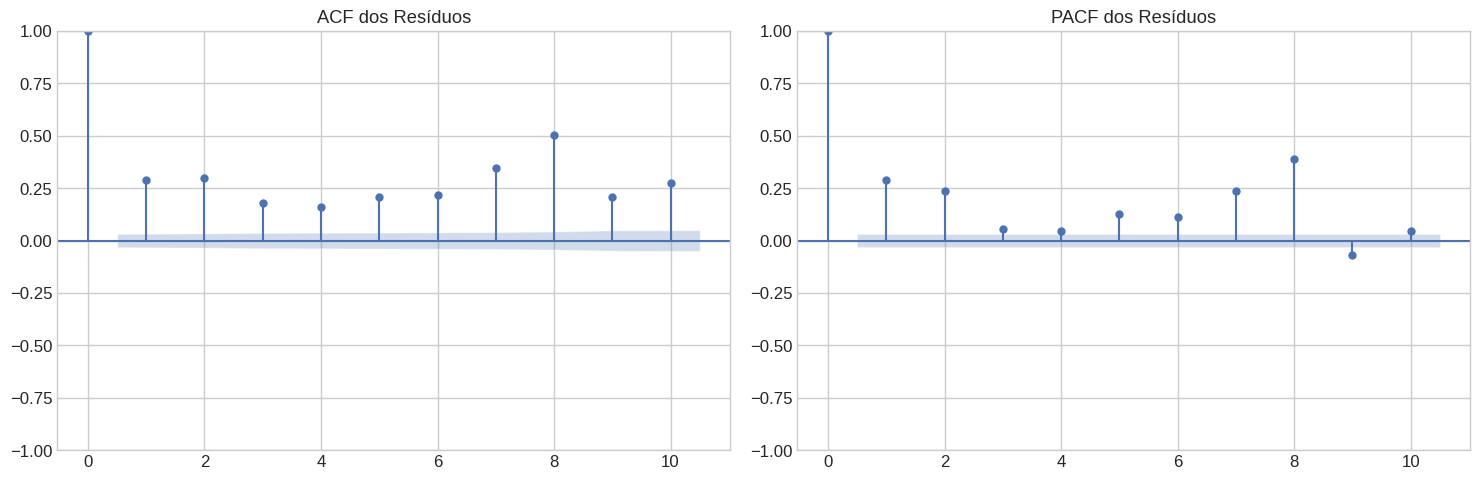

In [209]:
plot_acf_pacf(best_model.resid_pearson, 10)

## Inferência Estatistica

In [210]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedNegativeBinomialP Regression Results                    
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 3918
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                     3915
Method:                                      MLE   Df Model:                            2
Date:                           Wed, 20 Aug 2025   Pseudo R-squ.:                0.009087
Time:                                   02:11:54   Log-Likelihood:                -7743.1
converged:                                  True   LL-Null:                       -7814.1
Covariance Type:                       nonrobust   LLR p-value:                 1.452e-31
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
inflate_const               -5.8909      1.268     -4.647      0.000      -8.376      -3.406
inflate_chip_ratio          -1.1129      0.114     -9.741      0.000      -1.337      -0.889
inflate_cards_per_client     4.2268      0.849      4.979      0.000       2.563       5.891
inflate_hour_of_day         -0.0028      0.005     -0.535      0.592      -0.013       0.008
inflate_is_weekend           0.1564      0.077      2.024      0.043       0.005       0.308
const                        1.8608      0.052     35.929      0.000       1.759       1.962
day_of_week                  0.0524      0.011      4.960      0.000       0.032       0.073
hour_of_day                 -0.0104      0.003     -3.445      0.001      -0.016      -0.004
alpha                        0.6333      0.038     16.696      0.000       0.559       0.708
============================================================================================
"""

In [211]:
params = best_model.params
conf = best_model.conf_int()
conf['OR'] = params
conf.columns = ['2.5%', '97.5%', 'IRR']
conf = np.exp(conf)
conf

2.5%       97.5%        IRR
inflate_const              0.000230    0.033168   0.002764
inflate_chip_ratio         0.262665    0.411070   0.328594
inflate_cards_per_client  12.972222  361.678244  68.496499
inflate_hour_of_day        0.986950    1.007529   0.997186
inflate_is_weekend         1.004964    1.360484   1.169289
const                      5.808233    7.115623   6.428778
day_of_week                1.032170    1.075776   1.053747
hour_of_day                0.983879    0.995544   0.989694
alpha                      1.748904    2.029295   1.883890

In [212]:
# Calculando a estatística Qui-quadrado de Pearson
chi2_stat = np.sum(best_model.resid_pearson**2)
dof = best_model.df_resid # Graus de liberdade (observações - número de parâmetros)
p_value_gof = stats.chi2.sf(chi2_stat, dof)

print("\n--- Diagnóstico do Modelo ---")
print(f"Estatística Qui-quadrado de Pearson: {chi2_stat:.2f}")
print(f"Graus de Liberdade: {dof}")
print(f"P-valor do Teste de Goodness-of-Fit: {p_value_gof:.4f}")

if p_value_gof > 0.05:
    print("Conclusão: Não há evidência para rejeitar a hipótese nula. O modelo parece se ajustar bem aos dados (p > 0.05).")
else:
    print("Conclusão: O p-valor é baixo (p <= 0.05), o que sugere um possível mau ajuste do modelo.")



--- Diagnóstico do Modelo ---
Estatística Qui-quadrado de Pearson: 3850.14
Graus de Liberdade: 3915.0
P-valor do Teste de Goodness-of-Fit: 0.7672
Conclusão: Não há evidência para rejeitar a hipótese nula. O modelo parece se ajustar bem aos dados (p > 0.05).


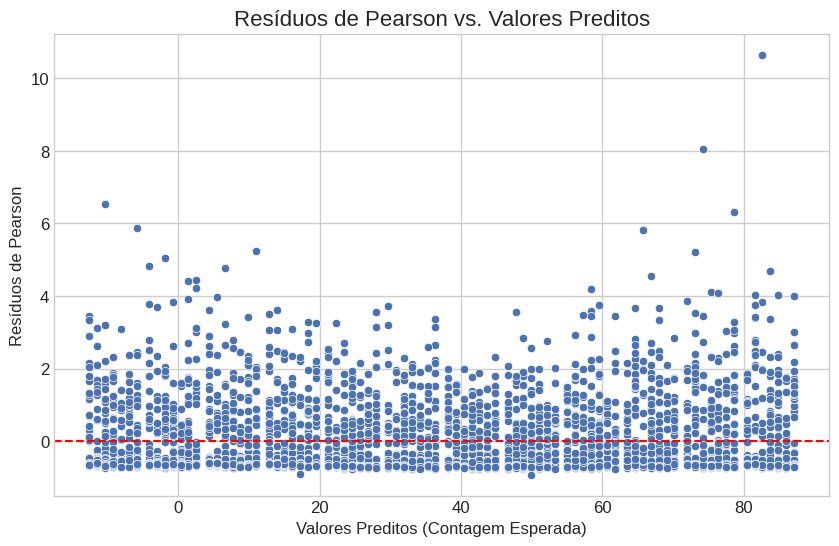

In [213]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=best_model.fittedvalues, y=best_model.resid_pearson)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Resíduos de Pearson vs. Valores Preditos', fontsize=16)
plt.xlabel('Valores Preditos (Contagem Esperada)', fontsize=12)
plt.ylabel('Resíduos de Pearson', fontsize=12)
plt.show()